In [1]:
from datasets import get_dataloaders

from easydict import EasyDict as edict
from train import train
import wandb

args = edict()
args.num_epochs = 50

args.encoder = {
    'pretrained': True,
    'id': '7sr7r9sb',
    'epoch': 50,
    'pretrained_feats': False,
    'output_dim': 384,
    'arch': 'lvit',
    'frozen': True}

args.train_method = "task_jepa"
args.from_pretrained = ""
args.seed = 444
args.test = True

args.num_workers = 0
METRICS_PER_METHOD = {
                      "erm": ['acc'],
                      "task_jepa": ['acc'], 
                      "ijepa": ['acc'],
                      "task_jepa+erm": ['acc'],
                      "pair_erm": ["acc"],
                      "encoder_erm": ['acc']
                     }

FOVS = {"shapes3d": {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}}
FOVS_PER_DATASET = {'shapes3d': ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"]}
#FOVS_PER_DATASET = {'shapes3d': ["floor_hue", "wall_hue", "scale", "shape", "orientation"]}

args.best_model_criterion = "val_avg_acc"
args.metrics = METRICS_PER_METHOD[args.train_method]
args.dataset = "shapes3d"
args.fovs =  FOVS_PER_DATASET[args.dataset]
args.fovs_tasks = ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"]
args.fovs_indices = {name: i for i, name in enumerate(args.fovs)}
# When 2, 0 == same, 1 = different, When 3 levels, 0 = same, 1 = greater than, 2 = lower than
args.fovs_levels = {"floor_hue": 2, "wall_hue": 2, "object_hue": 2, "scale": 3, "shape": 2, "orientation": 3}
args.fovs_ids = [args.fovs_indices[x] for x in args.fovs_tasks ]
args.n_fovs = FOVS[args.dataset]
args.task_to_label_index = {k: i for i, k in enumerate(args.fovs_tasks)}
args.data_dir = "/mnt/nas2/GrimaRepo/araymond/3dshapes"

# optimization
args.ema_start = 0.999 # starting value for exponential moving average for jepa methods
args.iters_per_ema = 16.0 # after how many iterations to apply ema
args.ipe_scale = 1.0
args.lr = 0.001
args.start_lr = 0.0002
args.final_lr = 1.0e-06
args.wd = 0.04
args.final_wd = 0.4
args.warmup = 2.0/15.0*args.num_epochs


/home/araymond/storage/pyenv/versions/3.10.14/envs/mini/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
There was a problem when trying to write in your cache folder (/storage/cache). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


In [2]:
dls = get_dataloaders(args)

In [5]:
import torch
from models import create_model
from torch.nn import Parameter
def create_pairs(args, x, y):
    # define pairs and labels for pairwise training
    n_fovs = y.shape[-1]
    # create all pairs of input and target
    B, C, H, W = x.shape
    # only keep pairs where shapes are equal
    
    # Expand dimensions to create all pair combinations of images
    # x.unsqueeze(1) makes the shape (B, 1, C, H, W)
    # x.unsqueeze(0) makes the shape (1, B, C, H, W)
    image_pairs_1 = x.unsqueeze(1).expand(B, B, C, H, W)  # First element of the pairs (B, B, C, H, W)
    image_pairs_2 = x.unsqueeze(0).expand(B, B, C, H, W)  # Second element of the pairs (B, B, C, H, W)
    
    # Stack along a new dimension (2), so each pair is represented by (B, B, 2, C, H, W)
    all_image_pairs = torch.stack((image_pairs_1, image_pairs_2), dim=2)
    latents_diff = y.unsqueeze(1) - y.unsqueeze(0)
    latents_diff = latents_diff.view(-1, n_fovs)
    #equal_shape  = latents_diff[:,4] == 0 # for selecting pairs where the shape is the same
    # relabel diffs for classification
    # first for shape, floor color, wall color, object color, two values = 0 for same, 1 for different

    # Get the relevant columns
    cols = [0, 1, 2, 4]
    # Modify the tensor in place: set values != 0 to 1 for the selected columns
    latents_diff[:, cols] = torch.where(latents_diff[:, cols] != 0, torch.tensor(1), latents_diff[:, cols])
    # For dimensions [3, 5]: set values > 0 to 1 and values < 0 to 2
    latents_diff[:, [3, 5]] = torch.where(latents_diff[:, [3, 5]] > 0, torch.tensor(1), latents_diff[:, [3, 5]])
    latents_diff[:, [3, 5]] = torch.where(latents_diff[:, [3, 5]] < 0, torch.tensor(2), latents_diff[:, [3, 5]])

    #for i in range(6):
    #    print(torch.unique(latents_diff[:,i], return_counts=True))

    latents_diff = latents_diff[:,args.fovs_ids].long()
    all_image_pairs = all_image_pairs.view(-1, 2, C, H, W)
    #all_image_pairs = all_image_pairs[equal_shape]
    # latents_diff = latents_diff[equal_shape]
    # latents_zeros = torch.zeros_like(latents_diff)
    # Make image pairs (input, target) and assign correct latents
    x_input = all_image_pairs[:,0].squeeze()
    x_target = all_image_pairs[:,1].squeeze()
    x = [x_input , x_target]
    y = latents_diff
    
    return x, y
    
def evaluate(args, dl):
    def get_preds(output_grads):
        # Get the relevant columns
        cols = [0, 1, 2, 4]
        # Modify the tensor in place: set values != 0 to 1 for the selected columns
        output_grads[:, cols] = torch.where(output_grads[:, cols] > 0.5, torch.tensor(1), output_grads[:, cols])
        # For dimensions [3, 5]: set values > 0 to 1 and values < 0 to 2
        output_grads[:, [3, 5]] = torch.where(output_grads[:, [3, 5]] > 0.5, torch.tensor(1), output_grads[:, [3, 5]])
        output_grads[:, [3, 5]] = torch.where(output_grads[:, [3, 5]] < 0.5, torch.tensor(2), output_grads[:, [3, 5]])

        return output_grads
    criterion = torch.nn.MSELoss()
    # Create a tensor of zeros and wrap it in a Parameter

    batch_size = 256
    model = create_model(args)[0].cuda()

    for n_batch, (x, y) in enumerate(dl):
        x,y = create_pairs(args, x,y)
        y = y.cuda()
        # define parameter vector full of zeros
        grads = []
        parameters = Parameter(torch.zeros_like(y).float()).cuda()
        optimizer = torch.optim.SGD([parameters],lr=1.0)
        latents_zeros = torch.zeros_like(y).cuda()
        print(x[0].shape)
        rep_x1 = model(x[0].cuda(), parameters)
        rep_x2 = model(x[1].cuda(), latents_zeros)
        loss = criterion(rep_x1, rep_x2)
        optimizer.zero_grad()
        loss.backward()
        print(parameters.grad)
        preds = get_preds(parameters.grad)
        correct = (preds == y).float().sum(dim=0)
        acc = correct/batch_size
        print(f"Acc: {acc}%")
evaluate(args, dls['train'])

Loading Weights from models/7sr7r9sb/50.pth
torch.Size([256, 3, 64, 64])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 1.3633e-06, -4.0091e-06,  1.4075e-06, -1.4309e-07, -1.3339e-07,
         -4.1319e-08],
        [ 3.2708e-07, -2.4965e-07, -5.3020e-08, -2.3071e-09, -3.8575e-09,
          4.8773e-09],
        ...,
        [ 9.5564e-07, -6.7568e-06, -1.3446e-07, -2.0140e-07, -7.8028e-08,
          1.0118e-07],
        [-8.5818e-08, -5.7791e-06,  1.2031e-07, -2.3204e-07, -1.4877e-07,
          5.8124e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]], device='cuda:0')
Acc: tensor([0.0625, 0.0625, 0.0625, 0.3984, 0.0625, 0.4492], device='cuda:0')%


In [5]:
from models import create_model
from torch.optim import SGD
from utils import pprint_metrics
from train import get_criterion, create_pairs
import torch


models = create_model(args)
models = tuple(model.cuda() for model in models)
best_model = models
best_metrics = None
if args.train_method == "encoder_erm":
    params = [
                {'params': models[0].parameters()},
                {'params': models[1].parameters()}
            ]
    print(models[1])
else:
    params = [{'params': models[0].parameters()}]
    print(models[0])

#params = list(models[0].parameters()) + list(models[1].parameters())
optimizer = SGD(params, lr=args.lr)
criterion = get_criterion(args)
# start W&B experiment

MultiHeadClassifier(
  (classifiers): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=14, bias=True)
  )
)


In [9]:

all_metrics = {'train': [], 'val': [], 'test': []}
epoch=1
full_metrics = dict()
print(f"EPOCH {epoch}")
# model, train_metrics = run_epoch(args, models, dls['train'], criterion, optimizer, train=True, split = "train")

# define train met
# Loop

(x,y) = next(iter(dls['train']))
x = x.cuda()
y = y.cuda()
x, y = create_pairs(args, x, y)

# model, loss, output = step_function(args, model, x, y, criterion, optimizer, train=train)

encoder, predictor = models # encoder extracts features, predictor predicts on task given features
                                # if running from precalculated features, encoder is just the Identity


EPOCH 1


In [8]:
ema = [args.ema_start, 1.0]      # exponential moving average
ipe = len(dls['train']) # iterations per epoch
ipe_scale = 1.0
momentum_scheduler = [ema[0] + i*(ema[1]-ema[0])/(ipe*args.num_epochs*ipe_scale)
                  for i in range(int(ipe*args.num_epochs*ipe_scale)+1)]

In [7]:
momentum_scheduler

[0.9, 0.92, 0.9400000000000001, 0.96, 0.98, 1.0]

In [9]:
a = iter(momentum_scheduler)

In [49]:
import torch
from torchvision import models, transforms

# Load a pretrained Vision Transformer model
vit_model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_V1)

# Get the preprocessing transforms for the model
preprocess = models.ViT_L_16_Weights.IMAGENET1K_V1.transforms()

# Example input image (replace with your actual image)
from PIL import Image
image = Image.open("Tinca_tinca_Prague_Vltava_2.jpg").convert("RGB")
image = Image.open("White_shark.jpg").convert("RGB")

# Preprocess the image
#image = torch.randn((10,3,64,64))
#print(image)
#print(input_tensor.view(10,3,-1).mean(dim=0).mean(dim=-1))
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
#print(input_tensor)
#print(input_tensor.shape)
#print(input_tensor.view(10,3,-1).mean(dim=0).mean(dim=-1))
# Run the image through the model
#vit_model.heads = torch.nn.Identity()
vit_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = vit_model(input_tensor)

# Output is logits for ImageNet classes
print("Output shape:", output.shape)  # Should be [1, 1000]


Output shape: torch.Size([1, 1000])


In [50]:
models.ViT_L_16_Weights.IMAGENET1K_V1.meta['categories'][output.argmax().item()]

'great white shark'

In [44]:
models.ViT_L_16_Weights.IMAGENET1K_V1.meta['categories']

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [6]:
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
import time
for n_iter  in range(1000):

    start_time = time.time()
    bs, *_ = x[0].shape

    x_1 = encoder(x[0])
    x_2 = encoder(x[1])
    
    features = torch.cat([x_1, x_2], dim=-1)
    output = predictor(features)

    loss = []
    # decompose loss per task
    for i, fov in enumerate(args.fovs_tasks):
        #print(output[i].shapen_iter, y[:,i].shape)
        loss.append(criterion(output[i], y[:,i]))
    
    loss = torch.stack(loss)
    avg_loss = loss.mean()
    # print(avg_loss)
    #output = [o.detach().cpu() for o in output]
    
    
    optimizer.zero_grad()
    avg_loss.backward()       
    
    optimizer.step() 
    end_time = time.time()
    print(f"Iteration {n_iter}: time: {end_time-start_time:0.2f}s")

Iteration 0: time: 0.03s
Iteration 1: time: 0.06s
Iteration 2: time: 0.24s
Iteration 3: time: 0.24s
Iteration 4: time: 0.24s
Iteration 5: time: 0.24s
Iteration 6: time: 0.24s
Iteration 7: time: 0.24s
Iteration 8: time: 0.24s
Iteration 9: time: 0.24s
Iteration 10: time: 0.24s
Iteration 11: time: 0.24s
Iteration 12: time: 0.24s
Iteration 13: time: 0.24s
Iteration 14: time: 0.24s
Iteration 15: time: 0.24s
Iteration 16: time: 0.24s
Iteration 17: time: 0.24s
Iteration 18: time: 0.24s
Iteration 19: time: 0.24s
Iteration 20: time: 0.24s


KeyboardInterrupt: 

In [6]:
print(output)

(tensor([[ 2.2443, -2.0821],
        [-2.2386,  1.7212],
        [-1.9967,  2.1842],
        [ 2.1110, -2.1121]], device='cuda:0',
       grad_fn=<SplitWithSizesBackward0>),)


In [95]:
x_1, x_2

(tensor([[-0.7036, -1.0279, -0.9603,  ...,  1.2547,  0.1836, -0.6816],
         [-0.7036, -1.0279, -0.9603,  ...,  1.2547,  0.1836, -0.6816],
         [ 0.9800,  1.0282, -1.6931,  ..., -0.8758,  0.9909, -1.4770],
         [ 0.9800,  1.0282, -1.6931,  ..., -0.8758,  0.9909, -1.4770]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([[-0.7036, -1.0279, -0.9603,  ...,  1.2547,  0.1836, -0.6816],
         [ 0.9800,  1.0282, -1.6931,  ..., -0.8758,  0.9909, -1.4770],
         [-0.7036, -1.0279, -0.9603,  ...,  1.2547,  0.1836, -0.6816],
         [ 0.9800,  1.0282, -1.6931,  ..., -0.8758,  0.9909, -1.4770]],
        device='cuda:0', grad_fn=<SelectBackward0>))

In [7]:
y

tensor([[0],
        [1],
        [1],
        [0]], device='cuda:0')

In [8]:
criterion(output[0],y[:,0])

tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)

In [94]:
y[:,0]

tensor([0, 1, 1, 0], device='cuda:0')

In [8]:
import torch
data = torch.randn((256, 1024))

torch.var(data, dim=0).mean()

tensor(0.9977)

In [28]:
next(encoder.conv_proj.parameters()).grad

tensor([[[[-5.1232e-03, -5.2682e-03, -5.4161e-03,  ..., -5.3745e-03,
           -5.1327e-03, -4.5990e-03],
          [-5.6277e-03, -5.6417e-03, -5.6487e-03,  ..., -5.6104e-03,
           -5.4083e-03, -4.8965e-03],
          [-5.7779e-03, -5.8565e-03, -5.7923e-03,  ..., -5.6576e-03,
           -5.4109e-03, -4.7768e-03],
          ...,
          [-5.5204e-03, -5.6871e-03, -5.8775e-03,  ..., -5.8345e-03,
           -5.5674e-03, -5.0833e-03],
          [-6.1732e-03, -6.1737e-03, -6.4255e-03,  ..., -6.3312e-03,
           -6.3149e-03, -6.0873e-03],
          [-6.9589e-03, -6.8827e-03, -6.8809e-03,  ..., -6.5141e-03,
           -6.6416e-03, -6.5300e-03]],

         [[ 9.8386e-04,  9.7836e-04,  9.3217e-04,  ...,  9.3752e-04,
            1.0823e-03,  1.0313e-03],
          [ 7.9187e-04,  8.1978e-04,  8.3579e-04,  ...,  7.6926e-04,
            9.0327e-04,  9.1521e-04],
          [ 5.4005e-04,  5.6814e-04,  6.4669e-04,  ...,  7.3796e-04,
            8.9241e-04,  9.0117e-04],
          ...,
     

In [31]:
train(args, dls)

MultiHeadClassifier(
  (classifiers): Linear(in_features=768, out_features=2, bias=True)
)


  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 1


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.2301e-01,  7.1114e-02,  5.9870e-02,  2.5190e-01, -1.8678e-01,
        -2.5321e-02, -2.5016e-01,  4.3157e-02,  2.6924e-01, -1.1879e-01,
         7.8629e-02,  2.5748e-01,  2.3228e-01, -1.8605e-02, -2.2352e-01,
         1.7129e-01, -1.0743e-01, -1.3641e-01, -2.4523e-01, -1.9572e-01,
        -1.2560e-01,  8.0451e-02,  3.6780e-01, -7.2239e-02, -2.4349e-01,
        -3.0946e-01,  6.3879e-02, -1.1960e-01, -1.45

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 1.2894



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.8993

EPOCH 2


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 0.5295, -0.0117, -0.2655, -0.4227,  0.2899, -0.0157,  0.6104,  0.1435,
        -0.3932, -0.0166, -0.1873, -0.2924, -0.3113, -0.0753,  0.0827, -0.4846,
         0.0621,  0.1812,  0.3779,  0.2763,  0.1314, -0.1233, -0.5747,  0.0108,
         0.5727,  0.4823, -0.1562,  0.0227, -0.0370,  0.0903,  0.0328,  0.1555,
        -0.2781,  0.0462, -0.1111, -0.3886, -0.2916,  0.2871, -0.1710,  0.0619,
        -0.2453, 

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 1.0585



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.8067

EPOCH 3


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.0205e-01, -2.7233e-02, -1.5111e-01, -2.9488e-01,  1.6212e-01,
         9.2564e-04,  4.3215e-01,  8.5580e-02, -2.1668e-01,  6.3140e-02,
        -1.6080e-01, -2.0466e-01, -2.0298e-01, -5.4680e-02,  4.2807e-02,
        -3.1943e-01,  8.6988e-02,  1.4058e-01,  2.5347e-01,  2.0295e-01,
         6.7063e-02, -4.0243e-02, -3.7867e-01, -3.3739e-02,  3.7660e-01,
         3.2663e-01, -9.2539e-02,  1.8589e-02, -7.86

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6902



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7218

EPOCH 4


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9982e-02,  2.8305e-03,  1.9684e-02,  1.2566e-02, -1.3138e-02,
        -4.9431e-03, -4.6587e-02, -1.4562e-03,  8.9840e-03, -1.5338e-02,
         1.7244e-02,  2.4618e-02,  1.2413e-02,  6.7093e-04,  9.7242e-04,
         4.5283e-02,  2.8081e-04, -1.4878e-02, -2.3009e-02, -3.2534e-02,
         3.7484e-03,  1.6209e-02,  3.7441e-02,  1.3771e-02, -2.6350e-02,
        -2.2853e-02,  3.0658e-02,  8.4715e-03,  6.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.4783



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6984

EPOCH 5


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9862e-01,  5.1099e-02,  8.5505e-02,  2.1556e-01, -1.0838e-01,
        -3.6939e-02, -3.2680e-01, -4.2840e-02,  1.2058e-01, -1.5089e-01,
         1.5572e-01,  1.7959e-01,  1.8160e-01,  7.7027e-03, -6.0777e-02,
         2.6880e-01, -8.5289e-02, -1.5170e-01, -1.9915e-01, -1.9769e-01,
        -1.9390e-02,  1.1484e-02,  2.9509e-01,  7.0947e-02, -2.6881e-01,
        -2.6035e-01,  1.0189e-01, -2.7439e-02, -1.09

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.4462



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6971

EPOCH 6


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.0293e-01,  6.6209e-02,  8.7095e-02,  2.3708e-01, -1.0910e-01,
        -4.8186e-02, -3.4506e-01, -5.5023e-02,  1.2069e-01, -1.8321e-01,
         1.6492e-01,  1.7862e-01,  2.1123e-01,  7.0107e-03, -6.3916e-02,
         2.9660e-01, -8.8498e-02, -1.6388e-01, -2.1400e-01, -2.1317e-01,
        -2.6591e-02, -1.3015e-03,  3.2348e-01,  8.5386e-02, -2.8864e-01,
        -2.8910e-01,  9.3290e-02, -2.2123e-02, -1.87

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5201



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6961

EPOCH 7


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-0.1356,  0.0503,  0.0641,  0.1605, -0.0703, -0.0361, -0.2331, -0.0464,
         0.0733, -0.1294,  0.1074,  0.1058,  0.1487,  0.0092, -0.0318,  0.2154,
        -0.0475, -0.1083, -0.1434, -0.1438, -0.0231, -0.0024,  0.2223,  0.0661,
        -0.1947, -0.1988,  0.0558,  0.0039, -0.0125, -0.0306,  0.0386, -0.1025,
         0.1213, -0.0225,  0.1023,  0.1009,  0.0923, -0.0387,  0.0472,  0.0130,
         0.0553, 

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6622



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7020

EPOCH 8


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.1247e-02,  1.1620e-02,  1.8698e-02,  2.8257e-02, -1.5647e-02,
        -1.0639e-02, -5.2766e-02, -1.0227e-02,  1.0717e-02, -2.9657e-02,
         2.2580e-02,  1.8989e-02,  3.0299e-02,  3.5310e-03, -4.5311e-04,
         5.8459e-02, -1.3033e-03, -2.1659e-02, -2.9667e-02, -3.5576e-02,
        -1.2519e-03,  7.5060e-03,  4.8840e-02,  2.0677e-02, -3.9770e-02,
        -4.0375e-02,  2.0757e-02,  1.3228e-02,  1.07

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 0.8203



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7171

EPOCH 9


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.1754e-02, -3.1033e-02, -3.4047e-02, -1.0390e-01,  3.6154e-02,
         1.3164e-02,  1.1729e-01,  3.9968e-02, -4.0737e-02,  6.4716e-02,
        -5.5165e-02, -4.4679e-02, -9.1495e-02, -9.7836e-03,  1.2533e-02,
        -1.0950e-01,  2.5441e-02,  5.9395e-02,  7.7128e-02,  5.7908e-02,
         3.0569e-02,  2.2855e-02, -1.1664e-01, -3.2193e-02,  1.0973e-01,
         1.1813e-01,  4.9482e-03, -3.8819e-03,  1.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 0.9194



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7302

EPOCH 10


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.3318e-01, -5.7849e-02, -7.0076e-02, -1.8005e-01,  6.6038e-02,
         2.6954e-02,  2.1391e-01,  7.3935e-02, -6.6531e-02,  1.1830e-01,
        -9.8683e-02, -7.3696e-02, -1.6430e-01, -2.0549e-02,  1.0713e-02,
        -2.1366e-01,  3.1605e-02,  1.0375e-01,  1.3669e-01,  1.0612e-01,
         5.2569e-02,  3.2654e-02, -2.0976e-01, -6.7418e-02,  1.9437e-01,
         2.1080e-01,  1.3002e-03, -2.6790e-02,  1.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 0.9213



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7307

EPOCH 11


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4168e-01, -6.3062e-02, -7.9849e-02, -1.8675e-01,  6.8641e-02,
         3.0840e-02,  2.2971e-01,  7.7253e-02, -6.7899e-02,  1.2865e-01,
        -1.0341e-01, -7.5313e-02, -1.7400e-01, -2.3809e-02,  4.0919e-03,
        -2.3196e-01,  2.7409e-02,  1.0639e-01,  1.4487e-01,  1.1385e-01,
         5.4556e-02,  3.0148e-02, -2.2321e-01, -7.4754e-02,  2.0360e-01,
         2.2171e-01, -3.4239e-03, -3.7171e-02,  1.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.0000
  - Loss: Avg = 0.8445



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7200

EPOCH 12


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0807e-01, -4.9959e-02, -6.5786e-02, -1.3853e-01,  5.0631e-02,
         2.6383e-02,  1.8042e-01,  5.5722e-02, -5.0336e-02,  1.0371e-01,
        -7.8208e-02, -5.7347e-02, -1.3237e-01, -1.9876e-02, -1.9993e-03,
        -1.8159e-01,  1.7915e-02,  7.8016e-02,  1.1253e-01,  9.1904e-02,
         3.8868e-02,  1.7027e-02, -1.7374e-01, -5.9087e-02,  1.5396e-01,
         1.6768e-01, -1.0965e-02, -3.3689e-02,  9.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7313



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7068

EPOCH 13


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.9621e-02, -2.3916e-02, -3.3958e-02, -5.7278e-02,  2.2398e-02,
         1.4657e-02,  8.5521e-02,  2.2271e-02, -1.9934e-02,  5.1307e-02,
        -3.4798e-02, -2.5657e-02, -5.8423e-02, -1.0254e-02, -5.3705e-03,
        -8.9435e-02,  3.8862e-03,  3.2569e-02,  5.1951e-02,  4.7512e-02,
         1.3016e-02, -7.5367e-04, -8.1096e-02, -3.0375e-02,  6.8038e-02,
         7.3705e-02, -1.5639e-02, -2.2018e-02,  1.54

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6223



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6983

EPOCH 14


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.3305e-02,  7.4825e-03,  5.9271e-03,  3.0271e-02, -5.4624e-03,
        -1.5489e-03, -2.6460e-02, -9.9208e-03,  1.4097e-02, -1.4754e-02,
         1.2901e-02,  1.1030e-02,  2.3773e-02,  2.4242e-03, -4.9517e-03,
         1.3192e-02, -1.2589e-02, -1.4758e-02, -1.9320e-02, -8.2736e-03,
        -1.3977e-02, -1.6539e-02,  2.7401e-02,  2.2552e-04, -2.6309e-02,
        -2.9527e-02, -1.2869e-02, -8.0590e-03, -6.28

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5435



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6964

EPOCH 15


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.2349e-02,  3.4756e-02,  4.1331e-02,  9.8655e-02, -2.5414e-02,
        -1.6954e-02, -1.2143e-01, -3.2169e-02,  4.1198e-02, -7.3876e-02,
         5.1166e-02,  4.1558e-02,  8.9850e-02,  1.4139e-02, -1.6121e-03,
         9.6287e-02, -2.6641e-02, -5.0839e-02, -7.9853e-02, -5.8524e-02,
        -3.4490e-02, -2.6073e-02,  1.1923e-01,  2.3713e-02, -1.0153e-01,
        -1.1177e-01, -4.4309e-03,  3.9469e-03, -1.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5042



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6974

EPOCH 16


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.7888e-02,  5.0171e-02,  6.1978e-02,  1.3341e-01, -3.5027e-02,
        -2.6296e-02, -1.7471e-01, -4.2235e-02,  5.4746e-02, -1.0817e-01,
         7.1463e-02,  5.7780e-02,  1.2456e-01,  2.1062e-02,  1.9290e-03,
         1.4158e-01, -3.3471e-02, -6.8960e-02, -1.1361e-01, -8.8126e-02,
        -4.4581e-02, -2.8654e-02,  1.7026e-01,  3.6173e-02, -1.4121e-01,
        -1.5472e-01,  3.6562e-03,  1.1700e-02, -1.35

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5028



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6977

EPOCH 17


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9213e-02,  5.0997e-02,  6.4135e-02,  1.3273e-01, -3.5293e-02,
        -2.7297e-02, -1.7910e-01, -4.1659e-02,  5.3844e-02, -1.1087e-01,
         7.2099e-02,  5.7719e-02,  1.2500e-01,  2.1547e-02,  3.5331e-03,
         1.4567e-01, -3.1467e-02, -6.8781e-02, -1.1565e-01, -9.1261e-02,
        -4.3790e-02, -2.5544e-02,  1.7324e-01,  3.7899e-02, -1.4262e-01,
        -1.5532e-01,  7.2415e-03,  1.4594e-02, -1.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5337



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6963

EPOCH 18


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.0023e-02,  3.9197e-02,  5.0040e-02,  1.0225e-01, -2.7906e-02,
        -2.0995e-02, -1.4038e-01, -3.2512e-02,  4.1045e-02, -8.5808e-02,
         5.5943e-02,  4.4074e-02,  9.6481e-02,  1.6411e-02,  3.0333e-03,
         1.1452e-01, -2.2482e-02, -5.3275e-02, -8.9881e-02, -7.1060e-02,
        -3.3660e-02, -1.8348e-02,  1.3446e-01,  3.0566e-02, -1.1120e-01,
        -1.2013e-01,  6.3126e-03,  1.2943e-02, -9.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5890



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6950

EPOCH 19


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.6312e-02,  1.9605e-02,  2.5471e-02,  5.1850e-02, -1.4725e-02,
        -1.0416e-02, -7.2136e-02, -1.6951e-02,  2.0596e-02, -4.3220e-02,
         2.8527e-02,  2.2034e-02,  4.8927e-02,  8.0431e-03,  1.5045e-03,
         5.9237e-02, -1.0306e-02, -2.7245e-02, -4.5688e-02, -3.6007e-02,
        -1.7061e-02, -8.7441e-03,  6.8292e-02,  1.6359e-02, -5.7084e-02,
        -6.1125e-02,  3.2058e-03,  7.4925e-03, -4.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6573



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6953

EPOCH 20


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.4021e-03, -1.7593e-03, -2.1972e-03, -5.1593e-03,  1.3937e-03,
         8.4510e-04,  6.7445e-03,  1.7235e-03, -2.1302e-03,  3.8878e-03,
        -2.7238e-03, -2.0798e-03, -4.6707e-03, -6.8633e-04,  7.1634e-05,
        -5.1519e-03,  1.1549e-03,  2.7055e-03,  4.3088e-03,  3.1104e-03,
         1.8859e-03,  1.2852e-03, -6.3669e-03, -1.3147e-03,  5.5024e-03,
         5.8683e-03,  2.5838e-04, -3.4633e-04,  5.74

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7227



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6973

EPOCH 21


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.9116e-02, -1.9533e-02, -2.5955e-02, -5.4698e-02,  1.6451e-02,
         9.8868e-03,  7.6194e-02,  1.8946e-02, -2.1686e-02,  4.3594e-02,
        -2.9971e-02, -2.2389e-02, -5.1001e-02, -7.5322e-03, -7.6526e-04,
        -6.2211e-02,  9.3690e-03,  2.9161e-02,  4.7462e-02,  3.6321e-02,
         1.8547e-02,  9.6190e-03, -7.0751e-02, -1.7830e-02,  6.0840e-02,
         6.4227e-02, -1.5056e-03, -8.3000e-03,  4.97

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.7690



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6993

EPOCH 22


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.2399e-02, -3.0468e-02, -4.0974e-02, -8.6264e-02,  2.6567e-02,
         1.5204e-02,  1.2100e-01,  3.0364e-02, -3.4094e-02,  6.8279e-02,
        -4.7276e-02, -3.5023e-02, -8.0307e-02, -1.1493e-02, -1.0766e-03,
        -9.8907e-02,  1.3661e-02,  4.6168e-02,  7.4858e-02,  5.7127e-02,
         2.9249e-02,  1.4626e-02, -1.1157e-01, -2.8824e-02,  9.6573e-02,
         1.0141e-01, -2.2714e-03, -1.3845e-02,  7.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.7855



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6996

EPOCH 23


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.9024e-02, -3.3562e-02, -4.5265e-02, -9.5375e-02,  2.9525e-02,
         1.6530e-02,  1.3425e-01,  3.3581e-02, -3.7672e-02,  7.5275e-02,
        -5.2048e-02, -3.8569e-02, -8.8494e-02, -1.2544e-02, -1.0699e-03,
        -1.0909e-01,  1.4523e-02,  5.0950e-02,  8.2876e-02,  6.3112e-02,
         3.2330e-02,  1.5739e-02, -1.2336e-01, -3.1871e-02,  1.0698e-01,
         1.1192e-01, -2.4775e-03, -1.5322e-02,  8.54

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.7714



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6980

EPOCH 24


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.9420e-02, -2.9287e-02, -3.9226e-02, -8.3013e-02,  2.5348e-02,
         1.4256e-02,  1.1677e-01,  2.8784e-02, -3.2832e-02,  6.5524e-02,
        -4.4896e-02, -3.3535e-02, -7.6596e-02, -1.1001e-02, -8.0628e-04,
        -9.3616e-02,  1.2696e-02,  4.4013e-02,  7.2288e-02,  5.4909e-02,
         2.8156e-02,  1.3530e-02, -1.0729e-01, -2.7037e-02,  9.2858e-02,
         9.6894e-02, -2.0972e-03, -1.2590e-02,  7.58

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.7343



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6956

EPOCH 25


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7672e-02, -1.9068e-02, -2.5025e-02, -5.4139e-02,  1.5919e-02,
         9.1179e-03,  7.5282e-02,  1.8250e-02, -2.1563e-02,  4.2431e-02,
        -2.8781e-02, -2.1793e-02, -4.9377e-02, -7.2629e-03, -2.0807e-04,
        -5.8731e-02,  8.8465e-03,  2.8339e-02,  4.7017e-02,  3.5298e-02,
         1.8601e-02,  9.3431e-03, -6.9413e-02, -1.6394e-02,  5.9898e-02,
         6.2432e-02, -6.8772e-04, -6.8260e-03,  5.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6865



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6940

EPOCH 26


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0118e-02, -5.2536e-03, -6.2496e-03, -1.6527e-02,  4.1673e-03,
         2.2208e-03,  2.0817e-02,  5.3361e-03, -6.9908e-03,  1.1560e-02,
        -8.1702e-03, -6.3445e-03, -1.4177e-02, -1.9980e-03,  7.7540e-04,
        -1.4127e-02,  3.7567e-03,  8.4370e-03,  1.3491e-02,  8.9856e-03,
         6.4438e-03,  4.7218e-03, -1.9481e-02, -3.1360e-03,  1.7154e-02,
         1.8000e-02,  2.0362e-03,  1.3815e-04,  2.11

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6404



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6939

EPOCH 27


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.6346e-02,  8.9672e-03,  1.2634e-02,  2.0691e-02, -6.8902e-03,
        -4.9172e-03, -3.3374e-02, -6.6419e-03,  7.2637e-03, -1.9863e-02,
         1.1943e-02,  9.0879e-03,  2.0489e-02,  3.6658e-03,  1.9961e-03,
         2.9299e-02, -1.4789e-03, -1.0752e-02, -2.0273e-02, -1.7830e-02,
        -5.3052e-03,  8.6949e-04,  3.0528e-02,  9.4182e-03, -2.4905e-02,
        -2.5538e-02,  5.6684e-03,  6.5335e-03, -1.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.6054



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6948

EPOCH 28


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.6048e-02,  2.0212e-02,  2.7301e-02,  4.9211e-02, -1.4980e-02,
        -1.0631e-02, -7.5081e-02, -1.5295e-02,  1.8020e-02, -4.4535e-02,
         2.7214e-02,  2.0965e-02,  4.6935e-02,  8.3106e-03,  3.0795e-03,
         6.2121e-02, -5.6162e-03, -2.5086e-02, -4.6525e-02, -3.8871e-02,
        -1.4129e-02, -1.6232e-03,  6.9222e-02,  1.8699e-02, -5.6979e-02,
        -5.8579e-02,  9.1107e-03,  1.1119e-02, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5866



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6956

EPOCH 29


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5711e-02,  2.5943e-02,  3.4744e-02,  6.3612e-02, -1.8933e-02,
        -1.3617e-02, -9.6232e-02, -1.9463e-02,  2.3335e-02, -5.7179e-02,
         3.4900e-02,  2.6916e-02,  6.0175e-02,  1.0740e-02,  3.6139e-03,
         7.8474e-02, -7.6987e-03, -3.2108e-02, -5.9902e-02, -4.9624e-02,
        -1.8517e-02, -2.6959e-03,  8.8827e-02,  2.3292e-02, -7.3140e-02,
        -7.5058e-02,  1.1132e-02,  1.3289e-02, -4.71

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5850



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6957

EPOCH 30


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4582e-02,  2.5248e-02,  3.3942e-02,  6.2252e-02, -1.8541e-02,
        -1.3343e-02, -9.4258e-02, -1.9008e-02,  2.2744e-02, -5.5910e-02,
         3.4187e-02,  2.6233e-02,  5.8742e-02,  1.0461e-02,  3.4097e-03,
         7.6675e-02, -7.4270e-03, -3.1250e-02, -5.8605e-02, -4.8490e-02,
        -1.8101e-02, -2.5624e-03,  8.6811e-02,  2.2843e-02, -7.1623e-02,
        -7.3283e-02,  1.1007e-02,  1.2927e-02, -4.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.5988



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6951

EPOCH 31


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-0.0340,  0.0190,  0.0259,  0.0470, -0.0143, -0.0102, -0.0718, -0.0145,
         0.0171, -0.0424,  0.0260,  0.0198,  0.0445,  0.0078,  0.0026,  0.0588,
        -0.0052, -0.0236, -0.0444, -0.0368, -0.0135, -0.0015,  0.0658,  0.0178,
        -0.0545, -0.0555,  0.0088,  0.0103, -0.0034, -0.0130,  0.0233, -0.0287,
         0.0398, -0.0095,  0.0340,  0.0276,  0.0144, -0.0111,  0.0131,  0.0115,
         0.0131, 

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6236



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6944

EPOCH 32


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.6905e-02,  9.2240e-03,  1.2953e-02,  2.2639e-02, -7.2242e-03,
        -5.0674e-03, -3.5463e-02, -7.1242e-03,  8.0382e-03, -2.0831e-02,
         1.2791e-02,  9.5977e-03,  2.1676e-02,  3.7747e-03,  1.4894e-03,
         2.9798e-02, -2.0057e-03, -1.1377e-02, -2.1639e-02, -1.8351e-02,
        -6.1898e-03,  1.7255e-05,  3.2216e-02,  9.3998e-03, -2.6725e-02,
        -2.7097e-02,  5.1104e-03,  5.8193e-03, -1.41

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6529



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6944

EPOCH 33


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.5240e-03, -1.2991e-03, -1.4544e-03, -4.5996e-03,  1.0350e-03,
         5.4185e-04,  5.4385e-03,  1.4115e-03, -1.9961e-03,  2.9510e-03,
        -2.1750e-03, -1.6512e-03, -3.7285e-03, -4.9835e-04,  4.1334e-04,
        -3.1830e-03,  1.1887e-03,  2.2364e-03,  3.6008e-03,  2.1550e-03,
         1.9438e-03,  1.6212e-03, -5.0894e-03, -5.2799e-04,  4.5824e-03,
         4.7494e-03,  9.2640e-04,  4.8482e-04,  6.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6794



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6949

EPOCH 34


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9765e-02, -1.0173e-02, -1.4063e-02, -2.8194e-02,  8.5624e-03,
         5.3724e-03,  4.1332e-02,  9.0776e-03, -1.0654e-02,  2.3443e-02,
        -1.5326e-02, -1.1341e-02, -2.5783e-02, -4.0155e-03, -4.6315e-04,
        -3.2566e-02,  3.5432e-03,  1.4046e-02,  2.5411e-02,  1.9940e-02,
         8.8763e-03,  2.7565e-03, -3.7410e-02, -9.7088e-03,  3.2055e-02,
         3.2524e-02, -2.9409e-03, -4.6219e-03,  2.35

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6965



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6955

EPOCH 35


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.1019e-02, -1.5748e-02, -2.2325e-02, -4.3081e-02,  1.3601e-02,
         8.4872e-03,  6.4575e-02,  1.4061e-02, -1.6034e-02,  3.6548e-02,
        -2.3785e-02, -1.7487e-02, -3.9830e-02, -6.1866e-03, -1.1152e-03,
        -5.2075e-02,  4.6325e-03,  2.1483e-02,  3.9287e-02,  3.1481e-02,
         1.3026e-02,  2.9839e-03, -5.8066e-02, -1.6087e-02,  4.9733e-02,
         5.0272e-02, -5.9261e-03, -8.4142e-03,  3.28

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.7002



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6958

EPOCH 36


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.4184e-02, -1.7307e-02, -2.4910e-02, -4.6676e-02,  1.5097e-02,
         9.4452e-03,  7.1126e-02,  1.5310e-02, -1.7145e-02,  4.0278e-02,
        -2.6029e-02, -1.9099e-02, -4.3493e-02, -6.8034e-03, -1.5753e-03,
        -5.8253e-02,  4.3933e-03,  2.3232e-02,  4.2983e-02,  3.5029e-02,
         1.3616e-02,  2.1299e-03, -6.3700e-02, -1.8412e-02,  5.4457e-02,
         5.4884e-02, -7.7108e-03, -1.0186e-02,  3.30

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6904



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6955

EPOCH 37


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9276e-02, -1.4959e-02, -2.1817e-02, -3.9145e-02,  1.2987e-02,
         8.2804e-03,  6.1049e-02,  1.2822e-02, -1.4066e-02,  3.4772e-02,
        -2.2118e-02, -1.6242e-02, -3.6925e-02, -5.9272e-03, -1.8500e-03,
        -5.1023e-02,  3.0119e-03,  1.9426e-02,  3.6652e-02,  3.0639e-02,
         1.0796e-02,  3.8798e-04, -5.4512e-02, -1.6539e-02,  4.6316e-02,
         4.6517e-02, -8.1333e-03, -9.8052e-03,  2.48

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6707



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6950

EPOCH 38


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8223e-02, -9.5014e-03, -1.4232e-02, -2.3096e-02,  8.1310e-03,
         5.4269e-03,  3.8072e-02,  7.5609e-03, -7.8473e-03,  2.2006e-02,
        -1.3513e-02, -9.9177e-03, -2.2509e-02, -3.8283e-03, -1.9023e-03,
        -3.3346e-02,  8.4522e-04,  1.1462e-02,  2.2534e-02,  1.9934e-02,
         5.5124e-03, -1.7408e-03, -3.3821e-02, -1.1357e-02,  2.8294e-02,
         2.8225e-02, -7.1748e-03, -7.6767e-03,  1.04

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6468



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6948

EPOCH 39


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.2118e-03, -2.3098e-03, -4.2294e-03, -2.8789e-03,  1.9824e-03,
         1.6333e-03,  8.5273e-03,  1.0898e-03, -2.1050e-04,  5.3561e-03,
        -2.6221e-03, -1.8267e-03, -4.1981e-03, -9.9103e-04, -1.6981e-03,
        -1.0270e-02, -1.6114e-03,  1.5696e-03,  4.4094e-03,  5.7528e-03,
        -7.7905e-04, -3.6436e-03, -7.2083e-03, -4.4333e-03,  5.3891e-03,
         5.0782e-03, -5.0442e-03, -4.5297e-03, -6.74

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6246



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6948

EPOCH 40


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.2137e-03,  4.8728e-03,  5.6971e-03,  1.6458e-02, -3.8773e-03,
        -2.1724e-03, -2.0206e-02, -4.9308e-03,  6.9109e-03, -1.1089e-02,
         7.8306e-03,  6.0137e-03,  1.3445e-02,  1.9108e-03, -1.2662e-03,
         1.2403e-02, -3.7801e-03, -7.7847e-03, -1.3237e-02, -8.4182e-03,
        -6.5107e-03, -4.8254e-03,  1.8737e-02,  2.4575e-03, -1.6666e-02,
        -1.7130e-02, -2.2392e-03, -1.1706e-03, -2.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.6091



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6951

EPOCH 41


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9049e-02,  1.0325e-02,  1.3240e-02,  3.0417e-02, -8.1557e-03,
        -5.0944e-03, -4.1518e-02, -9.1765e-03,  1.1874e-02, -2.3477e-02,
         1.5472e-02,  1.1769e-02,  2.6358e-02,  4.1561e-03, -7.1311e-04,
         2.9552e-02, -5.1248e-03, -1.4494e-02, -2.6294e-02, -1.9261e-02,
        -1.0385e-02, -5.0478e-03,  3.8000e-02,  7.7936e-03, -3.2820e-02,
        -3.3311e-02,  5.4414e-04,  1.7104e-03, -3.30

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.6031



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6953

EPOCH 42


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.3448e-02,  1.2825e-02,  1.6849e-02,  3.6130e-02, -1.0091e-02,
        -6.5038e-03, -5.1103e-02, -1.0900e-02,  1.3703e-02, -2.9173e-02,
         1.8798e-02,  1.4247e-02,  3.1928e-02,  5.2026e-03, -1.7532e-04,
         3.7856e-02, -5.3099e-03, -1.7260e-02, -3.2031e-02, -2.4471e-02,
        -1.1647e-02, -4.3334e-03,  4.6590e-02,  1.0604e-02, -3.9849e-02,
        -4.0248e-02,  2.6456e-03,  3.6400e-03, -3.57

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 1.0000
  - Loss: Avg = 0.6071



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6951

EPOCH 43


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.1952e-02,  1.1997e-02,  1.6059e-02,  3.2919e-02, -9.5026e-03,
        -6.1986e-03, -4.7764e-02, -9.9725e-03,  1.2235e-02, -2.7377e-02,
         1.7426e-02,  1.3144e-02,  2.9493e-02,  4.8721e-03,  2.4883e-04,
         3.6328e-02, -4.3119e-03, -1.5787e-02, -2.9688e-02, -2.3302e-02,
        -1.0186e-02, -2.8878e-03,  4.3383e-02,  1.0571e-02, -3.6915e-02,
        -3.7146e-02,  3.6723e-03,  4.3875e-03, -3.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6197



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6948

EPOCH 44


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5424e-02,  8.3668e-03,  1.1502e-02,  2.2266e-02, -6.7394e-03,
        -4.4285e-03, -3.3403e-02, -6.8195e-03,  8.0688e-03, -1.9203e-02,
         1.2068e-02,  9.0424e-03,  2.0321e-02,  3.3907e-03,  5.2992e-04,
         2.6279e-02, -2.4267e-03, -1.0749e-02, -2.0514e-02, -1.6639e-02,
        -6.5106e-03, -1.0206e-03,  3.0165e-02,  8.0057e-03, -2.5534e-02,
        -2.5582e-02,  3.5933e-03,  3.9616e-03, -1.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6376



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6945

EPOCH 45


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.7797e-03,  3.1268e-03,  4.6553e-03,  7.3014e-03, -2.5873e-03,
        -1.7862e-03, -1.2359e-02, -2.3081e-03,  2.3688e-03, -7.2326e-03,
         4.3075e-03,  3.1864e-03,  7.1701e-03,  1.2738e-03,  6.8640e-04,
         1.0861e-02, -1.6435e-04, -3.5925e-03, -7.3063e-03, -6.6346e-03,
        -1.6057e-03,  9.0778e-04,  1.0978e-02,  3.7420e-03, -9.0715e-03,
        -8.9740e-03,  2.6775e-03,  2.6065e-03, -3.11

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6564



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6943

EPOCH 46


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4406e-03, -2.2662e-03, -2.5971e-03, -8.0530e-03,  1.8763e-03,
         9.8361e-04,  9.7441e-03,  2.4186e-03, -3.4220e-03,  5.2577e-03,
        -3.8032e-03, -2.8673e-03, -6.4674e-03, -8.7251e-04,  7.4506e-04,
        -5.7219e-03,  1.9181e-03,  3.8224e-03,  6.3921e-03,  3.9384e-03,
         3.3039e-03,  2.5337e-03, -9.0194e-03, -1.0351e-03,  8.1202e-03,
         8.3031e-03,  1.3455e-03,  7.7326e-04,  1.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6718



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6943

EPOCH 47


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2687e-02, -6.5043e-03, -8.4495e-03, -2.0094e-02,  5.5257e-03,
         3.1928e-03,  2.7434e-02,  6.1987e-03, -7.9305e-03,  1.5190e-02,
        -1.0261e-02, -7.6529e-03, -1.7261e-02, -2.5347e-03,  7.2009e-04,
        -1.9266e-02,  3.3770e-03,  9.6823e-03,  1.7231e-02,  1.2442e-02,
         7.0592e-03,  3.5567e-03, -2.4910e-02, -5.0698e-03,  2.1809e-02,
         2.2020e-02,  2.3607e-05, -9.7707e-04,  2.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6800



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6943

EPOCH 48


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7053e-02, -8.7152e-03, -1.1603e-02, -2.6227e-02,  7.4863e-03,
         4.3692e-03,  3.6749e-02,  8.1549e-03, -1.0183e-02,  2.0412e-02,
        -1.3618e-02, -1.0137e-02, -2.2848e-02, -3.3943e-03,  6.2103e-04,
        -2.6629e-02,  3.9724e-03,  1.2681e-02,  2.2858e-02,  1.7001e-02,
         8.8600e-03,  3.8158e-03, -3.3209e-02, -7.3677e-03,  2.8937e-02,
         2.9135e-02, -9.4800e-04, -2.1371e-03,  2.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6796



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6943

EPOCH 49


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.6757e-02, -8.5817e-03, -1.1523e-02, -2.5500e-02,  7.3799e-03,
         4.3334e-03,  3.6112e-02,  7.9358e-03, -9.8267e-03,  2.0099e-02,
        -1.3316e-02, -9.9251e-03, -2.2335e-02, -3.3466e-03,  4.7092e-04,
        -2.6477e-02,  3.6810e-03,  1.2326e-02,  2.2381e-02,  1.6860e-02,
         8.4496e-03,  3.3404e-03, -3.2576e-02, -7.4630e-03,  2.8314e-02,
         2.8472e-02, -1.3532e-03, -2.4169e-03,  2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6714



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6942

EPOCH 50


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2279e-02, -6.3360e-03, -8.5026e-03, -1.8690e-02,  5.4091e-03,
         3.2011e-03,  2.6534e-02,  5.7898e-03, -7.1757e-03,  1.4803e-02,
        -9.7556e-03, -7.2956e-03, -1.6385e-02, -2.4804e-03,  3.1215e-04,
        -1.9495e-02,  2.6632e-03,  9.0088e-03,  1.6446e-02,  1.2448e-02,
         6.1379e-03,  2.3396e-03, -2.3940e-02, -5.5161e-03,  2.0767e-02,
         2.0874e-02, -1.1163e-03, -1.8210e-03,  1.87

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6583



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6943

EPOCH 51


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.1411e-03, -2.6774e-03, -3.5339e-03, -7.9915e-03,  2.2555e-03,
         1.3346e-03,  1.1170e-02,  2.4500e-03, -3.0929e-03,  6.2304e-03,
        -4.1186e-03, -3.0962e-03, -6.9392e-03, -1.0521e-03,  1.9170e-04,
        -8.0493e-03,  1.2158e-03,  3.8294e-03,  6.9699e-03,  5.1954e-03,
         2.6758e-03,  1.1293e-03, -1.0110e-02, -2.2160e-03,  8.7838e-03,
         8.8412e-03, -3.1973e-04, -6.1056e-04,  8.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6944

EPOCH 52


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.5935e-03,  1.3848e-03,  1.9682e-03,  3.6002e-03, -1.1567e-03,
        -7.4655e-04, -5.6105e-03, -1.1171e-03,  1.2695e-03, -3.2143e-03,
         1.9948e-03,  1.4903e-03,  3.3370e-03,  5.5533e-04,  1.3636e-04,
         4.5495e-03, -2.8908e-04, -1.7396e-03, -3.3877e-03, -2.8483e-03,
        -9.7349e-04,  2.4344e-05,  5.0150e-03,  1.4566e-03, -4.2359e-03,
        -4.2119e-03,  7.9314e-04,  8.1353e-04, -2.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6320



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6946

EPOCH 53


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9086e-03,  4.7759e-03,  6.5437e-03,  1.3088e-02, -3.9373e-03,
        -2.4928e-03, -1.9419e-02, -3.9962e-03,  4.7929e-03, -1.1050e-02,
         7.0026e-03,  5.2629e-03,  1.1772e-02,  1.9144e-03,  1.3802e-04,
         1.4973e-02, -1.4861e-03, -6.2639e-03, -1.1924e-02, -9.5502e-03,
        -3.8967e-03, -7.5092e-04,  1.7482e-02,  4.5176e-03, -1.4908e-02,
        -1.4894e-02,  1.8670e-03,  2.0419e-03, -1.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6249



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6948

EPOCH 54


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2344e-02,  6.6478e-03,  9.0724e-03,  1.8249e-02, -5.4510e-03,
        -3.4683e-03, -2.6980e-02, -5.5470e-03,  6.6796e-03, -1.5367e-02,
         9.7379e-03,  7.3205e-03,  1.6375e-02,  2.6723e-03,  1.6190e-04,
         2.0724e-02, -2.1116e-03, -8.7074e-03, -1.6596e-02, -1.3258e-02,
        -5.4534e-03, -1.1015e-03,  2.4310e-02,  6.2265e-03, -2.0732e-02,
        -2.0708e-02,  2.5444e-03,  2.7555e-03, -1.62

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6239



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6948

EPOCH 55


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2293e-02,  6.6180e-03,  9.0505e-03,  1.8157e-02, -5.4360e-03,
        -3.4671e-03, -2.6885e-02, -5.5195e-03,  6.6262e-03, -1.5318e-02,
         9.7056e-03,  7.2825e-03,  1.6302e-02,  2.6627e-03,  1.6976e-04,
         2.0691e-02, -2.0766e-03, -8.6543e-03, -1.6527e-02, -1.3225e-02,
        -5.4073e-03, -1.0529e-03,  2.4214e-02,  6.2384e-03, -2.0651e-02,
        -2.0611e-02,  2.5905e-03,  2.7808e-03, -1.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6284



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6947

EPOCH 56


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.0703e-03,  4.8578e-03,  6.6823e-03,  1.3331e-02, -4.0223e-03,
        -2.5607e-03, -1.9813e-02, -4.0677e-03,  4.8504e-03, -1.1279e-02,
         7.1531e-03,  5.3502e-03,  1.1990e-02,  1.9520e-03,  1.3920e-04,
         1.5316e-02, -1.4854e-03, -6.3566e-03, -1.2152e-02, -9.7542e-03,
        -3.9482e-03, -7.1887e-04,  1.7818e-02,  4.6505e-03, -1.5207e-02,
        -1.5163e-02,  1.9707e-03,  2.1122e-03, -1.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6367



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 57


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7612e-03,  1.9980e-03,  2.7716e-03,  5.4850e-03, -1.6744e-03,
        -1.0608e-03, -8.1966e-03, -1.6842e-03,  1.9899e-03, -4.6578e-03,
         2.9584e-03,  2.2047e-03,  4.9464e-03,  8.0060e-04,  6.6336e-05,
         6.3751e-03, -5.8835e-04, -2.6191e-03, -5.0105e-03, -4.0385e-03,
        -1.6123e-03, -2.6553e-04,  7.3555e-03,  1.9540e-03, -6.2834e-03,
        -6.2593e-03,  8.4794e-04,  9.1096e-04, -4.67

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6461



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 58


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.0823e-03, -1.0965e-03, -1.5347e-03, -3.0108e-03,  9.3071e-04,
         5.8610e-04,  4.5255e-03,  9.3091e-04, -1.0896e-03,  2.5666e-03,
        -1.6324e-03, -1.2126e-03, -2.7230e-03, -4.3789e-04, -4.1958e-05,
        -3.5425e-03,  3.0944e-04,  1.4401e-03,  2.7564e-03,  2.2316e-03,
         8.7765e-04,  1.2787e-04, -4.0518e-03, -1.0963e-03,  3.4647e-03,
         3.4483e-03, -4.8689e-04, -5.2478e-04,  2.50

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6540



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 59


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.8646e-03, -3.5908e-03, -5.0766e-03, -9.8135e-03,  3.0803e-03,
         1.9337e-03,  1.4880e-02,  3.0539e-03, -3.5338e-03,  8.4316e-03,
        -5.3565e-03, -3.9700e-03, -8.9171e-03, -1.4306e-03, -1.7414e-04,
        -1.1757e-02,  9.4509e-04,  4.7022e-03,  9.0251e-03,  7.3646e-03,
         2.8162e-03,  3.1399e-04, -1.3290e-02, -3.6841e-03,  1.1363e-02,
         1.1297e-02, -1.7098e-03, -1.8320e-03,  7.88

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6582



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 60


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.3809e-03, -4.8942e-03, -6.9884e-03, -1.3234e-02,  4.2238e-03,
         2.6558e-03,  2.0299e-02,  4.1383e-03, -4.7265e-03,  1.1510e-02,
        -7.2810e-03, -5.3904e-03, -1.2104e-02, -1.9488e-03, -3.1273e-04,
        -1.6224e-02,  1.1655e-03,  6.3505e-03,  1.2256e-02,  1.0115e-02,
         3.7096e-03,  2.2264e-04, -1.8089e-02, -5.1581e-03,  1.5441e-02,
         1.5332e-02, -2.5464e-03, -2.6854e-03,  1.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6579



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 61


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.1344e-03, -4.7774e-03, -6.9031e-03, -1.2641e-02,  4.1265e-03,
         2.6192e-03,  1.9745e-02,  3.9665e-03, -4.4442e-03,  1.1234e-02,
        -7.0381e-03, -5.2090e-03, -1.1686e-02, -1.9064e-03, -4.3064e-04,
        -1.6061e-02,  9.5116e-04,  6.0750e-03,  1.1853e-02,  9.9674e-03,
         3.3996e-03, -1.1273e-04, -1.7552e-02, -5.2106e-03,  1.4922e-02,
         1.4787e-02, -2.8250e-03, -2.8943e-03,  8.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6534



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 62


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.4327e-03, -3.3926e-03, -5.0124e-03, -8.5472e-03,  2.9218e-03,
         1.8998e-03,  1.3885e-02,  2.6972e-03, -2.8937e-03,  7.9664e-03,
        -4.8860e-03, -3.6120e-03, -8.0934e-03, -1.3622e-03, -4.9448e-04,
        -1.1708e-02,  4.0429e-04,  4.1228e-03,  8.2401e-03,  7.2056e-03,
         2.0837e-03, -5.6594e-04, -1.2289e-02, -3.9456e-03,  1.0348e-02,
         1.0210e-02, -2.5051e-03, -2.4522e-03,  5.00

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6466



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 63


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.2403e-03, -1.2112e-03, -1.9771e-03, -2.3892e-03,  1.0444e-03,
         7.4664e-04,  4.7803e-03,  7.8907e-04, -6.2456e-04,  2.8420e-03,
        -1.5871e-03, -1.1567e-03, -2.5879e-03, -4.9730e-04, -4.7686e-04,
        -4.7068e-03, -2.8828e-04,  1.1853e-03,  2.6782e-03,  2.7861e-03,
         2.3005e-04, -9.6646e-04, -4.1379e-03, -1.8176e-03,  3.3325e-03,
         3.2161e-03, -1.6858e-03, -1.5229e-03, -4.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6395



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 64


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.1496e-03,  1.1098e-03,  1.2815e-03,  3.9324e-03, -9.2371e-04,
        -4.9319e-04, -4.7798e-03, -1.1608e-03,  1.6523e-03, -2.5844e-03,
         1.8435e-03,  1.4031e-03,  3.1400e-03,  4.3075e-04, -3.7105e-04,
         2.8100e-03, -9.0697e-04, -1.8293e-03, -3.1321e-03, -1.9559e-03,
        -1.5785e-03, -1.1640e-03,  4.4107e-03,  5.2788e-04, -3.9655e-03,
        -4.0393e-03, -5.8654e-04, -3.7634e-04, -5.59

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6343



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6947

EPOCH 65


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.5070e-03,  2.9124e-03,  3.8523e-03,  8.6144e-03, -2.4332e-03,
        -1.4734e-03, -1.2103e-02, -2.6022e-03,  3.2813e-03, -6.7842e-03,
         4.4401e-03,  3.3403e-03,  7.4699e-03,  1.1577e-03, -1.9712e-04,
         8.7555e-03, -1.2607e-03, -4.0671e-03, -7.5459e-03, -5.6913e-03,
        -2.8182e-03, -1.0794e-03,  1.0943e-02,  2.4503e-03, -9.4850e-03,
        -9.5041e-03,  5.0853e-04,  6.9389e-04, -8.96

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6323



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6947

EPOCH 66


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.9992e-03,  3.7280e-03,  5.0899e-03,  1.0456e-02, -3.1149e-03,
        -1.9453e-03, -1.5343e-02, -3.1794e-03,  3.8454e-03, -8.6855e-03,
         5.5497e-03,  4.1600e-03,  9.3021e-03,  1.4911e-03,  5.1734e-06,
         1.1659e-02, -1.2431e-03, -4.9618e-03, -9.4350e-03, -7.4716e-03,
        -3.1671e-03, -7.2287e-04,  1.3797e-02,  3.4866e-03, -1.1832e-02,
        -1.1796e-02,  1.3331e-03,  1.4447e-03, -9.59

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6340



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6947

EPOCH 67


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.3811e-03,  3.4088e-03,  4.7775e-03,  9.1581e-03, -2.8587e-03,
        -1.8239e-03, -1.3947e-02, -2.8061e-03,  3.2636e-03, -7.9521e-03,
         4.9878e-03,  3.7249e-03,  8.3301e-03,  1.3682e-03,  1.9146e-04,
         1.1018e-02, -8.6438e-04, -4.3687e-03, -8.4753e-03, -6.9765e-03,
        -2.5798e-03, -1.8168e-04,  1.2481e-02,  3.4550e-03, -1.0614e-02,
        -1.0538e-02,  1.7176e-03,  1.7354e-03, -7.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6385



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.2500
  - Loss: Avg = 0.6946

EPOCH 68


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.0129e-03,  2.1515e-03,  3.1554e-03,  5.3425e-03, -1.8197e-03,
        -1.2013e-03, -8.7197e-03, -1.6641e-03,  1.7864e-03, -5.0315e-03,
         3.0553e-03,  2.2675e-03,  5.0696e-03,  8.6833e-04,  3.2622e-04,
         7.3556e-03, -2.4511e-04, -2.5743e-03, -5.1847e-03, -4.5631e-03,
        -1.2812e-03,  4.1049e-04,  7.7326e-03,  2.4787e-03, -6.4795e-03,
        -6.3855e-03,  1.6315e-03,  1.5535e-03, -3.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6445



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 69


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.1808e-04,  4.0921e-04,  8.1408e-04,  3.0556e-04, -3.5794e-04,
        -3.0586e-04, -1.4900e-03, -1.3623e-04, -1.0019e-04, -9.6312e-04,
         4.1925e-04,  2.9363e-04,  6.4930e-04,  1.7491e-04,  3.8934e-04,
         2.0017e-03,  4.2736e-04, -1.8609e-04, -7.0917e-04, -1.1078e-03,
         3.1395e-04,  9.1017e-04,  1.2146e-03,  9.3020e-04, -8.5544e-04,
        -7.6733e-04,  1.1754e-03,  1.0109e-03,  1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6502



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6944

EPOCH 70


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.4761e-03, -1.2685e-03, -1.5029e-03, -4.4055e-03,  1.0709e-03,
         5.7664e-04,  5.4829e-03,  1.3101e-03, -1.8273e-03,  2.9723e-03,
        -2.1010e-03, -1.5848e-03, -3.5588e-03, -4.9176e-04,  3.7700e-04,
        -3.3405e-03,  9.6169e-04,  2.0610e-03,  3.5575e-03,  2.2914e-03,
         1.7303e-03,  1.2002e-03, -5.0372e-03, -6.8701e-04,  4.5126e-03,
         4.5773e-03,  5.3430e-04,  3.0882e-04,  6.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6539



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6944

EPOCH 71


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.6466e-03, -2.4049e-03, -3.1254e-03, -7.4593e-03,  2.0513e-03,
         1.1917e-03,  1.0196e-02,  2.2606e-03, -2.9114e-03,  5.6467e-03,
        -3.7827e-03, -2.8340e-03, -6.3546e-03, -9.4366e-04,  3.0063e-04,
        -7.1114e-03,  1.2205e-03,  3.5267e-03,  6.3990e-03,  4.6527e-03,
         2.5750e-03,  1.2202e-03, -9.2342e-03, -1.8907e-03,  8.0885e-03,
         8.1225e-03, -8.4750e-05, -3.2560e-04,  8.37

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6548



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6944

EPOCH 72


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.2421e-03, -2.7233e-03, -3.6434e-03, -8.1101e-03,  2.3304e-03,
         1.3861e-03,  1.1469e-02,  2.4752e-03, -3.0890e-03,  6.3973e-03,
        -4.2062e-03, -3.1455e-03, -7.0467e-03, -1.0731e-03,  1.8471e-04,
        -8.3438e-03,  1.1545e-03,  3.8481e-03,  7.1147e-03,  5.3843e-03,
         2.6485e-03,  9.8318e-04, -1.0335e-02, -2.3623e-03,  8.9815e-03,
         8.9870e-03, -5.1023e-04, -7.1054e-04,  8.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6527



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6944

EPOCH 73


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.2245e-03, -2.2054e-03, -3.0054e-03, -6.3713e-03,  1.8862e-03,
         1.1424e-03,  9.2303e-03,  1.9518e-03, -2.3810e-03,  5.1776e-03,
        -3.3571e-03, -2.5088e-03, -5.6153e-03, -8.7252e-04,  6.1484e-05,
        -6.9069e-03,  8.0759e-04,  3.0286e-03,  5.6815e-03,  4.4209e-03,
         1.9912e-03,  5.7068e-04, -8.2915e-03, -2.0321e-03,  7.1620e-03,
         7.1479e-03, -6.4665e-04, -7.6341e-04,  6.09

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6485



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 74


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.0428e-03, -1.0754e-03, -1.5067e-03, -2.9546e-03,  9.1792e-04,
         5.7236e-04,  4.4548e-03,  9.1053e-04, -1.0674e-03,  2.5221e-03,
        -1.5990e-03, -1.1928e-03, -2.6672e-03, -4.2834e-04, -3.7918e-05,
        -3.4814e-03,  2.9644e-04,  1.4093e-03,  2.7082e-03,  2.2018e-03,
         8.5320e-04,  1.0546e-04, -3.9821e-03, -1.0813e-03,  3.4056e-03,
         3.3840e-03, -4.9439e-04, -5.1638e-04,  2.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6436



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 75


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.4257e-04,  2.7891e-04,  3.2305e-04,  9.8959e-04, -2.3396e-04,
        -1.2429e-04, -1.2065e-03, -2.9222e-04,  4.1504e-04, -6.5167e-04,
         4.6459e-04,  3.5292e-04,  7.9006e-04,  1.0809e-04, -9.3577e-05,
         7.1099e-04, -2.2644e-04, -4.6033e-04, -7.8922e-04, -4.9481e-04,
        -3.9634e-04, -2.8921e-04,  1.1121e-03,  1.3510e-04, -1.0003e-03,
        -1.0175e-03, -1.4435e-04, -9.2642e-05, -1.40

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6394



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 76


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.7169e-03,  1.4291e-03,  1.8956e-03,  4.2471e-03, -1.2049e-03,
        -7.2440e-04, -5.9729e-03, -1.2846e-03,  1.6168e-03, -3.3412e-03,
         2.1902e-03,  1.6451e-03,  3.6787e-03,  5.6671e-04, -1.0278e-04,
         4.3190e-03, -6.1749e-04, -2.0039e-03, -3.7184e-03, -2.8060e-03,
        -1.3888e-03, -5.2690e-04,  5.3936e-03,  1.2123e-03, -4.6812e-03,
        -4.6859e-03,  2.5360e-04,  3.4218e-04, -4.42

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6370



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 77


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.8613e-03,  2.0396e-03,  2.7471e-03,  5.9095e-03, -1.7182e-03,
        -1.0503e-03, -8.4807e-03, -1.7925e-03,  2.2125e-03, -4.7678e-03,
         3.0898e-03,  2.3165e-03,  5.1803e-03,  8.1178e-04, -7.8519e-05,
         6.2813e-03, -7.8337e-04, -2.7930e-03, -5.2457e-03, -4.0523e-03,
        -1.8646e-03, -5.7842e-04,  7.6387e-03,  1.8226e-03, -6.5962e-03,
        -6.5869e-03,  5.4300e-04,  6.3458e-04, -5.81

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6370



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6947

EPOCH 78


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7208e-03,  1.9670e-03,  2.6724e-03,  5.6281e-03, -1.6592e-03,
        -1.0220e-03, -8.1654e-03, -1.7110e-03,  2.0880e-03, -4.6010e-03,
         2.9656e-03,  2.2198e-03,  4.9655e-03,  7.8408e-04, -4.2228e-05,
         6.1243e-03, -7.0639e-04, -2.6630e-03, -5.0324e-03, -3.9345e-03,
        -1.7417e-03, -4.7201e-04,  7.3435e-03,  1.8072e-03, -6.3261e-03,
        -6.3086e-03,  6.1434e-04,  6.8711e-04, -5.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6390



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 79


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.4501e-03,  1.2935e-03,  1.7685e-03,  3.6760e-03, -1.0946e-03,
        -6.7613e-04, -5.3712e-03, -1.1205e-03,  1.3564e-03, -3.0291e-03,
         1.9474e-03,  1.4553e-03,  3.2566e-03,  5.1564e-04, -1.4626e-05,
         4.0610e-03, -4.4427e-04, -1.7414e-03, -3.3015e-03, -2.6002e-03,
        -1.1240e-03, -2.7631e-04,  4.8245e-03,  1.2113e-03, -4.1514e-03,
        -4.1362e-03,  4.4059e-04,  4.8415e-04, -3.42

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6422



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 80


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.3633e-04,  2.8183e-04,  3.8232e-04,  8.1488e-04, -2.3927e-04,
        -1.4617e-04, -1.1760e-03, -2.4823e-04,  3.0392e-04, -6.6081e-04,
         4.2826e-04,  3.1999e-04,  7.1649e-04,  1.1202e-04, -9.0866e-06,
         8.7685e-04, -1.0495e-04, -3.8566e-04, -7.2537e-04, -5.6318e-04,
        -2.5523e-04, -7.4960e-05,  1.0576e-03,  2.5697e-04, -9.1333e-04,
        -9.1116e-04,  8.0909e-05,  9.3665e-05, -7.88

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6456



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 81


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.3728e-03, -7.2319e-04, -1.0168e-03, -1.9805e-03,  6.1800e-04,
         3.8752e-04,  2.9964e-03,  6.1035e-04, -7.1123e-04,  1.6983e-03,
        -1.0754e-03, -8.0025e-04, -1.7911e-03, -2.8869e-04, -2.8781e-05,
        -2.3518e-03,  1.9318e-04,  9.4323e-04,  1.8193e-03,  1.4852e-03,
         5.6695e-04,  5.9946e-05, -2.6766e-03, -7.3506e-04,  2.2881e-03,
         2.2710e-03, -3.4576e-04, -3.5639e-04,  1.63

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6479



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 82


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.6814e-03, -1.4105e-03, -1.9923e-03, -3.8437e-03,  1.2087e-03,
         7.5836e-04,  5.8465e-03,  1.1874e-03, -1.3754e-03,  3.3148e-03,
        -2.0949e-03, -1.5581e-03, -3.4868e-03, -5.6281e-04, -6.6361e-05,
        -4.6138e-03,  3.6073e-04,  1.8325e-03,  3.5425e-03,  2.9069e-03,
         1.0890e-03,  9.0200e-05, -5.2173e-03, -1.4516e-03,  4.4565e-03,
         4.4210e-03, -7.0241e-04, -7.2042e-04,  3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6487



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 83


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.0283e-03, -1.5947e-03, -2.2734e-03, -4.2777e-03,  1.3684e-03,
         8.6427e-04,  6.5953e-03,  1.3257e-03, -1.5136e-03,  3.7481e-03,
        -2.3528e-03, -1.7489e-03, -3.9121e-03, -6.3704e-04, -1.0655e-04,
        -5.2753e-03,  3.6177e-04,  2.0430e-03,  3.9786e-03,  3.3101e-03,
         1.1773e-03,  2.1406e-05, -5.8746e-03, -1.6859e-03,  5.0031e-03,
         4.9563e-03, -8.7753e-04, -8.8382e-04,  3.28

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6478



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 84


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3877e-03, -1.2623e-03, -1.8285e-03, -3.2825e-03,  1.0831e-03,
         6.9423e-04,  5.1921e-03,  1.0221e-03, -1.1348e-03,  2.9658e-03,
        -1.8372e-03, -1.3640e-03, -3.0493e-03, -5.0585e-04, -1.3105e-04,
        -4.2563e-03,  2.1928e-04,  1.5724e-03,  3.1078e-03,  2.6528e-03,
         8.5168e-04, -1.0169e-04, -4.6104e-03, -1.3975e-03,  3.9030e-03,
         3.8559e-03, -8.1725e-04, -7.9973e-04,  2.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6457



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 85


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0509e-03, -5.6188e-04, -8.5619e-04, -1.3139e-03,  4.8280e-04,
         3.2418e-04,  2.2728e-03,  4.1681e-04, -4.1443e-04,  1.3200e-03,
        -7.8326e-04, -5.7813e-04, -1.2909e-03, -2.2743e-04, -1.2540e-04,
        -2.0133e-03,  1.2233e-06,  6.3672e-04,  1.3250e-03,  1.2286e-03,
         2.6465e-04, -2.1511e-04, -1.9972e-03, -7.1381e-04,  1.6573e-03,
         1.6218e-03, -5.4011e-04, -5.0086e-04,  5.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6432



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 86


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.9218e-04,  2.5288e-04,  2.9315e-04,  8.9785e-04, -2.1248e-04,
        -1.1298e-04, -1.0952e-03, -2.6493e-04,  3.7615e-04, -5.9150e-04,
         4.2163e-04,  3.1999e-04,  7.1660e-04,  9.8036e-05, -8.5107e-05,
         6.4571e-04, -2.0498e-04, -4.1717e-04, -7.1611e-04, -4.4945e-04,
        -3.5926e-04, -2.6132e-04,  1.0092e-03,  1.2316e-04, -9.0789e-04,
        -9.2299e-04, -1.2987e-04, -8.3812e-05, -1.27

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6413



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 87


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7285e-03,  9.1104e-04,  1.2412e-03,  2.6059e-03, -7.7215e-04,
        -4.7355e-04, -3.7903e-03, -7.9373e-04,  9.6640e-04, -2.1338e-03,
         1.3749e-03,  1.0293e-03,  2.3011e-03,  3.6245e-04, -1.8074e-05,
         2.8483e-03, -3.2279e-04, -1.2342e-03, -2.3327e-03, -1.8278e-03,
        -8.0368e-04, -2.1115e-04,  3.4058e-03,  8.4350e-04, -2.9344e-03,
        -2.9254e-03,  2.9180e-04,  3.2534e-04, -2.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6405



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 88


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2886e-03,  1.2134e-03,  1.7053e-03,  3.2912e-03, -1.0299e-03,
        -6.4973e-04, -5.0033e-03, -1.0109e-03,  1.1759e-03, -2.8429e-03,
         1.7900e-03,  1.3354e-03,  2.9844e-03,  4.8544e-04,  5.8021e-05,
         3.9413e-03, -3.1185e-04, -1.5673e-03, -3.0364e-03, -2.4938e-03,
        -9.3073e-04, -7.3227e-05,  4.4704e-03,  1.2367e-03, -3.8119e-03,
        -3.7817e-03,  6.0500e-04,  6.1153e-04, -2.68

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6410



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 89


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.0530e-03,  1.0935e-03,  1.5824e-03,  2.8140e-03, -9.3065e-04,
        -6.0199e-04, -4.4736e-03, -8.7259e-04,  9.6534e-04, -2.5636e-03,
         1.5791e-03,  1.1738e-03,  2.6224e-03,  4.3951e-04,  1.2235e-04,
         3.6813e-03, -1.7976e-04, -1.3480e-03, -2.6773e-03, -2.2990e-03,
        -7.1983e-04,  1.1167e-04,  3.9745e-03,  1.2128e-03, -3.3552e-03,
        -3.3125e-03,  7.3027e-04,  7.0455e-04, -1.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6426



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 90


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.1709e-03,  6.2957e-04,  9.6856e-04,  1.4311e-03, -5.3938e-04,
        -3.6715e-04, -2.5323e-03, -4.5494e-04,  4.3865e-04, -1.4782e-03,
         8.6681e-04,  6.3930e-04,  1.4266e-03,  2.5560e-04,  1.5791e-04,
         2.2820e-03,  2.3040e-05, -6.9587e-04, -1.4681e-03, -1.3882e-03,
        -2.6597e-04,  2.8593e-04,  2.2210e-03,  8.2140e-04, -1.8325e-03,
        -1.7889e-03,  6.5138e-04,  5.9734e-04, -4.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6446



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 91


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0102e-05,  6.8131e-06,  1.1078e-04, -3.2110e-04, -1.0369e-05,
        -3.9910e-05,  5.4158e-05,  8.0583e-05, -2.0332e-04, -1.8001e-05,
        -6.7510e-05, -5.8491e-05, -1.3422e-04,  7.5510e-06,  1.5653e-04,
         3.0707e-04,  2.2364e-04,  1.3613e-04,  1.1602e-04, -1.2739e-04,
         2.6059e-04,  3.9507e-04, -9.8470e-05,  2.2455e-04,  1.5964e-04,
         1.9355e-04,  4.1499e-04,  3.4380e-04,  1.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6464



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 92


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0725e-03, -5.5412e-04, -6.8603e-04, -1.8268e-03,  4.6931e-04,
         2.6324e-04,  2.3712e-03,  5.4577e-04, -7.3641e-04,  1.2995e-03,
        -8.9403e-04, -6.7353e-04, -1.5094e-03, -2.1661e-04,  1.2079e-04,
        -1.5407e-03,  3.5373e-04,  8.5518e-04,  1.5156e-03,  1.0352e-03,
         6.7673e-04,  4.0567e-04, -2.1640e-03, -3.6390e-04,  1.9182e-03,
         1.9358e-03,  1.1031e-04,  3.8066e-05,  2.30

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6473



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 93


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.6729e-03, -8.7336e-04, -1.1649e-03, -2.6023e-03,  7.4429e-04,
         4.4466e-04,  3.6720e-03,  7.9037e-04, -9.8947e-04,  2.0502e-03,
        -1.3462e-03, -1.0081e-03, -2.2563e-03, -3.4523e-04,  6.2528e-05,
        -2.6639e-03,  3.7262e-04,  1.2296e-03,  2.2805e-03,  1.7250e-03,
         8.4906e-04,  3.1548e-04, -3.3107e-03, -7.5278e-04,  2.8765e-03,
         2.8768e-03, -1.6336e-04, -2.1938e-04,  2.69

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6471



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 94


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.6521e-03, -8.6744e-04, -1.1979e-03, -2.4478e-03,  7.4104e-04,
         4.5619e-04,  3.6136e-03,  7.5024e-04, -8.9831e-04,  2.0369e-03,
        -1.3056e-03, -9.7471e-04, -2.1800e-03, -3.4488e-04, -8.4446e-07,
        -2.7604e-03,  2.7915e-04,  1.1625e-03,  2.2111e-03,  1.7589e-03,
         7.3594e-04,  1.5388e-04, -3.2380e-03, -8.3541e-04,  2.7838e-03,
         2.7705e-03, -3.2818e-04, -3.5492e-04,  2.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6459



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 95


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0744e-03, -5.6856e-04, -8.1808e-04, -1.4922e-03,  4.8667e-04,
         3.1081e-04,  2.3401e-03,  4.6294e-04, -5.1952e-04,  1.3352e-03,
        -8.2973e-04, -6.1688e-04, -1.3785e-03, -2.2776e-04, -5.1951e-05,
        -1.9016e-03,  1.0892e-04,  7.1370e-04,  1.4049e-03,  1.1896e-03,
         3.9469e-04, -2.9223e-05, -2.0807e-03, -6.1857e-04,  1.7640e-03,
         1.7441e-03, -3.5042e-04, -3.4407e-04,  1.06

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6442



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 96


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8756e-04, -1.0468e-04, -1.9539e-04, -1.2401e-04,  9.1496e-05,
         7.3236e-05,  3.9422e-04,  4.6930e-05, -2.4893e-06,  2.4666e-04,
        -1.1839e-04, -8.4112e-05, -1.8674e-04, -4.4122e-05, -7.8904e-05,
        -4.7633e-04, -7.9924e-05,  6.7043e-05,  1.9948e-04,  2.6930e-04,
        -4.5183e-05, -1.8076e-04, -3.2820e-04, -2.1033e-04,  2.4446e-04,
         2.2561e-04, -2.4708e-04, -2.1434e-04, -3.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6426



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 97


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.7706e-04,  3.5080e-04,  4.3218e-04,  1.1604e-03, -2.9601e-04,
        -1.6603e-04, -1.4992e-03, -3.4579e-04,  4.6883e-04, -8.2144e-04,
         5.6571e-04,  4.2714e-04,  9.5629e-04,  1.3728e-04, -7.8892e-05,
         9.6797e-04, -2.2751e-04, -5.4207e-04, -9.6014e-04, -6.5250e-04,
        -4.3155e-04, -2.6259e-04,  1.3694e-03,  2.2596e-04, -1.2144e-03,
        -1.2265e-03, -7.6042e-05, -3.0532e-05, -1.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6416



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 98


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2247e-03,  6.4147e-04,  8.4558e-04,  1.9345e-03, -5.4329e-04,
        -3.2354e-04, -2.6952e-03, -5.8446e-04,  7.4131e-04, -1.5030e-03,
         9.9162e-04,  7.4426e-04,  1.6650e-03,  2.5382e-04, -5.8208e-05,
         1.9260e-03, -2.9204e-04, -9.1110e-04, -1.6821e-03, -1.2553e-03,
        -6.4280e-04, -2.6249e-04,  2.4355e-03,  5.3258e-04, -2.1205e-03,
        -2.1235e-03,  8.7587e-05,  1.3133e-04, -2.07

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6414



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 99


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2957e-03,  6.8113e-04,  9.1919e-04,  1.9826e-03, -5.7785e-04,
        -3.5128e-04, -2.8447e-03, -6.0244e-04,  7.4274e-04, -1.5966e-03,
         1.0368e-03,  7.7622e-04,  1.7363e-03,  2.7057e-04, -2.8858e-05,
         2.1055e-03, -2.6258e-04, -9.3696e-04, -1.7581e-03, -1.3570e-03,
        -6.2663e-04, -1.9535e-04,  2.5602e-03,  6.1152e-04, -2.2137e-03,
        -2.2096e-03,  1.7992e-04,  2.1138e-04, -1.95

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6421



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 100


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.0857e-04,  4.7856e-04,  6.5691e-04,  1.3572e-03, -4.0684e-04,
        -2.5077e-04, -1.9910e-03, -4.1439e-04,  4.9954e-04, -1.1224e-03,
         7.2067e-04,  5.3842e-04,  1.2043e-03,  1.9057e-04, -3.5849e-06,
         1.5109e-03, -1.6029e-04, -6.4318e-04, -1.2215e-03, -9.6595e-04,
        -4.1206e-04, -9.4980e-05,  1.7864e-03,  4.5340e-04, -1.5368e-03,
        -1.5302e-03,  1.7053e-04,  1.8531e-04, -1.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6433



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 101


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.3930e-04,  1.2665e-04,  1.8029e-04,  3.3811e-04, -1.0811e-04,
        -6.8649e-05, -5.2218e-04, -1.0442e-04,  1.1916e-04, -2.9730e-04,
         1.8604e-04,  1.3843e-04,  3.0945e-04,  5.0712e-05,  8.8162e-06,
         4.1809e-04, -2.8287e-05, -1.6130e-04, -3.1510e-04, -2.6286e-04,
        -9.2495e-05, -4.0732e-07,  4.6530e-04,  1.3378e-04, -3.9573e-04,
        -3.9184e-04,  7.0898e-05,  7.0480e-05, -2.58

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6446



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 102


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.5260e-04, -2.3755e-04, -3.2375e-04, -6.8360e-04,  2.0238e-04,
         1.2357e-04,  9.9199e-04,  2.0854e-04, -2.5404e-04,  5.5757e-04,
        -3.6040e-04, -2.6934e-04, -6.0261e-04, -9.4370e-05,  6.0608e-06,
        -7.4369e-04,  8.5559e-05,  3.2372e-04,  6.1053e-04,  4.7690e-04,
         2.1202e-04,  5.7903e-05, -8.9110e-04, -2.1977e-04,  7.6894e-04,
         7.6653e-04, -7.3544e-05, -8.3217e-05,  6.51

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6455



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 103


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.2109e-04, -4.8464e-04, -6.7363e-04, -1.3518e-03,  4.1382e-04,
         2.5667e-04,  2.0142e-03,  4.1480e-04, -4.9184e-04,  1.1380e-03,
        -7.2567e-04, -5.4128e-04, -1.2106e-03, -1.9306e-04, -7.5220e-06,
        -1.5544e-03,  1.4573e-04,  6.4231e-04,  1.2289e-03,  9.8766e-04,
         3.9881e-04,  6.7751e-05, -1.8028e-03, -4.7644e-04,  1.5464e-03,
         1.5372e-03, -2.0247e-04, -2.1344e-04,  1.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6457



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 104


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.0202e-03, -5.3784e-04, -7.5717e-04, -1.4680e-03,  4.5974e-04,
         2.8818e-04,  2.2277e-03,  4.5223e-04, -5.2609e-04,  1.2630e-03,
        -7.9794e-04, -5.9452e-04, -1.3292e-03, -2.1468e-04, -2.3137e-05,
        -1.7520e-03,  1.4036e-04,  6.9915e-04,  1.3512e-03,  1.1068e-03,
         4.1741e-04,  3.7717e-05, -1.9890e-03, -5.4933e-04,  1.6990e-03,
         1.6857e-03, -2.6360e-04, -2.6911e-04,  1.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6454



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 105


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.4738e-04, -3.9532e-04, -5.6572e-04, -1.0473e-03,  3.3814e-04,
         2.1507e-04,  1.6292e-03,  3.2422e-04, -3.6718e-04,  9.2830e-04,
        -5.7906e-04, -4.3078e-04, -9.6270e-04, -1.5826e-04, -3.1485e-05,
        -1.3135e-03,  8.2340e-05,  5.0030e-04,  9.8062e-04,  8.2388e-04,
         2.8210e-04, -8.9210e-06, -1.4501e-03, -4.2364e-04,  1.2316e-03,
         1.2187e-03, -2.3179e-04, -2.2911e-04,  7.77

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6445



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 106


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3353e-04, -1.2489e-04, -1.8938e-04, -2.9468e-04,  1.0720e-04,
         7.1758e-05,  5.0575e-04,  9.3183e-05, -9.3654e-05,  2.9340e-04,
        -1.7462e-04, -1.2901e-04, -2.8799e-04, -5.0528e-05, -2.6550e-05,
        -4.4496e-04,  2.1044e-06,  1.4259e-04,  2.9555e-04,  2.7225e-04,
         6.0873e-05, -4.4808e-05, -4.4487e-04, -1.5682e-04,  3.6970e-04,
         3.6200e-04, -1.1692e-04, -1.0845e-04,  1.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6436



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 107


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.1549e-04,  1.6552e-04,  2.2288e-04,  4.8424e-04, -1.4067e-04,
        -8.5082e-05, -6.9255e-04, -1.4716e-04,  1.8205e-04, -3.8816e-04,
         2.5262e-04,  1.8922e-04,  4.2317e-04,  6.5650e-05, -8.0301e-06,
         5.1043e-04, -6.5176e-05, -2.2889e-04, -4.2835e-04, -3.2931e-04,
        -1.5406e-04, -4.9915e-05,  6.2343e-04,  1.4745e-04, -5.3961e-04,
        -5.3885e-04,  4.1114e-05,  4.9400e-05, -4.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6430



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 108


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.9916e-04,  3.6979e-04,  5.2126e-04,  1.0026e-03, -3.1509e-04,
        -1.9847e-04, -1.5276e-03, -3.0853e-04,  3.5771e-04, -8.6750e-04,
         5.4624e-04,  4.0719e-04,  9.1005e-04,  1.4783e-04,  1.8406e-05,
         1.2060e-03, -9.3254e-05, -4.7753e-04, -9.2585e-04, -7.6195e-04,
        -2.8235e-04, -1.9573e-05,  1.3638e-03,  3.7977e-04, -1.1631e-03,
        -1.1534e-03,  1.8753e-04,  1.8938e-04, -8.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6429



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 109


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.9424e-04,  4.2186e-04,  6.0925e-04,  1.0945e-03, -3.6008e-04,
        -2.3168e-04, -1.7307e-03, -3.3945e-04,  3.7760e-04, -9.8998e-04,
         6.1196e-04,  4.5491e-04,  1.0163e-03,  1.6936e-04,  4.3619e-05,
         1.4171e-03, -7.3781e-05, -5.2380e-04, -1.0369e-03, -8.8566e-04,
        -2.8365e-04,  3.4907e-05,  1.5379e-03,  4.6472e-04, -1.3007e-03,
        -1.2847e-03,  2.7354e-04,  2.6533e-04, -7.57

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6432



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 110


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9258e-04,  3.1663e-04,  4.7412e-04,  7.6557e-04, -2.7115e-04,
        -1.7992e-04, -1.2858e-03, -2.4065e-04,  2.4877e-04, -7.4354e-04,
         4.4669e-04,  3.3056e-04,  7.3806e-04,  1.2790e-04,  5.8561e-05,
         1.1112e-03, -1.8098e-05, -3.6934e-04, -7.5646e-04, -6.8363e-04,
        -1.6905e-04,  9.1538e-05,  1.1342e-03,  3.8495e-04, -9.4663e-04,
        -9.2902e-04,  2.7339e-04,  2.5557e-04, -3.77

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 111


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9497e-04,  1.0706e-04,  1.8497e-04,  1.7650e-04, -9.2883e-05,
        -6.9643e-05, -4.1509e-04, -6.0526e-05,  3.3183e-05, -2.5200e-04,
         1.3234e-04,  9.5777e-05,  2.1301e-04,  4.4414e-05,  5.7762e-05,
         4.4520e-04,  4.8661e-05, -8.9790e-05, -2.2356e-04, -2.5879e-04,
         7.3572e-06,  1.2699e-04,  3.5366e-04,  1.8314e-04, -2.7633e-04,
        -2.6214e-04,  1.9244e-04,  1.6921e-04,  1.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6445



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 112


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3499e-04, -1.2046e-04, -1.3937e-04, -4.2951e-04,  1.0145e-04,
         5.3782e-05,  5.2295e-04,  1.2672e-04, -1.8007e-04,  2.8218e-04,
        -2.0157e-04, -1.5270e-04, -3.4236e-04, -4.6664e-05,  4.1263e-05,
        -3.0725e-04,  9.8475e-05,  1.9950e-04,  3.4205e-04,  2.1409e-04,
         1.7240e-04,  1.2591e-04, -4.8195e-04, -5.8163e-05,  4.3398e-04,
         4.4105e-04,  6.3268e-05,  4.1069e-05,  6.12

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6450



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6945

EPOCH 113


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.3592e-04, -2.8070e-04, -3.7779e-04, -8.2361e-04,  2.3896e-04,
         1.4424e-04,  1.1761e-03,  2.5044e-04, -3.1005e-04,  6.5870e-04,
        -4.2939e-04, -3.2140e-04, -7.1908e-04, -1.1125e-04,  1.4494e-05,
        -8.6540e-04,  1.1162e-04,  3.8933e-04,  7.2768e-04,  5.5828e-04,
         2.6292e-04,  8.6789e-05, -1.0588e-03, -2.4947e-04,  9.1709e-04,
         9.1584e-04, -6.7658e-05, -8.2387e-05,  8.24

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6451



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 114


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.0853e-04, -3.2104e-04, -4.5192e-04, -8.7560e-04,  2.7424e-04,
         1.7203e-04,  1.3291e-03,  2.6962e-04, -3.1361e-04,  7.5376e-04,
        -4.7598e-04, -3.5469e-04, -7.9294e-04, -1.2819e-04, -1.3994e-05,
        -1.0456e-03,  8.3540e-05,  4.1695e-04,  8.0621e-04,  6.6072e-04,
         2.4870e-04,  2.1932e-05, -1.1868e-03, -3.2795e-04,  1.0135e-03,
         1.0055e-03, -1.5790e-04, -1.6087e-04,  7.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6447



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 115


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4729e-04, -2.3796e-04, -3.5118e-04, -5.9441e-04,  2.0394e-04,
         1.3329e-04,  9.7182e-04,  1.8596e-04, -1.9873e-04,  5.5894e-04,
        -3.4032e-04, -2.5225e-04, -5.6341e-04, -9.5807e-05, -3.5481e-05,
        -8.2064e-04,  2.5715e-05,  2.8571e-04,  5.7610e-04,  5.0789e-04,
         1.4164e-04, -4.7242e-05, -8.5971e-04, -2.7798e-04,  7.2208e-04,
         7.1066e-04, -1.8312e-04, -1.7388e-04,  3.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 116


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.3462e-04, -7.4200e-05, -1.3095e-04, -1.1326e-04,  6.4534e-05,
         4.9223e-05,  2.8561e-04,  3.9698e-05, -1.7416e-05,  1.7471e-04,
        -8.9697e-05, -6.4597e-05, -1.4364e-04, -3.0912e-05, -4.4237e-05,
        -3.1637e-04, -3.9818e-05,  5.8346e-05,  1.5136e-04,  1.8244e-04,
        -1.2221e-05, -9.8625e-05, -2.4186e-04, -1.3286e-04,  1.8678e-04,
         1.7598e-04, -1.4444e-04, -1.2649e-04, -1.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6435



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 117


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9758e-04,  1.0104e-04,  1.1380e-04,  3.7037e-04, -8.4876e-05,
        -4.4012e-05, -4.4079e-04, -1.0880e-04,  1.5732e-04, -2.3650e-04,
         1.7125e-04,  1.3007e-04,  2.9156e-04,  3.9010e-05, -3.9333e-05,
         2.4881e-04, -8.9407e-05, -1.7156e-04, -2.9079e-04, -1.7603e-04,
        -1.5252e-04, -1.1751e-04,  4.0770e-04,  4.2121e-05, -3.6921e-04,
        -3.7622e-04, -6.5491e-05, -4.4835e-05, -5.48

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6431



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 118


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.2184e-04,  2.2029e-04,  2.8766e-04,  6.7470e-04, -1.8679e-04,
        -1.1010e-04, -9.2897e-04, -2.0350e-04,  2.6089e-04, -5.1644e-04,
         3.4314e-04,  2.5768e-04,  5.7663e-04,  8.6971e-05, -2.4609e-05,
         6.5401e-04, -1.0678e-04, -3.1741e-04, -5.8193e-04, -4.2819e-04,
        -2.2864e-04, -1.0156e-04,  8.4066e-04,  1.7696e-04, -7.3425e-04,
        -7.3620e-04,  1.8216e-05,  3.5452e-05, -7.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6431



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 119


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.6298e-04,  2.4332e-04,  3.3094e-04,  7.0088e-04, -2.0692e-04,
        -1.2634e-04, -1.0154e-03, -2.1353e-04,  2.6072e-04, -5.7073e-04,
         3.6894e-04,  2.7596e-04,  6.1722e-04,  9.6699e-05, -6.7673e-06,
         7.5966e-04, -8.8498e-05, -3.3171e-04, -6.2541e-04, -4.8781e-04,
        -2.1786e-04, -6.0566e-05,  9.1247e-04,  2.2389e-04, -7.8743e-04,
        -7.8513e-04,  7.3876e-05,  8.3661e-05, -6.71

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6434



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 120


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.2253e-04,  1.7039e-04,  2.3966e-04,  4.6443e-04, -1.4530e-04,
        -9.1294e-05, -7.0483e-04, -1.4287e-04,  1.6626e-04, -3.9988e-04,
         2.5240e-04,  1.8811e-04,  4.2055e-04,  6.8087e-05,  7.4291e-06,
         5.5432e-04, -4.4412e-05, -2.2107e-04, -4.2765e-04, -3.5049e-04,
        -1.3191e-04, -1.1625e-05,  6.2947e-04,  1.7379e-04, -5.3746e-04,
        -5.3319e-04,  8.3790e-05,  8.5163e-05, -3.80

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 121


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.1250e-05,  3.8548e-05,  6.2027e-05,  7.8958e-05, -3.3245e-05,
        -2.3438e-05, -1.5318e-04, -2.5713e-05,  2.1470e-05, -9.0645e-05,
         5.1163e-05,  3.7482e-05,  8.3545e-05,  1.5774e-05,  1.3708e-05,
         1.4741e-04,  7.3112e-06, -3.8892e-05, -8.6538e-05, -8.8039e-05,
        -9.4030e-06,  2.7797e-05,  1.3295e-04,  5.6097e-05, -1.0772e-04,
        -1.0414e-04,  5.0629e-05,  4.5501e-05,  2.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6443



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 122


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8387e-04, -9.5853e-05, -1.2466e-04, -2.9561e-04,  8.1350e-05,
         4.7716e-05,  4.0495e-04,  8.9123e-05, -1.1475e-04,  2.2481e-04,
        -1.4986e-04, -1.1253e-04, -2.5189e-04, -3.7795e-05,  1.1593e-05,
        -2.8327e-04,  4.7701e-05,  1.3904e-04,  2.5408e-04,  1.8578e-04,
         1.0104e-04,  4.6418e-05, -3.6670e-04, -7.5885e-05,  3.2073e-04,
         3.2175e-04, -5.6204e-06, -1.3613e-05,  3.30

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6446



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 123


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.4344e-04, -1.8034e-04, -2.4606e-04, -5.1772e-04,  1.5363e-04,
         9.3866e-05,  7.5272e-04,  1.5796e-04, -1.9214e-04,  4.2322e-04,
        -2.7321e-04, -2.0426e-04, -4.5686e-04, -7.1651e-05,  4.0905e-06,
        -5.6536e-04,  6.4179e-05,  2.4522e-04,  4.6299e-04,  3.6244e-04,
         1.5999e-04,  4.2513e-05, -6.7598e-04, -1.6750e-04,  5.8303e-04,
         5.8110e-04, -5.7232e-05, -6.4268e-05,  4.90

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6447



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 124


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.5415e-04, -1.8658e-04, -2.5978e-04, -5.1814e-04,  1.5918e-04,
         9.8964e-05,  7.7452e-04,  1.5899e-04, -1.8800e-04,  4.3794e-04,
        -2.7866e-04, -2.0792e-04, -4.6487e-04, -7.4378e-05, -3.8190e-06,
        -5.9959e-04,  5.4787e-05,  2.4624e-04,  4.7214e-04,  3.8081e-04,
         1.5183e-04,  2.3621e-05, -6.9300e-04, -1.8450e-04,  5.9387e-04,
         5.9014e-04, -8.0408e-05, -8.4022e-05,  4.48

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6445



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 125


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.2521e-04, -1.1907e-04, -1.6915e-04, -3.1923e-04,  1.0171e-04,
         6.4357e-05,  4.9145e-04,  9.8547e-05, -1.1293e-04,  2.7952e-04,
        -1.7522e-04, -1.3047e-04, -2.9157e-04, -4.7632e-05, -7.6811e-06,
        -3.9213e-04,  2.7407e-05,  1.5227e-04,  2.9680e-04,  2.4681e-04,
         8.7972e-05,  1.8060e-06, -4.3806e-04, -1.2501e-04,  3.7287e-04,
         3.6936e-04, -6.5110e-05, -6.5020e-05,  2.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 126


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9845e-05, -1.0849e-05, -1.8343e-05, -1.9210e-05,  9.3945e-06,
         6.9111e-06,  4.2387e-05,  6.4737e-06, -4.1872e-06,  2.5525e-05,
        -1.3714e-05, -9.9587e-06, -2.2183e-05, -4.4801e-06, -5.2404e-06,
        -4.3995e-05, -4.0456e-06,  9.6646e-06,  2.3175e-05,  2.5780e-05,
         2.9934e-07, -1.1313e-05, -3.6320e-05, -1.7709e-05,  2.8709e-05,
         2.7412e-05, -1.7885e-05, -1.5818e-05, -1.09

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 127


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7404e-04,  9.1806e-05,  1.2818e-04,  2.5347e-04, -7.8262e-05,
        -4.8828e-05, -3.8056e-04, -7.7802e-05,  9.1600e-05, -2.1544e-04,
         1.3672e-04,  1.0200e-04,  2.2802e-04,  3.6631e-05,  2.5183e-06,
         2.9596e-04, -2.6061e-05, -1.2051e-04, -2.3170e-04, -1.8778e-04,
        -7.3593e-05, -1.0007e-05,  3.4035e-04,  9.1571e-05, -2.9132e-04,
        -2.8935e-04,  4.1226e-05,  4.2654e-05, -2.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6436



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 128


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.8119e-04,  1.4898e-04,  2.1314e-04,  3.9390e-04, -1.2720e-04,
        -8.1082e-05, -6.1329e-04, -1.2183e-04,  1.3788e-04, -3.4968e-04,
         2.1788e-04,  1.6211e-04,  3.6228e-04,  5.9693e-05,  1.2081e-05,
         4.9479e-04, -3.0769e-05, -1.8812e-04, -3.6913e-04, -3.1049e-04,
        -1.0582e-04,  3.9768e-06,  5.4593e-04,  1.5970e-04, -4.6344e-04,
        -4.5849e-04,  8.7957e-05,  8.6621e-05, -2.91

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6436



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 129


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.6719e-04,  1.4212e-04,  2.0818e-04,  3.5956e-04, -1.2158e-04,
        -7.9090e-05, -5.8120e-04, -1.1211e-04,  1.2150e-04, -3.3371e-04,
         2.0418e-04,  1.5149e-04,  3.3841e-04,  5.7180e-05,  1.8994e-05,
         4.8572e-04, -1.8577e-05, -1.7256e-04, -3.4582e-04, -3.0165e-04,
        -8.8263e-05,  2.2698e-05,  5.1495e-04,  1.6278e-04, -4.3350e-04,
        -4.2716e-04,  1.0359e-04,  9.8930e-05, -2.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 130


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4862e-04,  7.9755e-05,  1.2283e-04,  1.8170e-04, -6.8519e-05,
        -4.6527e-05, -3.2135e-04, -5.7836e-05,  5.5771e-05, -1.8740e-04,
         1.1002e-04,  8.1109e-05,  1.8101e-04,  3.2371e-05,  1.9908e-05,
         2.8947e-04,  2.9200e-06, -8.8281e-05, -1.8620e-04, -1.7600e-04,
        -3.3815e-05,  3.6125e-05,  2.8169e-04,  1.0426e-04, -2.3261e-04,
        -2.2704e-04,  8.2485e-05,  7.5691e-05, -5.69

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 131


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7638e-05, -8.2134e-06, -2.2683e-06, -5.3551e-05,  6.5868e-06,
         1.0839e-06,  4.1506e-05,  1.4793e-05, -2.7271e-05,  1.9096e-05,
        -1.9266e-05, -1.5135e-05, -3.4122e-05, -2.8369e-06,  1.3984e-05,
        -5.5969e-07,  2.2820e-05,  2.3945e-05,  3.2829e-05,  6.4950e-06,
         3.0736e-05,  3.6830e-05, -4.1673e-05,  1.1595e-05,  4.2501e-05,
         4.5419e-05,  3.3727e-05,  2.7143e-05,  1.24

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6443



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 132


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.6061e-04, -8.4269e-05, -1.1421e-04, -2.4441e-04,  7.1727e-05,
         4.3593e-05,  3.5228e-04,  7.4430e-05, -9.1329e-05,  1.9773e-04,
        -1.2821e-04, -9.5917e-05, -2.1457e-04, -3.3451e-05,  3.0775e-06,
        -2.6199e-04,  3.1671e-05,  1.1563e-04,  2.1730e-04,  1.6849e-04,
         7.6724e-05,  2.2806e-05, -3.1673e-04, -7.6622e-05,  2.7372e-04,
         2.7308e-04, -2.3676e-05, -2.7474e-05,  2.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6444



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 133


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.2518e-04, -1.1915e-04, -1.7006e-04, -3.1682e-04,  1.0181e-04,
         6.4694e-05,  4.9118e-04,  9.7958e-05, -1.1137e-04,  2.7974e-04,
        -1.7475e-04, -1.3003e-04, -2.9060e-04, -4.7704e-05, -8.8908e-06,
        -3.9460e-04,  2.5682e-05,  1.5123e-04,  2.9598e-04,  2.4786e-04,
         8.5980e-05, -1.2389e-06, -4.3741e-04, -1.2680e-04,  3.7173e-04,
         3.6793e-04, -6.8343e-05, -6.7698e-05,  2.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6443



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 134


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9263e-04, -1.0270e-04, -1.5307e-04, -2.5134e-04,  8.8052e-05,
         5.8076e-05,  4.1810e-04,  7.8914e-05, -8.2546e-05,  2.4125e-04,
        -1.4566e-04, -1.0784e-04, -2.4082e-04, -4.1431e-05, -1.7682e-05,
        -3.5841e-04,  7.6887e-06,  1.2107e-04,  2.4658e-04,  2.2091e-04,
         5.7075e-05, -2.6407e-05, -3.6911e-04, -1.2325e-04,  3.0884e-04,
         3.0339e-04, -8.5295e-05, -8.0183e-05,  1.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 135


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.5492e-05, -4.6547e-05, -7.7441e-05, -8.6859e-05,  4.0272e-05,
         2.9201e-05,  1.8297e-04,  2.8906e-05, -2.0694e-05,  1.0951e-04,
        -5.9860e-05, -4.3608e-05, -9.7140e-05, -1.9168e-05, -2.0471e-05,
        -1.8516e-04, -1.4482e-05,  4.3343e-05,  1.0117e-04,  1.0917e-04,
         4.7009e-06, -4.3465e-05, -1.5747e-04, -7.3208e-05,  1.2557e-04,
         1.2039e-04, -7.1449e-05, -6.3481e-05, -3.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 136


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5596e-05,  2.2717e-05,  2.0469e-05,  1.0051e-04, -1.8859e-05,
        -8.0665e-06, -1.0330e-04, -2.8834e-05,  4.6023e-05, -5.3087e-05,
         4.2433e-05,  3.2602e-05,  7.3230e-05,  8.5265e-06, -1.6771e-05,
         4.1511e-05, -3.1537e-05, -4.5925e-05, -7.2142e-05, -3.3841e-05,
        -4.7776e-05, -4.6463e-05,  9.7960e-05, -1.5539e-06, -9.2200e-05,
        -9.5497e-05, -3.5586e-05, -2.7349e-05, -1.81

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6437



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 137


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4479e-04,  7.5563e-05,  9.8605e-05,  2.3179e-04, -6.4105e-05,
        -3.7732e-05, -3.1883e-04, -6.9913e-05,  8.9698e-05, -1.7718e-04,
         1.1781e-04,  8.8460e-05,  1.9798e-04,  2.9822e-05, -8.5883e-06,
         2.2416e-04, -3.6819e-05, -1.0905e-04, -1.9976e-04, -1.4681e-04,
        -7.8686e-05, -3.5197e-05,  2.8855e-04,  6.0542e-05, -2.5211e-04,
        -2.5281e-04,  5.8808e-06,  1.1878e-05, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6437



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 138


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7438e-04,  9.1852e-05,  1.2704e-04,  2.5761e-04, -7.8248e-05,
        -4.8435e-05, -3.8172e-04, -7.8866e-05,  9.4114e-05, -2.1553e-04,
         1.3771e-04,  1.0282e-04,  2.2993e-04,  3.6596e-05,  6.6769e-07,
         2.9276e-04, -2.8736e-05, -1.2227e-04, -2.3337e-04, -1.8653e-04,
        -7.6771e-05, -1.4685e-05,  3.4198e-04,  8.9061e-05, -2.9361e-04,
        -2.9202e-04,  3.6389e-05,  3.8654e-05, -2.29

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 139


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2898e-04,  6.8472e-05,  9.9316e-05,  1.7659e-04, -5.8549e-05,
        -3.7754e-05, -2.8085e-04, -5.4878e-05,  6.0602e-05, -1.6077e-04,
         9.9150e-05,  7.3645e-05,  1.6454e-04,  2.7499e-05,  7.6157e-06,
         2.3124e-04, -1.1154e-05, -8.4560e-05, -1.6792e-04, -1.4422e-04,
        -4.5133e-05,  7.0635e-06,  2.4933e-04,  7.6318e-05, -2.1065e-04,
        -2.0793e-04,  4.5878e-05,  4.4334e-05, -1.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 140


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.4390e-05,  1.8871e-05,  3.2555e-05,  3.1274e-05, -1.6371e-05,
        -1.2255e-05, -7.3201e-05, -1.0717e-05,  5.9592e-06, -4.4407e-05,
         2.3367e-05,  1.6913e-05,  3.7630e-05,  7.8252e-06,  1.0103e-05,
         7.8339e-05,  8.4714e-06, -1.5900e-05, -3.9461e-05, -4.5556e-05,
         1.1639e-06,  2.2180e-05,  6.2391e-05,  3.2184e-05, -4.8809e-05,
        -4.6314e-05,  3.3713e-05,  2.9665e-05,  2.62

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 141


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.5319e-05, -3.3751e-05, -4.1227e-05, -1.1300e-04,  2.8516e-05,
         1.5845e-05,  1.4473e-04,  3.3640e-05, -4.5920e-05,  7.9090e-05,
        -5.4781e-05, -4.1353e-05, -9.2637e-05, -1.3183e-05,  8.1932e-06,
        -9.2205e-05,  2.2729e-05,  5.2752e-05,  9.2949e-05,  6.2426e-05,
         4.2562e-05,  2.6739e-05, -1.3233e-04, -2.0980e-05,  1.1766e-04,
         1.1891e-04,  8.8466e-06,  4.1732e-06,  1.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6443



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 142


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2783e-04, -6.6977e-05, -8.9961e-05, -1.9696e-04,  5.6966e-05,
         3.4353e-05,  2.8063e-04,  5.9839e-05, -7.4263e-05,  1.5713e-04,
        -1.0251e-04, -7.6757e-05, -1.7173e-04, -2.6549e-05,  3.6910e-06,
        -2.0594e-04,  2.6969e-05,  9.3055e-05,  1.7377e-04,  1.3301e-04,
         6.3097e-05,  2.1271e-05, -2.5272e-04, -5.9157e-05,  2.1899e-04,
         2.1874e-04, -1.5541e-05, -1.9110e-05,  1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6443



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 143


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.3043e-04, -6.8688e-05, -9.5234e-05, -1.9203e-04,  5.8562e-05,
         3.6294e-05,  2.8541e-04,  5.8840e-05, -7.0005e-05,  1.6121e-04,
        -1.0286e-04, -7.6790e-05, -1.7170e-04, -2.7370e-05, -8.0142e-07,
        -2.1959e-04,  2.1049e-05,  9.1188e-05,  1.7430e-04,  1.3974e-04,
         5.6913e-05,  1.0211e-05, -2.5557e-04, -6.7064e-05,  2.1929e-04,
         2.1803e-04, -2.8009e-05, -2.9602e-05,  1.69

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6442



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 144


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.7584e-05, -4.1067e-05, -5.8634e-05, -1.0910e-04,  3.5084e-05,
         2.2306e-05,  1.6925e-04,  3.3727e-05, -3.8322e-05,  9.6408e-05,
        -6.0198e-05, -4.4794e-05, -1.0012e-04, -1.6446e-05, -3.1043e-06,
        -1.3608e-04,  8.7928e-06,  5.2082e-05,  1.0196e-04,  8.5448e-05,
         2.9553e-05, -5.3788e-07, -1.5072e-04, -4.3750e-05,  1.2806e-04,
         1.2675e-04, -2.3673e-05, -2.3426e-05,  8.19

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 145


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.1889e-06,  1.4992e-06,  5.3633e-07,  9.3356e-06, -1.2072e-06,
        -2.3999e-07, -7.4544e-06, -2.5864e-06,  4.7085e-06, -3.4780e-06,
         3.4180e-06,  2.6720e-06,  6.0401e-06,  5.2161e-07, -2.3598e-06,
         4.3785e-07, -3.8870e-06, -4.1809e-06, -5.8192e-06, -1.3250e-06,
        -5.2755e-06, -6.2210e-06,  7.4387e-06, -1.8505e-06, -7.5190e-06,
        -8.0198e-06, -5.6361e-06, -4.5291e-06, -2.11

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 146


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4912e-05,  3.9480e-05,  5.4892e-05,  1.0979e-04, -3.3655e-05,
        -2.0916e-05, -1.6388e-04, -3.3664e-05,  3.9875e-05, -9.2648e-05,
         5.8985e-05,  4.4017e-05,  9.8418e-05,  1.5741e-05,  7.1962e-07,
         1.2663e-04, -1.1724e-05, -5.2155e-05, -9.9962e-05, -8.0506e-05,
        -3.2262e-05, -5.2143e-06,  1.4666e-04,  3.8892e-05, -1.2572e-04,
        -1.2495e-04,  1.6777e-05,  1.7568e-05, -9.55

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6438



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 147


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0809e-04,  5.7221e-05,  8.1659e-05,  1.5209e-04, -4.8868e-05,
        -3.1066e-05, -2.3582e-04, -4.7007e-05,  5.3450e-05, -1.3433e-04,
         8.3885e-05,  6.2425e-05,  1.3951e-04,  2.2918e-05,  4.2831e-06,
         1.8947e-04, -1.2323e-05, -7.2596e-05, -1.4210e-04, -1.1902e-04,
        -4.1260e-05,  6.3672e-07,  2.1002e-04,  6.0879e-05, -1.7847e-04,
        -1.7663e-04,  3.2850e-05,  3.2512e-05, -1.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 148


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.2033e-05,  4.8916e-05,  7.1460e-05,  1.2447e-04, -4.1852e-05,
        -2.7150e-05, -2.0024e-04, -3.8779e-05,  4.2256e-05, -1.1486e-04,
         7.0448e-05,  5.2284e-05,  1.1681e-04,  1.9671e-05,  6.2204e-06,
         1.6666e-04, -6.8441e-06, -5.9693e-05, -1.1930e-04, -1.0361e-04,
        -3.0920e-05,  7.0151e-06,  1.7752e-04,  5.5611e-05, -1.4960e-04,
        -1.4749e-04,  3.4829e-05,  3.3375e-05, -7.91

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 149


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.8277e-05,  2.0562e-05,  3.1842e-05,  4.6262e-05, -1.7678e-05,
        -1.2058e-05, -8.2702e-05, -1.4764e-05,  1.4018e-05, -4.8317e-05,
         2.8237e-05,  2.0801e-05,  4.6412e-05,  8.3549e-06,  5.4011e-06,
         7.5132e-05,  1.1397e-06, -2.2512e-05, -4.7783e-05, -4.5568e-05,
        -8.2630e-06,  9.9982e-06,  7.2424e-05,  2.7255e-05, -5.9675e-05,
        -5.8159e-05,  2.1970e-05,  2.0102e-05, -1.27

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 150


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.6897e-05, -1.4008e-05, -1.8072e-05, -4.3678e-05,  1.1880e-05,
         6.9212e-06,  5.9291e-05,  1.3142e-05, -1.7062e-05,  3.2844e-05,
        -2.2002e-05, -1.6534e-05, -3.7024e-05, -5.5177e-06,  1.9148e-06,
        -4.0969e-05,  7.2929e-06,  2.0516e-05,  3.7304e-05,  2.6985e-05,
         1.5140e-05,  7.3386e-06, -5.3759e-05, -1.0778e-05,  4.7116e-05,
         4.7314e-05, -2.4725e-07, -1.5071e-06,  4.99

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 151


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.4219e-05, -3.9272e-05, -5.5979e-05, -1.0467e-04,  3.3549e-05,
         2.1297e-05,  1.6195e-04,  3.2344e-05, -3.6856e-05,  9.2198e-05,
        -5.7640e-05, -4.2905e-05, -9.5889e-05, -1.5724e-05, -2.8133e-06,
        -1.2985e-04,  8.6285e-06,  4.9951e-05,  9.7653e-05,  8.1606e-05,
         2.8531e-05, -1.1987e-07, -1.4425e-04, -4.1630e-05,  1.2264e-04,
         1.2142e-04, -2.2220e-05, -2.2063e-05,  7.95

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 152


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.4975e-05, -4.5233e-05, -6.6802e-05, -1.1277e-04,  3.8748e-05,
         2.5361e-05,  1.8465e-04,  3.5273e-05, -3.7629e-05,  1.0625e-04,
        -6.4623e-05, -4.7900e-05, -1.0698e-04, -1.8222e-05, -6.8335e-06,
        -1.5613e-04,  4.7625e-06,  5.4210e-05,  1.0942e-04,  9.6599e-05,
         2.6760e-05, -9.2256e-06, -1.6332e-04, -5.2951e-05,  1.3713e-04,
         1.3493e-04, -3.5057e-05, -3.3230e-05,  6.51

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 153


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.8082e-05, -3.1220e-05, -4.8577e-05, -6.9504e-05,  2.6855e-05,
         1.8385e-05,  1.2543e-04,  2.2236e-05, -2.0823e-05,  7.3366e-05,
        -4.2706e-05, -3.1431e-05, -7.0131e-05, -1.2695e-05, -8.5494e-06,
        -1.1473e-04, -2.2406e-06,  3.3863e-05,  7.2242e-05,  6.9452e-05,
         1.1956e-05, -1.6057e-05, -1.0969e-04, -4.1876e-05,  9.0202e-05,
         8.7845e-05, -3.4285e-05, -3.1287e-05,  1.67

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 154


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.7428e-06, -5.1567e-06, -1.1788e-05,  1.1524e-06,  4.6084e-06,
         4.3798e-06,  1.7683e-05,  4.7070e-07,  4.3639e-06,  1.2206e-05,
        -4.1807e-06, -2.7298e-06, -5.9774e-06, -2.2777e-06, -7.2228e-06,
        -2.9557e-05, -8.7507e-06,  2.0836e-07,  6.9841e-06,  1.5703e-05,
        -7.9084e-06, -1.7351e-05, -1.3533e-05, -1.5018e-05,  8.1812e-06,
         6.5368e-06, -2.0973e-05, -1.7836e-05, -4.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 155


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.9515e-05,  2.0522e-05,  2.5974e-05,  6.5681e-05, -1.7380e-05,
        -9.9624e-06, -8.7267e-05, -1.9681e-05,  2.6051e-05, -4.8116e-05,
         3.2622e-05,  2.4560e-05,  5.4984e-05,  8.0616e-06, -3.5851e-06,
         5.8633e-05, -1.1808e-05, -3.0779e-05, -5.5327e-05, -3.8976e-05,
        -2.3505e-05, -1.2717e-05,  7.9367e-05,  1.4706e-05, -6.9934e-05,
        -7.0402e-05, -1.6924e-06,  5.0431e-07, -7.88

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 156


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.5453e-05,  3.4512e-05,  4.8131e-05,  9.5487e-05, -2.9425e-05,
        -1.8338e-05, -1.4315e-04, -2.9307e-05,  3.4563e-05, -8.1006e-05,
         5.1453e-05,  3.8381e-05,  8.5823e-05,  1.3770e-05,  8.5375e-07,
         1.1111e-04, -9.9238e-06, -4.5387e-05, -8.7179e-05, -7.0532e-05,
        -2.7824e-05, -3.9885e-06,  1.2803e-04,  3.4310e-05, -1.0964e-04,
        -1.0892e-04,  1.5269e-05,  1.5846e-05, -8.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 157


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.0416e-05,  3.2135e-05,  4.7099e-05,  8.1222e-05, -2.7499e-05,
        -1.7892e-05, -1.3141e-04, -2.5333e-05,  2.7428e-05, -7.5448e-05,
         4.6153e-05,  3.4241e-05,  7.6485e-05,  1.2927e-05,  4.3318e-06,
         1.0992e-04, -4.1389e-06, -3.8979e-05, -7.8161e-05, -6.8243e-05,
        -1.9894e-05,  5.2358e-06,  1.1642e-04,  3.6873e-05, -9.7970e-05,
        -9.6534e-05,  2.3526e-05,  2.2462e-05, -5.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 158


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9024e-05,  1.5710e-05,  2.5357e-05,  3.1904e-05, -1.3552e-05,
        -9.5763e-06, -6.2367e-05, -1.0409e-05,  8.5881e-06, -3.6952e-05,
         2.0791e-05,  1.5225e-05,  3.3939e-05,  6.4336e-06,  5.7127e-06,
         6.0313e-05,  3.1578e-06, -1.5734e-05, -3.5161e-05, -3.5976e-05,
        -3.6203e-06,  1.1646e-05,  5.4079e-05,  2.3033e-05, -4.3757e-05,
        -4.2264e-05,  2.0962e-05,  1.8814e-05,  1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 159


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2205e-05, -6.0564e-06, -5.2268e-06, -2.7532e-05,  5.0167e-06,
         2.0688e-06,  2.7700e-05,  7.8737e-06, -1.2732e-05,  1.4139e-05,
        -1.1485e-05, -8.8300e-06, -1.9843e-05, -2.2616e-06,  4.8175e-06,
        -1.0436e-05,  8.9038e-06,  1.2559e-05,  1.9519e-05,  8.7658e-06,
         1.3325e-05,  1.3258e-05, -2.6369e-05,  8.9774e-07,  2.4968e-05,
         2.5928e-05,  1.0402e-05,  8.0421e-06,  5.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 160


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.3684e-05, -2.2802e-05, -2.9897e-05, -6.9504e-05,  1.9360e-05,
         1.1439e-05,  9.6149e-05,  2.0993e-05, -2.6798e-05,  5.3482e-05,
        -3.5460e-05, -2.6607e-05, -5.9548e-05, -9.0059e-06,  2.3845e-06,
        -6.8066e-05,  1.0812e-05,  3.2723e-05,  6.0126e-05,  4.4466e-05,
         2.3395e-05,  1.0091e-05, -8.6931e-05, -1.8572e-05,  7.5853e-05,
         7.6026e-05, -2.3239e-06, -4.0512e-06,  7.58

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 161


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.2376e-05, -2.7579e-05, -3.8175e-05, -7.7295e-05,  2.3504e-05,
         1.4551e-05,  1.1463e-04,  2.3670e-05, -2.8225e-05,  6.4725e-05,
        -4.1344e-05, -3.0867e-05, -6.9014e-05, -1.0987e-05, -2.2986e-07,
        -8.7978e-05,  8.5825e-06,  3.6690e-05,  7.0047e-05,  5.6037e-05,
         2.3003e-05,  4.3335e-06, -1.0268e-04, -2.6794e-05,  8.8143e-05,
         8.7657e-05, -1.1007e-05, -1.1683e-05,  6.87

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 162


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.6754e-05, -1.9479e-05, -2.8056e-05, -5.0938e-05,  1.6649e-05,
         1.0665e-05,  8.0068e-05,  1.5789e-05, -1.7678e-05,  4.5741e-05,
        -2.8362e-05, -2.1088e-05, -4.7128e-05, -7.8110e-06, -1.8492e-06,
        -6.5226e-05,  3.6331e-06,  2.4357e-05,  4.8054e-05,  4.0796e-05,
         1.3384e-05, -1.1969e-06, -7.1179e-05, -2.1272e-05,  6.0291e-05,
         5.9608e-05, -1.2209e-05, -1.1922e-05,  3.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 163


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.1242e-06, -3.3740e-06, -5.9119e-06, -5.2726e-06,  2.9275e-06,
         2.2233e-06,  1.3003e-05,  1.8370e-06, -8.7481e-07,  7.9377e-06,
        -4.1005e-06, -2.9613e-06, -6.5757e-06, -1.4021e-06, -1.9495e-06,
        -1.4275e-05, -1.7235e-06,  2.7049e-06,  6.9238e-06,  8.2555e-06,
        -4.5595e-07, -4.3331e-06, -1.1030e-05, -5.9537e-06,  8.5498e-06,
         8.0863e-06, -6.4080e-06, -5.6182e-06, -5.76

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 164


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.4433e-05,  1.2805e-05,  1.7154e-05,  3.7779e-05, -1.0884e-05,
        -6.5509e-06, -5.3657e-05, -1.1471e-05,  1.4276e-05, -3.0026e-05,
         1.9622e-05,  1.4695e-05,  3.2885e-05,  5.0732e-06, -7.6604e-07,
         3.9234e-05, -5.2466e-06, -1.7838e-05, -3.3267e-05, -2.5377e-05,
        -1.2168e-05, -4.2217e-06,  4.8355e-05,  1.1218e-05, -4.1922e-05,
        -4.1893e-05,  2.8051e-06,  3.5140e-06, -3.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 165


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.1034e-05,  2.1658e-05,  3.0384e-05,  5.9309e-05, -1.8473e-05,
        -1.1573e-05, -8.9669e-05, -1.8235e-05,  2.1312e-05, -5.0839e-05,
         3.2151e-05,  2.3970e-05,  5.3578e-05,  8.6492e-06,  8.1434e-07,
         7.0241e-05, -5.8268e-06, -2.8223e-05, -5.4467e-05, -4.4465e-05,
        -1.6981e-05, -1.7973e-06,  8.0123e-05,  2.1929e-05, -6.8476e-05,
        -6.7963e-05,  1.0319e-05,  1.0558e-05, -4.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6439



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 166


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7831e-05,  2.0040e-05,  2.8772e-05,  5.2694e-05, -1.7124e-05,
        -1.0945e-05, -8.2461e-05, -1.6321e-05,  1.8366e-05, -4.7052e-05,
         2.9254e-05,  2.1751e-05,  4.8618e-05,  8.0358e-06,  1.7645e-06,
         6.6863e-05, -3.9341e-06, -2.5182e-05, -4.9553e-05, -4.1887e-05,
        -1.4006e-05,  8.8734e-07,  7.3355e-05,  2.1694e-05, -6.2194e-05,
        -6.1516e-05,  1.2196e-05,  1.1970e-05, -3.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 167


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7229e-05,  9.1866e-06,  1.3694e-05,  2.2438e-05, -7.8713e-06,
        -5.1974e-06, -3.7378e-05, -7.0407e-06,  7.3554e-06, -2.1569e-05,
         1.3015e-05,  9.6365e-06,  2.1513e-05,  3.7058e-06,  1.5975e-06,
         3.2065e-05, -6.6871e-07, -1.0816e-05, -2.2043e-05, -1.9766e-05,
        -5.0805e-06,  2.4077e-06,  3.2995e-05,  1.1037e-05, -2.7592e-05,
        -2.7105e-05,  7.6727e-06,  7.2016e-06, -1.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 168


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.2599e-06, -4.8485e-06, -6.4913e-06, -1.4325e-05,  4.1231e-06,
         2.4803e-06,  2.0334e-05,  4.3490e-06, -5.4156e-06,  1.1382e-05,
        -7.4369e-06, -5.5683e-06, -1.2460e-05, -1.9221e-06,  2.9858e-07,
        -1.4864e-05,  1.9954e-06,  6.7638e-06,  1.2612e-05,  9.6094e-06,
         4.6217e-06,  1.6191e-06, -1.8323e-05, -4.2413e-06,  1.5901e-05,
         1.5881e-05, -1.0493e-06, -1.3111e-06,  1.45

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 169


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9092e-05, -1.5420e-05, -2.2238e-05, -4.0224e-05,  1.3185e-05,
         8.4569e-06,  6.3384e-05,  1.2479e-05, -1.3939e-05,  3.6218e-05,
        -2.2432e-05, -1.6678e-05, -3.7268e-05, -6.1862e-06, -1.5051e-06,
        -5.1712e-05,  2.8130e-06,  1.9241e-05,  3.7995e-05,  3.2338e-05,
         1.0526e-05, -1.0587e-06, -5.6336e-05, -1.6901e-05,  4.7701e-05,
         4.7126e-05, -9.7822e-06, -9.5272e-06,  2.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 170


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.3050e-05, -1.7618e-05, -2.6159e-05, -4.3425e-05,  1.5093e-05,
         9.9290e-06,  7.1777e-05,  1.3613e-05, -1.4351e-05,  4.1383e-05,
        -2.5050e-05, -1.8555e-05, -4.1447e-05, -7.1033e-06, -2.8868e-06,
        -6.1204e-05,  1.5298e-06,  2.0901e-05,  4.2428e-05,  3.7774e-05,
         1.0036e-05, -4.1558e-06, -6.3425e-05, -2.0928e-05,  5.3141e-05,
         5.2231e-05, -1.4241e-05, -1.3429e-05,  2.37

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 171


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.2093e-05, -1.1873e-05, -1.8415e-05, -2.6611e-05,  1.0208e-05,
         6.9714e-06,  4.7731e-05,  8.5015e-06, -8.0306e-06,  2.7895e-05,
        -1.6278e-05, -1.1985e-05, -2.6746e-05, -4.8248e-06, -3.1637e-06,
        -4.3452e-05, -7.3496e-07,  1.2948e-05,  2.7534e-05,  2.6347e-05,
         4.6845e-06, -5.8977e-06, -4.1770e-05, -1.5802e-05,  3.4389e-05,
         3.3517e-05, -1.2809e-05, -1.1716e-05,  6.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 172


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9665e-06, -1.2032e-06, -3.0874e-06,  1.3975e-06,  1.0910e-06,
         1.1430e-06,  3.8332e-06, -1.8107e-07,  1.7164e-06,  2.8547e-06,
        -7.1682e-07, -4.1209e-07, -8.9190e-07, -5.4625e-07, -2.2022e-06,
        -7.8442e-06, -2.7925e-06, -4.3416e-07,  1.1910e-06,  4.0414e-06,
        -2.7317e-06, -5.3621e-06, -2.7494e-06, -4.2299e-06,  1.3081e-06,
         8.1330e-07, -6.2623e-06, -5.2936e-06, -1.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 173


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7053e-05,  8.9439e-06,  1.2069e-05,  2.6116e-05, -7.6106e-06,
        -4.6083e-06, -3.7428e-05, -7.9433e-06,  9.8044e-06, -2.0991e-05,
         1.3649e-05,  1.0219e-05,  2.2855e-05,  3.5501e-06, -4.0892e-07,
         2.7653e-05, -3.4823e-06, -1.2351e-05, -2.3137e-05, -1.7835e-05,
        -8.2853e-06, -2.6297e-06,  3.3682e-05,  8.0154e-06, -2.9146e-05,
        -2.9108e-05,  2.3007e-06,  2.7361e-06, -2.58

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 174


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.6072e-05,  1.3833e-05,  2.0028e-05,  3.5809e-05, -1.1830e-05,
        -7.6133e-06, -5.6779e-05, -1.1124e-05,  1.2334e-05, -3.2491e-05,
         2.0064e-05,  1.4902e-05,  3.3299e-05,  5.5549e-06,  1.4781e-06,
         4.6598e-05, -2.3447e-06, -1.7142e-05, -3.3989e-05, -2.9104e-05,
        -9.2228e-06,  1.2678e-06,  5.0431e-05,  1.5336e-05, -4.2634e-05,
        -4.2109e-05,  9.1002e-06,  8.8285e-06, -2.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 175


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.3039e-05,  1.2322e-05,  1.8644e-05,  2.9180e-05, -1.0568e-05,
        -7.0670e-06, -4.9918e-05, -9.2206e-06,  9.3046e-06, -2.8936e-05,
         1.7249e-05,  1.2743e-05,  2.8443e-05,  4.9849e-06,  2.5639e-06,
         4.3793e-05, -2.7897e-07, -1.4107e-05, -2.9189e-05, -2.6824e-05,
        -6.0875e-06,  4.2959e-06,  4.3923e-05,  1.5398e-05, -3.6523e-05,
        -3.5775e-05,  1.1389e-05,  1.0577e-05, -1.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 176


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.8582e-06,  4.8686e-06,  8.4413e-06,  7.9070e-06, -4.2294e-06,
        -3.1780e-06, -1.8865e-05, -2.7282e-06,  1.4401e-06, -1.1467e-05,
         5.9933e-06,  4.3290e-06,  9.6305e-06,  2.0227e-06,  2.6811e-06,
         2.0339e-05,  2.2929e-06, -4.0322e-06, -1.0115e-05, -1.1806e-05,
         4.2584e-07,  5.9109e-06,  1.6043e-05,  8.4068e-06, -1.2517e-05,
        -1.1850e-05,  8.8979e-06,  7.8143e-06,  7.33

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 177


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.0293e-06, -4.0889e-06, -4.4723e-06, -1.5434e-05,  3.4316e-06,
         1.7329e-06,  1.7946e-05,  4.5178e-06, -6.6444e-06,  9.5754e-06,
        -7.0322e-06, -5.3451e-06, -1.1996e-05, -1.5720e-06,  1.7956e-06,
        -9.7026e-06,  3.9130e-06,  7.1339e-06,  1.1940e-05,  6.9805e-06,
         6.5172e-06,  5.2668e-06, -1.6675e-05, -1.4200e-06,  1.5182e-05,
         1.5503e-05,  3.1850e-06,  2.2519e-06,  2.37

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 178


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9377e-05, -1.0166e-05, -1.3743e-05, -2.9550e-05,  8.6471e-06,
         5.2460e-06,  4.2480e-05,  8.9932e-06, -1.1062e-05,  2.3835e-05,
        -1.5474e-05, -1.1583e-05, -2.5916e-05, -4.0341e-06,  4.1190e-07,
        -3.1534e-05,  3.8714e-06,  1.3978e-05,  2.6234e-05,  2.0290e-05,
         9.3157e-06,  2.8430e-06, -3.8235e-05, -9.1831e-06,  3.3038e-05,
         3.2981e-05, -2.7521e-06, -3.2332e-06,  2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 179


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.0027e-05, -1.0591e-05, -1.5017e-05, -2.8479e-05,  9.0453e-06,
         5.7163e-06,  4.3736e-05,  8.7848e-06, -1.0098e-05,  2.4860e-05,
        -1.5596e-05, -1.1620e-05, -2.5970e-05, -4.2390e-06, -6.4136e-07,
        -3.4814e-05,  2.4946e-06,  1.3575e-05,  2.6433e-05,  2.1929e-05,
         7.8916e-06,  2.5822e-07, -3.9001e-05, -1.1064e-05,  3.3215e-05,
         3.2910e-05, -5.6946e-06, -5.6963e-06,  2.22

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 180


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.1624e-05, -6.2146e-06, -9.3767e-06, -1.4819e-05,  5.3307e-06,
         3.5559e-06,  2.5187e-05,  4.6734e-06, -4.7542e-06,  1.4601e-05,
        -8.7192e-06, -6.4514e-06, -1.4392e-05, -2.5114e-06, -1.2487e-06,
        -2.2001e-05,  2.0317e-07,  7.1612e-06,  1.4757e-05,  1.3499e-05,
         3.1517e-06, -2.0561e-06, -2.2187e-05, -7.7019e-06,  1.8474e-05,
         1.8098e-05, -5.6331e-06, -5.2347e-06,  6.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 181


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5949e-06,  7.4893e-07,  2.9013e-07,  4.5894e-06, -6.0028e-07,
        -1.2775e-07, -3.7099e-06, -1.2707e-06,  2.3072e-06, -1.7467e-06,
         1.6908e-06,  1.3224e-06,  2.9736e-06,  2.6306e-07, -1.1397e-06,
         2.7907e-07, -1.8883e-06, -2.0611e-06, -2.8752e-06, -6.8073e-07,
        -2.5769e-06, -3.0263e-06,  3.6973e-06, -8.7329e-07, -3.7288e-06,
        -3.9531e-06, -2.7253e-06, -2.1853e-06, -1.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 182


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2780e-05,  6.6896e-06,  8.8878e-06,  1.9976e-05, -5.6833e-06,
        -3.3972e-06, -2.8087e-05, -6.0529e-06,  7.6037e-06, -1.5689e-05,
         1.0302e-05,  7.7211e-06,  1.7278e-05,  2.6474e-06, -5.0840e-07,
         2.0303e-05, -2.8997e-06, -9.4190e-06, -1.7464e-05, -1.3185e-05,
        -6.5357e-06, -2.4793e-06,  2.5346e-05,  5.7073e-06, -2.2024e-05,
        -2.2033e-05,  1.1727e-06,  1.6000e-06, -2.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 183


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5890e-05,  8.3745e-06,  1.1654e-05,  2.3297e-05, -7.1419e-06,
        -4.4412e-06, -3.4765e-05, -7.1427e-06,  8.4605e-06, -1.9656e-05,
         1.2515e-05,  9.3345e-06,  2.0876e-05,  3.3396e-06,  1.5287e-07,
         2.6868e-05, -2.4838e-06, -1.1062e-05, -2.1216e-05, -1.7079e-05,
        -6.8453e-06, -1.0972e-06,  3.1125e-05,  8.2578e-06, -2.6675e-05,
        -2.6519e-05,  3.5622e-06,  3.7381e-06, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 184


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2871e-05,  6.8117e-06,  9.6970e-06,  1.8176e-05, -5.8158e-06,
        -3.6914e-06, -2.8072e-05, -5.6172e-06,  6.4100e-06, -1.5985e-05,
         9.9962e-06,  7.4435e-06,  1.6645e-05,  2.7259e-06,  4.7304e-07,
         2.2469e-05, -1.5188e-06, -8.6734e-06, -1.6957e-05, -1.4137e-05,
        -4.9716e-06, -1.6074e-08,  2.5015e-05,  7.1992e-06, -2.1271e-05,
        -2.1082e-05,  3.8207e-06,  3.7891e-06, -1.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 185


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.0546e-06,  1.6329e-06,  2.4911e-06,  3.7974e-06, -1.3993e-06,
        -9.4338e-07, -6.6014e-06, -1.2056e-06,  1.1904e-06, -3.8235e-06,
         2.2676e-06,  1.6752e-06,  3.7325e-06,  6.5986e-07,  3.7369e-07,
         5.8575e-06,  8.5617e-09, -1.8412e-06, -3.8447e-06, -3.5779e-06,
        -7.4941e-07,  6.4864e-07,  5.7910e-06,  2.0867e-06, -4.8119e-06,
        -4.7024e-06,  1.5989e-06,  1.4735e-06, -1.43

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 186


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.3051e-06, -3.8512e-06, -5.3797e-06, -1.0638e-05,  3.2858e-06,
         2.0515e-06,  1.5978e-05,  3.2626e-06, -3.8471e-06,  9.0472e-06,
        -5.7407e-06, -4.2797e-06, -9.5763e-06, -1.5380e-06, -1.0612e-07,
        -1.2419e-05,  1.0904e-06,  5.0611e-06,  9.7175e-06,  7.8845e-06,
         3.0862e-06,  4.1228e-07, -1.4297e-05, -3.8476e-06,  1.2223e-05,
         1.2154e-05, -1.7407e-06, -1.7932e-06,  9.04

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 187


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2642e-05, -6.7071e-06, -9.6900e-06, -1.7434e-05,  5.7330e-06,
         3.6807e-06,  2.7553e-05,  5.4078e-06, -6.0214e-06,  1.5753e-05,
        -9.7377e-06, -7.2424e-06, -1.6180e-05, -2.6914e-06, -6.8231e-07,
        -2.2543e-05,  1.1862e-06,  8.3402e-06,  1.6513e-05,  1.4077e-05,
         4.5300e-06, -5.3216e-07, -2.4478e-05, -7.3905e-06,  2.0707e-05,
         2.0446e-05, -4.3303e-06, -4.2041e-06,  1.21

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 188


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2263e-05, -6.5284e-06, -9.6134e-06, -1.6354e-05,  5.5888e-06,
         3.6485e-06,  2.6666e-05,  5.1068e-06, -5.4831e-06,  1.5327e-05,
        -9.3397e-06, -6.9249e-06, -1.5469e-05, -2.6290e-06, -9.4200e-07,
        -2.2441e-05,  7.5109e-07,  7.8600e-06,  1.5815e-05,  1.3899e-05,
         3.9361e-06, -1.2223e-06, -2.3599e-05, -7.5798e-06,  1.9835e-05,
         1.9535e-05, -4.9485e-06, -4.6959e-06,  9.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 189


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.1820e-06, -3.3147e-06, -5.0642e-06, -7.6694e-06,  2.8437e-06,
         1.9178e-06,  1.3360e-05,  2.4343e-06, -2.3904e-06,  7.7807e-06,
        -4.5987e-06, -3.3875e-06, -7.5742e-06, -1.3437e-06, -7.7376e-07,
        -1.1931e-05, -4.5442e-08,  3.7166e-06,  7.7862e-06,  7.2650e-06,
         1.4930e-06, -1.3641e-06, -1.1747e-05, -4.2553e-06,  9.7246e-06,
         9.5006e-06, -3.2822e-06, -3.0296e-06,  2.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 190


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.6241e-06,  1.3618e-06,  1.7042e-06,  4.4053e-06, -1.1520e-06,
        -6.5496e-07, -5.7989e-06, -1.3175e-06,  1.7610e-06, -3.1927e-06,
         2.1790e-06,  1.6382e-06,  3.6775e-06,  5.3340e-07, -2.6499e-07,
         3.8282e-06, -8.2053e-07, -2.0611e-06, -3.6820e-06, -2.5596e-06,
        -1.6016e-06, -9.1305e-07,  5.2745e-06,  9.3392e-07, -4.6712e-06,
        -4.7157e-06, -1.8624e-07, -2.3272e-08, -5.41

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 191


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9893e-06,  4.7602e-06,  6.8338e-06,  1.2535e-05, -4.0663e-06,
        -2.5989e-06, -1.9589e-05, -3.8857e-06,  4.3738e-06, -1.1174e-05,
         6.9572e-06,  5.1752e-06,  1.1547e-05,  1.9087e-06,  4.1304e-07,
         1.5860e-05, -9.4499e-07, -5.9912e-06, -1.1779e-05, -9.9539e-06,
        -3.3375e-06,  1.9392e-07,  1.7428e-05,  5.1427e-06, -1.4791e-05,
        -1.4624e-05,  2.8683e-06,  2.8226e-06, -9.12

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 192


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.9278e-06,  5.2944e-06,  7.8551e-06,  1.3042e-05, -4.5336e-06,
        -2.9821e-06, -2.1561e-05, -4.0885e-06,  4.3114e-06, -1.2430e-05,
         7.5338e-06,  5.5750e-06,  1.2456e-05,  2.1351e-06,  8.6825e-07,
         1.8375e-05, -4.6364e-07, -6.2806e-06, -1.2751e-05, -1.1361e-05,
        -3.0178e-06,  1.2456e-06,  1.9057e-05,  6.2878e-06, -1.5980e-05,
        -1.5701e-05,  4.2800e-06,  4.0329e-06, -7.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 193


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.8713e-06,  4.2214e-06,  6.4759e-06,  9.7143e-06, -3.6293e-06,
        -2.4523e-06, -1.7045e-05, -3.0856e-06,  3.0109e-06, -9.9129e-06,
         5.8450e-06,  4.3104e-06,  9.6330e-06,  1.7121e-06,  1.0076e-06,
         1.5234e-05,  9.1834e-08, -4.7103e-06, -9.8908e-06, -9.2840e-06,
        -1.8622e-06,  1.8045e-06,  1.4946e-05,  5.4571e-06, -1.2370e-05,
        -1.2066e-05,  4.2551e-06,  3.9113e-06, -3.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 194


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.6810e-06,  9.4868e-07,  1.8335e-06,  8.9621e-07, -8.3534e-07,
        -6.8874e-07, -3.5340e-06, -3.7102e-07, -1.1611e-07, -2.2359e-06,
         1.0193e-06,  7.1928e-07,  1.5979e-06,  4.0328e-07,  8.1868e-07,
         4.4943e-06,  8.7569e-07, -5.1026e-07, -1.7179e-06, -2.5229e-06,
         5.8685e-07,  1.8983e-06,  2.8810e-06,  2.0466e-06, -2.0940e-06,
        -1.8982e-06,  2.5109e-06,  2.1706e-06,  3.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 195


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.7399e-06, -2.4676e-06, -3.1848e-06, -7.6960e-06,  2.0941e-06,
         1.2188e-06,  1.0437e-05,  2.3143e-06, -3.0110e-06,  5.7880e-06,
        -3.8792e-06, -2.9142e-06, -6.5281e-06, -9.7173e-07,  3.3564e-07,
        -7.2275e-06,  1.2887e-06,  3.6173e-06,  6.5801e-06,  4.7535e-06,
         2.6724e-06,  1.2968e-06, -9.4796e-06, -1.8955e-06,  8.3072e-06,
         8.3402e-06, -3.7784e-08, -2.6424e-07,  8.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 196


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.5394e-06, -3.9806e-06, -5.5866e-06, -1.0891e-05,  3.3971e-06,
         2.1282e-06,  1.6473e-05,  3.3472e-06, -3.9088e-06,  9.3437e-06,
        -5.9094e-06, -4.3989e-06, -9.8472e-06, -1.5898e-06, -1.5331e-07,
        -1.2920e-05,  1.0622e-06,  5.1763e-06,  1.0006e-05,  8.1797e-06,
         3.1103e-06,  3.1517e-07, -1.4708e-05, -4.0392e-06,  1.2577e-05,
         1.2483e-05, -1.9142e-06, -1.9480e-06,  9.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 197


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.4682e-06, -3.9583e-06, -5.7220e-06, -1.0278e-05,  3.3805e-06,
         2.1755e-06,  1.6255e-05,  3.1861e-06, -3.5475e-06,  9.2969e-06,
        -5.7441e-06, -4.2674e-06, -9.5339e-06, -1.5881e-06, -4.1239e-07,
        -1.3313e-05,  6.8570e-07,  4.9170e-06,  9.7262e-06,  8.3179e-06,
         2.6631e-06, -3.3521e-07, -1.4445e-05, -4.3720e-06,  1.2209e-05,
         1.2059e-05, -2.5622e-06, -2.4953e-06,  7.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 198


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.5951e-06, -2.4609e-06, -3.7543e-06, -5.7388e-06,  2.1159e-06,
         1.4212e-06,  9.9608e-06,  1.8170e-06, -1.8018e-06,  5.7792e-06,
        -3.4241e-06, -2.5305e-06, -5.6470e-06, -9.9770e-07, -5.5891e-07,
        -8.8259e-06, -6.5986e-09,  2.7752e-06,  5.8016e-06,  5.3939e-06,
         1.1401e-06, -9.6924e-07, -8.7388e-06, -3.1374e-06,  7.2447e-06,
         7.0908e-06, -2.3896e-06, -2.2102e-06,  2.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 199


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.2664e-07,  2.4262e-07,  2.0456e-08,  1.7231e-06, -1.9228e-07,
        -1.8402e-08, -1.2414e-06, -4.7189e-07,  8.8756e-07, -5.5419e-07,
         6.0121e-07,  4.7375e-07,  1.0669e-06,  8.0234e-08, -4.7908e-07,
        -1.1247e-07, -7.6585e-07, -7.6730e-07, -1.0254e-06, -1.5114e-07,
        -1.0142e-06, -1.2484e-06,  1.2874e-06, -4.3246e-07, -1.3315e-06,
        -1.4248e-06, -1.1670e-06, -9.4258e-07, -4.12

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 200


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.6039e-06,  2.4031e-06,  3.1462e-06,  7.3490e-06, -2.0402e-06,
        -1.2048e-06, -1.0149e-05, -2.2130e-06,  2.8334e-06, -5.6375e-06,
         3.7405e-06,  2.8093e-06,  6.2826e-06,  9.5120e-07, -2.5565e-07,
         7.1721e-06, -1.1477e-06, -3.4535e-06, -6.3332e-06, -4.6921e-06,
        -2.4752e-06, -1.0702e-06,  9.1714e-06,  1.9475e-06, -8.0085e-06,
        -8.0157e-06,  2.2392e-07,  4.1572e-07, -8.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 201


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.7385e-06,  3.0122e-06,  4.0867e-06,  8.7514e-06, -2.5625e-06,
        -1.5578e-06, -1.2603e-05, -2.6581e-06,  3.2696e-06, -7.0745e-06,
         4.5829e-06,  3.4285e-06,  7.6758e-06,  1.1969e-06, -1.1345e-07,
         9.3687e-06, -1.1369e-06, -4.1346e-06, -7.7741e-06, -6.0287e-06,
        -2.7481e-06, -8.1275e-07,  1.1324e-05,  2.7366e-06, -9.7960e-06,
        -9.7749e-06,  8.4848e-07,  9.7897e-07, -8.50

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 202


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.5427e-06,  2.9162e-06,  4.0200e-06,  8.2409e-06, -2.4839e-06,
        -1.5305e-06, -1.2156e-05, -2.5230e-06,  3.0321e-06, -6.8461e-06,
         4.3854e-06,  3.2763e-06,  7.3273e-06,  1.1615e-06, -1.0196e-08,
         9.2453e-06, -9.5590e-07, -3.9088e-06, -7.4318e-06, -5.9069e-06,
        -2.4910e-06, -5.4365e-07,  1.0889e-05,  2.7861e-06, -9.3616e-06,
        -9.3107e-06,  1.0803e-06,  1.1632e-06, -7.51

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 203


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9587e-06,  1.5644e-06,  2.2002e-06,  4.2614e-06, -1.3365e-06,
        -8.3862e-07, -6.4565e-06, -1.3119e-06,  1.5230e-06, -3.6699e-06,
         2.3154e-06,  1.7292e-06,  3.8553e-06,  6.2423e-07,  7.1775e-08,
         5.1064e-06, -3.9970e-07, -2.0265e-06, -3.9347e-06, -3.2137e-06,
        -1.2054e-06, -9.4631e-08,  5.7684e-06,  1.6067e-06, -4.9272e-06,
        -4.8945e-06,  7.8018e-07,  7.9207e-07, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 204


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.2014e-07, -4.8192e-07, -6.2686e-07, -1.4816e-06,  4.1000e-07,
         2.3831e-07,  2.0466e-06,  4.4561e-07, -5.7618e-07,  1.1296e-06,
        -7.5082e-07, -5.6504e-07, -1.2674e-06, -1.8991e-07,  5.6085e-08,
        -1.4315e-06,  2.3194e-07,  7.0078e-07,  1.2646e-06,  9.2777e-07,
         5.0710e-07,  2.2475e-07, -1.8424e-06, -3.8532e-07,  1.6079e-06,
         1.6161e-06, -2.9558e-08, -7.2002e-08,  1.66

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 205


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7234e-06, -1.9617e-06, -2.7150e-06, -5.5004e-06,  1.6726e-06,
         1.0356e-06,  8.1577e-06,  1.6829e-06, -2.0104e-06,  4.6020e-06,
        -2.9398e-06, -2.1952e-06, -4.9019e-06, -7.8164e-07, -1.5012e-08,
        -6.2480e-06,  6.1180e-07,  2.6113e-06,  4.9820e-06,  3.9932e-06,
         1.6393e-06,  3.1225e-07, -7.3082e-06, -1.9025e-06,  6.2761e-06,
         6.2414e-06, -7.8023e-07, -8.2436e-07,  4.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 206


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.3441e-06, -2.2935e-06, -3.2147e-06, -6.2741e-06,  1.9547e-06,
         1.2252e-06,  9.4955e-06,  1.9326e-06, -2.2554e-06,  5.3713e-06,
        -3.4014e-06, -2.5412e-06, -5.6727e-06, -9.1513e-07, -8.6801e-08,
        -7.4167e-06,  6.1922e-07,  2.9865e-06,  5.7624e-06,  4.7073e-06,
         1.7975e-06,  1.9628e-07, -8.4773e-06, -2.3157e-06,  7.2457e-06,
         7.1816e-06, -1.0964e-06, -1.1112e-06,  5.21

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 207


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.1229e-06, -2.1792e-06, -3.0753e-06, -5.9175e-06,  1.8602e-06,
         1.1709e-06,  9.0050e-06,  1.8201e-06, -2.1154e-06,  5.1109e-06,
        -3.2181e-06, -2.3979e-06, -5.3690e-06, -8.6997e-07, -1.0685e-07,
        -7.1009e-06,  5.5018e-07,  2.8169e-06,  5.4590e-06,  4.4973e-06,
         1.6717e-06,  1.2255e-07, -8.0477e-06, -2.2378e-06,  6.8622e-06,
         6.8120e-06, -1.1002e-06, -1.1124e-06,  4.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 208


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.4847e-06, -1.3096e-06, -1.8436e-06, -3.6058e-06,  1.1191e-06,
         7.0330e-07,  5.4454e-06,  1.1076e-06, -1.2989e-06,  3.0864e-06,
        -1.9552e-06, -1.4519e-06, -3.2541e-06, -5.2471e-07, -4.3258e-08,
        -4.2535e-06,  3.5701e-07,  1.7166e-06,  3.3087e-06,  2.6946e-06,
         1.0388e-06,  1.2040e-07, -4.8501e-06, -1.3263e-06,  4.1623e-06,
         4.1302e-06, -6.1668e-07, -6.3067e-07,  3.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 209


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.4681e-07,  1.3521e-07,  2.3064e-07,  2.1930e-07, -1.1615e-07,
        -8.5355e-08, -5.1879e-07, -7.4425e-08,  3.7872e-08, -3.0913e-07,
         1.6416e-07,  1.1699e-07,  2.7093e-07,  5.5047e-08,  7.0107e-08,
         5.4456e-07,  6.4551e-08, -1.1496e-07, -2.7449e-07, -3.2854e-07,
         6.1580e-09,  1.5614e-07,  4.4255e-07,  2.2988e-07, -3.5197e-07,
        -3.2684e-07,  2.4618e-07,  2.0616e-07,  2.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 210


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.4002e-06,  1.2739e-06,  1.8662e-06,  3.2629e-06, -1.0936e-06,
        -7.0712e-07, -5.2311e-06, -1.0161e-06,  1.1105e-06, -2.9973e-06,
         1.8391e-06,  1.3716e-06,  3.0501e-06,  5.1418e-07,  1.5703e-07,
         4.3321e-06, -1.8952e-07, -1.5647e-06, -3.1144e-06, -2.7064e-06,
        -8.1925e-07,  1.7194e-07,  4.6404e-06,  1.4491e-06, -3.9031e-06,
        -3.8490e-06,  8.9418e-07,  8.6063e-07, -2.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 211


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.1306e-06,  1.6633e-06,  2.4360e-06,  4.2314e-06, -1.4217e-06,
        -9.2559e-07, -6.8029e-06, -1.3180e-06,  1.4352e-06, -3.9153e-06,
         2.3976e-06,  1.7813e-06,  3.9707e-06,  6.7085e-07,  2.1676e-07,
         5.6786e-06, -2.2471e-07, -2.0328e-06, -4.0603e-06, -3.5310e-06,
        -1.0493e-06,  2.3833e-07,  6.0495e-06,  1.8954e-06, -5.0895e-06,
        -5.0209e-06,  1.1930e-06,  1.1426e-06, -2.67

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 212


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.1064e-06,  1.6509e-06,  2.3931e-06,  4.2732e-06, -1.4126e-06,
        -9.1137e-07, -6.7700e-06, -1.3228e-06,  1.4650e-06, -3.8728e-06,
         2.3905e-06,  1.7758e-06,  3.9664e-06,  6.6126e-07,  1.8184e-07,
         5.5626e-06, -2.7558e-07, -2.0420e-06, -4.0547e-06, -3.4688e-06,
        -1.1006e-06,  1.5418e-07,  6.0105e-06,  1.8303e-06, -5.0844e-06,
        -5.0112e-06,  1.0976e-06,  1.0616e-06, -2.90

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 213


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.5939e-06,  1.3759e-06,  1.9864e-06,  3.5759e-06, -1.1765e-06,
        -7.5401e-07, -5.6428e-06, -1.1110e-06,  1.2400e-06, -3.2222e-06,
         1.9956e-06,  1.4843e-06,  3.3155e-06,  5.5231e-07,  1.3465e-07,
         4.6139e-06, -2.4405e-07, -1.7169e-06, -3.3920e-06, -2.8839e-06,
        -9.3172e-07,  1.0132e-07,  5.0072e-06,  1.5089e-06, -4.2584e-06,
        -4.1931e-06,  8.7535e-07,  8.4788e-07, -2.49

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 214


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.2422e-07,  4.9092e-07,  7.1678e-07,  1.2441e-06, -4.1947e-07,
        -2.7369e-07, -2.0001e-06, -3.9145e-07,  4.2141e-07, -1.1536e-06,
         7.0742e-07,  5.1960e-07,  1.1797e-06,  1.9776e-07,  6.3510e-08,
         1.6770e-06, -6.3965e-08, -5.9216e-07, -1.1953e-06, -1.0507e-06,
        -3.0405e-07,  8.0961e-08,  1.7783e-06,  5.6506e-07, -1.5039e-06,
        -1.4821e-06,  3.5139e-07,  3.3727e-07, -7.88

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 215


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.4097e-07, -4.4593e-07, -6.4853e-07, -1.1516e-06,  3.8304e-07,
         2.4433e-07,  1.8356e-06,  3.5771e-07, -4.0171e-07,  1.0543e-06,
        -6.5540e-07, -4.7906e-07, -1.0702e-06, -1.7965e-07, -4.9101e-08,
        -1.5192e-06,  7.9452e-08,  5.5559e-07,  1.0964e-06,  9.3806e-07,
         2.9673e-07, -4.5025e-08, -1.6287e-06, -4.9842e-07,  1.3915e-06,
         1.3570e-06, -2.9772e-07, -2.8558e-07,  7.99

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 216


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9231e-06, -1.0238e-06, -1.4763e-06, -2.6521e-06,  8.7446e-07,
         5.6162e-07,  4.1901e-06,  8.2398e-07, -9.1437e-07,  2.3936e-06,
        -1.4818e-06, -1.0969e-06, -2.4694e-06, -4.1053e-07, -1.0473e-07,
        -3.4462e-06,  1.7533e-07,  1.2675e-06,  2.5058e-06,  2.1338e-06,
         6.8959e-07, -8.7084e-08, -3.7173e-06, -1.1223e-06,  3.1614e-06,
         3.1106e-06, -6.6592e-07, -6.4042e-07,  1.81

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 217


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.1876e-06, -1.1627e-06, -1.7072e-06, -2.9482e-06,  9.9638e-07,
         6.4732e-07,  4.7617e-06,  9.1666e-07, -9.9652e-07,  2.7383e-06,
        -1.6682e-06, -1.2435e-06, -2.7784e-06, -4.6816e-07, -1.5475e-07,
        -3.9840e-06,  1.4895e-07,  1.4135e-06,  2.8273e-06,  2.4789e-06,
         7.1883e-07, -1.8723e-07, -4.2156e-06, -1.3388e-06,  3.5485e-06,
         3.5047e-06, -8.4844e-07, -8.1204e-07,  1.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 218


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.1318e-06, -1.1328e-06, -1.6829e-06, -2.7936e-06,  9.7331e-07,
         6.3919e-07,  4.6184e-06,  8.7623e-07, -9.2167e-07,  2.6738e-06,
        -1.6158e-06, -1.1919e-06, -2.6689e-06, -4.5721e-07, -1.8674e-07,
        -3.9555e-06,  9.2340e-08,  1.3431e-06,  2.7254e-06,  2.4343e-06,
         6.4627e-07, -2.7302e-07, -4.0865e-06, -1.3529e-06,  3.4194e-06,
         3.3762e-06, -9.2709e-07, -8.6709e-07,  1.50

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 219


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7639e-06, -9.4030e-07, -1.4237e-06, -2.2436e-06,  8.1078e-07,
         5.4082e-07,  3.8351e-06,  7.0796e-07, -7.2147e-07,  2.2204e-06,
        -1.3257e-06, -9.7302e-07, -2.1850e-06, -3.8164e-07, -1.9133e-07,
        -3.3589e-06,  2.4793e-08,  1.0814e-06,  2.2375e-06,  2.0475e-06,
         4.7425e-07, -3.2102e-07, -3.3617e-06, -1.1756e-06,  2.7978e-06,
         2.7438e-06, -8.6365e-07, -8.0213e-07,  1.00

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 220


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.0315e-07, -3.7752e-07, -6.1772e-07, -7.5782e-07,  3.2695e-07,
         2.3141e-07,  1.4877e-06,  2.4738e-07, -1.9806e-07,  9.0079e-07,
        -5.0063e-07, -3.6850e-07, -8.0114e-07, -1.5737e-07, -1.4244e-07,
        -1.4736e-06, -8.5437e-08,  3.7636e-07,  8.4513e-07,  8.7456e-07,
         7.2757e-08, -2.9958e-07, -1.3062e-06, -5.6851e-07,  1.0502e-06,
         1.0224e-06, -5.2893e-07, -4.7435e-07, -1.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 221


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.3957e-07,  2.2250e-07,  2.5534e-07,  8.0246e-07, -1.8669e-07,
        -9.8496e-08, -9.6402e-07, -2.3557e-07,  3.4024e-07, -5.2314e-07,
         3.7660e-07,  2.8071e-07,  6.4237e-07,  8.7387e-08, -7.8647e-08,
         5.6815e-07, -1.8822e-07, -3.7336e-07, -6.3667e-07, -3.9523e-07,
        -3.2129e-07, -2.4088e-07,  8.9826e-07,  1.0475e-07, -8.0179e-07,
        -8.1816e-07, -1.1970e-07, -7.9515e-08, -1.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 222


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.1665e-06,  6.1505e-07,  8.3461e-07,  1.7593e-06, -5.2272e-07,
        -3.1883e-07, -2.5600e-06, -5.3442e-07,  6.5100e-07, -1.4430e-06,
         9.2469e-07,  6.9443e-07,  1.5543e-06,  2.4514e-07, -1.2344e-08,
         1.9338e-06, -2.1750e-07, -8.3028e-07, -1.5745e-06, -1.2304e-06,
        -5.4264e-07, -1.4292e-07,  2.3009e-06,  5.7310e-07, -1.9807e-06,
        -1.9786e-06,  1.9661e-07,  2.2717e-07, -1.67

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 223


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4752e-06,  7.7283e-07,  1.0657e-06,  2.2010e-06, -6.6022e-07,
        -4.0561e-07, -3.2095e-06, -6.7230e-07,  8.0715e-07, -1.8211e-06,
         1.1630e-06,  8.6690e-07,  1.9404e-06,  3.0888e-07, -4.5582e-09,
         2.4476e-06, -2.5723e-07, -1.0373e-06, -1.9737e-06, -1.5653e-06,
        -6.6492e-07, -1.4649e-07,  2.8992e-06,  7.3942e-07, -2.4827e-06,
        -2.4857e-06,  2.8214e-07,  3.0291e-07, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 224


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5353e-06,  8.0854e-07,  1.1097e-06,  2.3095e-06, -6.8968e-07,
        -4.2204e-07, -3.3523e-06, -7.0075e-07,  8.4780e-07, -1.8957e-06,
         1.2214e-06,  9.0886e-07,  2.0348e-06,  3.2267e-07, -7.2123e-09,
         2.5440e-06, -2.7900e-07, -1.0888e-06, -2.0705e-06, -1.6344e-06,
        -7.0125e-07, -1.7269e-07,  3.0267e-06,  7.6583e-07, -2.6112e-06,
        -2.5970e-06,  2.8473e-07,  3.1061e-07, -2.12

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 225


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.3155e-06,  6.8956e-07,  9.3146e-07,  2.0126e-06, -5.8605e-07,
        -3.5609e-07, -2.8729e-06, -6.0893e-07,  7.4785e-07, -1.6144e-06,
         1.0513e-06,  7.8383e-07,  1.7480e-06,  2.7494e-07, -2.7247e-08,
         2.1425e-06, -2.6220e-07, -9.4949e-07, -1.7831e-06, -1.3794e-06,
        -6.3204e-07, -1.9508e-07,  2.5989e-06,  6.2432e-07, -2.2489e-06,
        -2.2319e-06,  1.8916e-07,  2.1972e-07, -1.97

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 226


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.6889e-07,  5.1171e-07,  6.8763e-07,  1.4875e-06, -4.3123e-07,
        -2.6273e-07, -2.1156e-06, -4.5350e-07,  5.5558e-07, -1.1893e-06,
         7.7700e-07,  5.7983e-07,  1.2969e-06,  2.0394e-07, -2.0951e-08,
         1.5768e-06, -1.9593e-07, -6.9855e-07, -1.3257e-06, -1.0250e-06,
        -4.7092e-07, -1.4245e-07,  1.9185e-06,  4.6088e-07, -1.6564e-06,
        -1.6519e-06,  1.4015e-07,  1.5989e-07, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 227


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9816e-07,  1.5449e-07,  2.0631e-07,  4.7430e-07, -1.3208e-07,
        -7.9322e-08, -6.6855e-07, -1.4602e-07,  1.7863e-07, -3.7409e-07,
         2.4075e-07,  1.8033e-07,  4.0908e-07,  6.1283e-08, -1.3590e-08,
         4.8496e-07, -6.5232e-08, -2.2366e-07, -4.1515e-07, -3.0596e-07,
        -1.5079e-07, -5.6267e-08,  5.8974e-07,  1.3365e-07, -5.1697e-07,
        -5.2340e-07,  2.4062e-08,  3.9682e-08, -4.77

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 228


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.6181e-07, -1.8766e-07, -2.6262e-07, -5.5448e-07,  1.6467e-07,
         9.7402e-08,  7.9128e-07,  1.7220e-07, -2.0644e-07,  4.5046e-07,
        -2.8731e-07, -2.2000e-07, -4.7981e-07, -7.7657e-08,  4.4782e-09,
        -6.1318e-07,  6.6535e-08,  2.5575e-07,  4.9079e-07,  3.8069e-07,
         1.6919e-07,  5.1052e-08, -7.1720e-07, -1.7685e-07,  6.1269e-07,
         6.2395e-07, -5.5539e-08, -6.8268e-08,  5.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 229


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.0486e-07, -4.2506e-07, -5.7785e-07, -1.2268e-06,  3.6218e-07,
         2.2242e-07,  1.7768e-06,  3.7145e-07, -4.5329e-07,  9.9848e-07,
        -6.4302e-07, -4.7741e-07, -1.0676e-06, -1.7030e-07,  9.8353e-09,
        -1.3357e-06,  1.5226e-07,  5.7443e-07,  1.0912e-06,  8.5857e-07,
         3.8012e-07,  9.7411e-08, -1.5939e-06, -3.9422e-07,  1.3686e-06,
         1.3714e-06, -1.3230e-07, -1.4929e-07,  1.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 230


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.0920e-07, -4.7878e-07, -6.6659e-07, -1.3261e-06,  4.0631e-07,
         2.5200e-07,  1.9593e-06,  4.0625e-07, -4.7838e-07,  1.1118e-06,
        -7.0755e-07, -5.3266e-07, -1.1888e-06, -1.9021e-07, -1.1294e-08,
        -1.5253e-06,  1.3577e-07,  6.2449e-07,  1.1992e-06,  9.7366e-07,
         3.8648e-07,  5.2818e-08, -1.7816e-06, -4.7605e-07,  1.5142e-06,
         1.4997e-06, -2.0942e-07, -2.2236e-07,  1.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 231


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.2413e-07, -4.8701e-07, -6.8117e-07, -1.3534e-06,  4.1719e-07,
         2.6120e-07,  2.0207e-06,  4.1434e-07, -4.8674e-07,  1.1460e-06,
        -7.2491e-07, -5.4352e-07, -1.2195e-06, -1.9550e-07, -1.2546e-08,
        -1.5903e-06,  1.3498e-07,  6.3835e-07,  1.2308e-06,  9.9395e-07,
         3.9246e-07,  4.9149e-08, -1.8084e-06, -4.9088e-07,  1.5497e-06,
         1.5340e-06, -2.2563e-07, -2.2909e-07,  1.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 232


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 8.8194e-07, -4.6219e-07, -6.4954e-07, -1.2772e-06,  3.9815e-07,
         2.4981e-07,  1.9302e-06,  3.9353e-07, -4.6380e-07,  1.0887e-06,
        -6.9841e-07, -5.1510e-07, -1.1604e-06, -1.8702e-07, -1.5361e-08,
        -1.5202e-06,  1.3258e-07,  6.0815e-07,  1.1838e-06,  9.5686e-07,
         3.7169e-07,  4.5607e-08, -1.7277e-06, -4.6930e-07,  1.4794e-06,
         1.4680e-06, -2.0806e-07, -2.2347e-07,  1.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 233


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 6.7519e-07, -3.5534e-07, -4.9816e-07, -9.9831e-07,  3.0305e-07,
         1.8933e-07,  1.4880e-06,  3.0856e-07, -3.5825e-07,  8.3679e-07,
        -5.3161e-07, -3.9650e-07, -8.9920e-07, -1.4049e-07, -6.1525e-09,
        -1.1435e-06,  1.0974e-07,  4.7384e-07,  8.9422e-07,  7.3512e-07,
         2.9323e-07,  4.8718e-08, -1.3206e-06, -3.5115e-07,  1.1374e-06,
         1.1219e-06, -1.4858e-07, -1.5394e-07,  8.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 234


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7265e-07, -1.9841e-07, -2.5879e-07, -5.9600e-07,  1.6963e-07,
         9.9921e-08,  8.4552e-07,  1.8264e-07, -2.2708e-07,  4.7392e-07,
        -3.1279e-07, -2.3280e-07, -5.1243e-07, -7.8339e-08,  1.8567e-08,
        -5.9875e-07,  8.8376e-08,  2.8431e-07,  5.1762e-07,  3.8997e-07,
         1.9883e-07,  8.2289e-08, -7.5668e-07, -1.6352e-07,  6.6025e-07,
         6.5298e-07, -2.2753e-08, -4.7850e-08,  6.51

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 235


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4901e-08,  0.0000e+00,  1.4901e-08, -5.9605e-08,  0.0000e+00,
        -3.7253e-09,  2.9802e-08,  1.4901e-08, -3.6322e-08,  0.0000e+00,
        -1.4901e-08, -1.4901e-08, -2.9802e-08,  0.0000e+00,  2.6077e-08,
         2.9802e-08,  3.7253e-08,  2.6077e-08,  2.9802e-08, -1.4901e-08,
         4.4703e-08,  6.7055e-08, -2.9802e-08,  2.9802e-08,  2.9802e-08,
         4.4703e-08,  5.9605e-08,  5.2154e-08,  1.95

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 236


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.8320e-07,  1.4469e-07,  2.0730e-07,  3.8491e-07, -1.2550e-07,
        -7.7790e-08, -6.0342e-07, -1.2548e-07,  1.4332e-07, -3.4575e-07,
         2.1846e-07,  1.6265e-07,  3.6149e-07,  5.8435e-08,  8.7318e-09,
         4.6870e-07, -3.7807e-08, -1.8581e-07, -3.7985e-07, -3.0468e-07,
        -1.0865e-07, -2.2152e-10,  5.3922e-07,  1.4875e-07, -4.5507e-07,
        -4.6513e-07,  7.9740e-08,  7.9087e-08, -3.09

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 237


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.2607e-07,  2.2737e-07,  3.1545e-07,  6.3112e-07, -1.9162e-07,
        -1.1745e-07, -9.2782e-07, -1.9304e-07,  2.3190e-07, -5.2570e-07,
         3.3803e-07,  2.4637e-07,  5.5784e-07,  8.9784e-08,  2.0920e-09,
         7.1166e-07, -7.0017e-08, -2.9662e-07, -5.6953e-07, -4.6726e-07,
        -1.8584e-07, -3.7704e-08,  8.4148e-07,  2.2022e-07, -7.2481e-07,
        -7.1912e-07,  1.0030e-07,  9.3108e-08, -5.59

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 238


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.0678e-07,  2.6625e-07,  3.4787e-07,  7.7977e-07, -2.2522e-07,
        -1.3520e-07, -1.1156e-06, -2.3915e-07,  3.0063e-07, -6.1251e-07,
         4.1211e-07,  3.0699e-07,  6.7730e-07,  1.0599e-07, -1.7316e-08,
         8.1278e-07, -1.1366e-07, -3.6894e-07, -6.8337e-07, -5.1457e-07,
        -2.5789e-07, -9.3520e-08,  9.9207e-07,  2.3051e-07, -8.5969e-07,
        -8.6612e-07,  5.3864e-08,  6.9484e-08, -8.12

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 239


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.9187e-07,  2.5135e-07,  3.2552e-07,  7.8722e-07, -2.1404e-07,
        -1.2403e-07, -1.0858e-06, -2.3543e-07,  3.0995e-07, -5.9761e-07,
         4.0466e-07,  3.0327e-07,  6.6240e-07,  1.0040e-07, -3.2217e-08,
         7.5317e-07, -1.3229e-07, -3.6894e-07, -6.8337e-07, -4.8477e-07,
        -2.7465e-07, -1.3077e-07,  9.7717e-07,  2.0071e-07, -8.4479e-07,
        -8.5122e-07,  9.1603e-09,  3.2231e-08, -8.96

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 240


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.4853e-07,  2.8456e-07,  3.4915e-07,  9.5360e-07, -2.3599e-07,
        -1.3158e-07, -1.2049e-06, -2.7876e-07,  3.8805e-07, -6.6543e-07,
         4.5710e-07,  3.4434e-07,  7.6509e-07,  1.1069e-07, -7.2080e-08,
         7.6348e-07, -1.9170e-07, -4.4403e-07, -7.8991e-07, -5.3395e-07,
        -3.6029e-07, -2.2753e-07,  1.1119e-06,  1.7606e-07, -9.8840e-07,
        -1.0027e-06, -6.7491e-08, -3.9774e-08, -1.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 241


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.7691e-07,  2.4155e-07,  2.8180e-07,  8.6920e-07, -2.0373e-07,
        -1.1132e-07, -1.0505e-06, -2.5587e-07,  3.6311e-07, -5.6927e-07,
         4.1218e-07,  3.0794e-07,  6.8931e-07,  9.3825e-08, -8.4401e-08,
         6.1771e-07, -1.9799e-07, -4.0560e-07, -6.9278e-07, -4.2389e-07,
        -3.4614e-07, -2.6099e-07,  9.8626e-07,  1.1895e-07, -8.8720e-07,
        -8.8236e-07, -1.2888e-07, -8.4826e-08, -1.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 242


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.0239e-07,  2.0351e-07,  2.0763e-07,  8.0464e-07, -1.7049e-07,
        -7.9763e-08, -8.9960e-07, -2.3288e-07,  3.6034e-07, -4.7538e-07,
         3.5756e-07,  2.7472e-07,  6.1384e-07,  7.7354e-08, -1.1173e-07,
         4.3348e-07, -2.2114e-07, -3.7312e-07, -6.0154e-07, -3.2910e-07,
        -3.6065e-07, -3.1682e-07,  8.4028e-07,  4.4506e-08, -7.7716e-07,
        -8.0333e-07, -2.0469e-07, -1.5861e-07, -1.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 243


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.3842e-07,  1.1921e-07,  1.1921e-07,  5.0664e-07, -1.0058e-07,
        -4.4703e-08, -5.3644e-07, -1.4901e-07,  2.3004e-07, -2.8312e-07,
         2.1607e-07,  1.7136e-07,  3.7253e-07,  4.6566e-08, -7.4506e-08,
         2.3842e-07, -1.4901e-07, -2.3842e-07, -3.7253e-07, -1.9372e-07,
        -2.3562e-07, -2.1607e-07,  5.0664e-07,  7.4506e-09, -4.9174e-07,
        -4.9174e-07, -1.6391e-07, -1.2666e-07, -8.84

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 244


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0427e-07,  5.0589e-08,  3.0463e-08,  2.8066e-07, -4.5282e-08,
        -1.1397e-08, -2.3473e-07, -8.4408e-08,  1.4627e-07, -1.2515e-07,
         1.0684e-07,  9.0038e-08,  2.0669e-07,  1.9211e-08, -6.9558e-08,
         4.8772e-08, -1.1334e-07, -1.2875e-07, -1.9005e-07, -4.8823e-08,
        -1.5569e-07, -1.7870e-07,  2.4448e-07, -4.4572e-08, -2.4185e-07,
        -2.5918e-07, -1.6653e-07, -1.2522e-07, -6.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 245


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.1670e-08, -1.6088e-08, -4.9788e-08,  1.0622e-08,  2.0386e-08,
         1.7752e-08,  6.4472e-08,  4.4395e-09,  1.6143e-08,  4.6167e-08,
        -1.2025e-08, -8.0545e-09, -2.1951e-08, -7.4899e-09, -2.8045e-08,
        -1.2991e-07, -3.7741e-08, -2.0503e-10,  2.3374e-08,  5.3929e-08,
        -3.3755e-08, -7.1394e-08, -5.4834e-08, -6.1589e-08,  3.0524e-08,
         2.6430e-08, -8.2081e-08, -7.9484e-08, -1.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 246


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4913e-07, -7.9201e-08, -1.3958e-07, -1.6386e-07,  7.2769e-08,
         5.1492e-08,  3.3888e-07,  5.5976e-08, -4.0820e-08,  1.9080e-07,
        -1.0418e-07, -8.0062e-08, -1.8460e-07, -3.3636e-08, -2.9861e-08,
        -3.3052e-07, -1.5932e-08,  7.9413e-08,  1.8980e-07,  1.9626e-07,
         1.4427e-08, -6.6723e-08, -2.7984e-07, -1.2627e-07,  2.2811e-07,
         2.2085e-07, -1.1216e-07, -1.0000e-07, -1.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 247


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.8324e-07, -1.5371e-07, -2.2154e-07, -3.9483e-07,  1.3237e-07,
         8.1294e-08,  6.3690e-07,  1.1931e-07, -1.3395e-07,  3.5471e-07,
        -2.1594e-07, -1.6574e-07, -3.7832e-07, -6.1576e-08, -1.4960e-08,
        -5.0934e-07,  2.5046e-08,  1.8745e-07,  3.6861e-07,  3.1547e-07,
         1.0477e-07, -7.1180e-09, -5.4806e-07, -1.7097e-07,  4.6653e-07,
         4.5927e-07, -9.7258e-08, -9.2553e-08,  2.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 248


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.4319e-07, -1.8258e-07, -2.7651e-07, -4.4383e-07,  1.5701e-07,
         1.0310e-07,  7.5631e-07,  1.4382e-07, -1.5181e-07,  4.3849e-07,
        -2.5920e-07, -1.9140e-07, -4.3430e-07, -7.4011e-08, -2.9257e-08,
        -6.4949e-07,  1.3405e-08,  2.1808e-07,  4.3323e-07,  3.9169e-07,
         1.0168e-07, -3.9587e-08, -6.6295e-07, -2.1993e-07,  5.3963e-07,
         5.4270e-07, -1.5264e-07, -1.3783e-07,  2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 249


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3857e-07, -1.3292e-07, -2.0597e-07, -2.8554e-07,  1.1317e-07,
         7.7348e-08,  5.2138e-07,  9.0778e-08, -8.2676e-08,  3.0406e-07,
        -1.7615e-07, -1.3158e-07, -2.9084e-07, -5.3541e-08, -3.9815e-08,
        -4.9037e-07, -1.3793e-08,  1.4065e-07,  2.9776e-07,  2.9644e-07,
         4.5003e-08, -7.4062e-08, -4.5260e-07, -1.7829e-07,  3.7369e-07,
         3.6400e-07, -1.5948e-07, -1.3582e-07,  4.22

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 250


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3853e-07, -1.2390e-07, -1.8428e-07, -3.2032e-07,  1.1002e-07,
         7.0118e-08,  5.1769e-07,  9.6954e-08, -1.0881e-07,  2.9510e-07,
        -1.7868e-07, -1.3222e-07, -3.0381e-07, -5.0400e-08, -1.8685e-08,
        -4.4973e-07,  1.7595e-08,  1.5764e-07,  3.0900e-07,  2.7076e-07,
         7.7757e-08, -2.2019e-08, -4.5866e-07, -1.4862e-07,  3.7712e-07,
         3.8476e-07, -9.7258e-08, -9.2553e-08,  1.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 251


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.0873e-07, -1.0900e-07, -1.8428e-07, -2.0856e-07,  9.5121e-08,
         7.0118e-08,  4.2829e-07,  6.7152e-08, -4.8270e-08,  2.6530e-07,
        -1.4143e-07, -1.0241e-07, -2.2930e-07, -4.6675e-08, -4.8487e-08,
        -4.4973e-07, -3.4559e-08,  1.0176e-07,  2.3450e-07,  2.5586e-07,
         1.0702e-08, -1.0398e-07, -3.6925e-07, -1.7842e-07,  3.0262e-07,
         2.8045e-07, -1.7176e-07, -1.5216e-07, -8.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 252


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4389e-07, -8.3184e-08, -1.5121e-07, -1.0538e-07,  7.3083e-08,
         5.5661e-08,  2.9924e-07,  3.6500e-08, -9.0028e-09,  1.9408e-07,
        -9.2413e-08, -6.5344e-08, -1.4332e-07, -3.3072e-08, -5.7303e-08,
        -3.5472e-07, -5.4139e-08,  5.3966e-08,  1.5858e-07,  1.9975e-07,
        -2.8928e-08, -1.3333e-07, -2.5585e-07, -1.5766e-07,  1.8272e-07,
         1.8170e-07, -1.9002e-07, -1.5771e-07, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 253


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.1929e-07, -6.2735e-08, -1.1789e-07, -7.9437e-08,  5.4721e-08,
         4.4262e-08,  2.4579e-07,  2.8625e-08, -2.6884e-09,  1.5203e-07,
        -6.9450e-08, -5.0890e-08, -1.0817e-07, -2.6771e-08, -4.5984e-08,
        -2.8989e-07, -4.7875e-08,  4.0524e-08,  1.2653e-07,  1.7057e-07,
        -2.6393e-08, -1.1154e-07, -1.9649e-07, -1.2640e-07,  1.4214e-07,
         1.3730e-07, -1.5425e-07, -1.3124e-07, -1.83

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 254


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.8554e-11, -1.5650e-09, -5.1493e-08,  1.5400e-07,  6.8716e-09,
         1.8406e-08, -2.6118e-08, -3.5979e-08,  9.2254e-08,  8.9605e-09,
         3.2330e-08,  3.0434e-08,  5.7676e-08, -3.1408e-09, -7.3284e-08,
        -1.5984e-07, -1.0589e-07, -6.1694e-08, -5.5944e-08,  5.5485e-08,
        -1.2402e-07, -1.8615e-07,  3.5863e-08, -1.0418e-07, -6.3041e-08,
        -8.0363e-08, -1.9633e-07, -1.6248e-07, -5.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 255


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5363e-08,  7.4915e-09, -1.7783e-08,  1.1600e-07, -4.2678e-09,
         6.7946e-09, -5.5953e-08, -3.2060e-08,  6.2399e-08, -6.3526e-09,
         2.8233e-08,  2.7486e-08,  6.1767e-08,  1.3675e-09, -4.1523e-08,
        -4.3418e-08, -5.8108e-08, -4.6719e-08, -6.0700e-08,  1.8096e-08,
        -7.1882e-08, -1.0197e-07,  5.2006e-08, -5.0150e-08, -6.2788e-08,
        -6.5859e-08, -1.0068e-07, -8.5690e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 256


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.4989e-08,  4.7241e-08,  5.4520e-08,  1.7453e-07, -3.9218e-08,
        -2.1364e-08, -2.0375e-07, -4.7714e-08,  6.8297e-08, -1.1029e-07,
         7.7380e-08,  5.9000e-08,  1.4196e-07,  1.8587e-08, -1.6870e-08,
         1.2341e-07, -3.7741e-08, -7.4709e-08, -1.4054e-07, -8.7631e-08,
        -6.3557e-08, -4.9041e-08,  1.8358e-07,  2.4093e-08, -1.7809e-07,
        -1.6728e-07, -2.2477e-08, -1.2429e-08, -2.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 257


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0244e-07,  5.0967e-08,  5.0795e-08,  2.1924e-07, -4.2943e-08,
        -1.9501e-08, -2.3355e-07, -6.2615e-08,  9.8099e-08, -1.1775e-07,
         9.2281e-08,  7.3901e-08,  1.5686e-07,  2.0450e-08, -3.1771e-08,
         1.0850e-07, -6.0093e-08, -9.7061e-08, -1.5544e-07, -8.0181e-08,
        -9.3359e-08, -8.6294e-08,  2.1339e-07,  6.3981e-09, -2.0789e-07,
        -2.1199e-07, -5.9730e-08, -4.9682e-08, -3.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 258


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9375e-07,  9.8423e-08,  1.2600e-07,  3.5264e-07, -8.8828e-08,
        -4.8208e-08, -4.5072e-07, -1.0931e-07,  1.4337e-07, -2.4738e-07,
         1.6884e-07,  1.2603e-07,  2.8505e-07,  4.0394e-08, -2.7299e-08,
         2.7905e-07, -6.9195e-08, -1.6555e-07, -2.8678e-07, -1.8960e-07,
        -1.3023e-07, -8.2067e-08,  4.1117e-07,  5.9473e-08, -3.6909e-07,
        -3.6667e-07, -2.7186e-08, -1.6336e-08, -4.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 259


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9662e-07,  1.5532e-07,  1.9320e-07,  4.9915e-07, -1.2917e-07,
        -7.2311e-08, -6.4713e-07, -1.4683e-07,  2.0520e-07, -3.6252e-07,
         2.4717e-07,  1.8334e-07,  4.1234e-07,  5.9070e-08, -3.2317e-08,
         4.3016e-07, -9.5849e-08, -2.3319e-07, -4.2475e-07, -2.9305e-07,
        -1.8759e-07, -1.1376e-07,  5.9322e-07,  1.0247e-07, -5.2400e-07,
        -5.4607e-07, -3.3747e-08, -1.2615e-09, -6.37

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 260


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.9375e-07,  9.8423e-08,  1.2600e-07,  3.5264e-07, -8.8828e-08,
        -4.8208e-08, -4.5072e-07, -1.0931e-07,  1.4337e-07, -2.4738e-07,
         1.6884e-07,  1.2603e-07,  2.8505e-07,  4.0394e-08, -2.7299e-08,
         2.7905e-07, -6.9195e-08, -1.6555e-07, -2.8678e-07, -1.8959e-07,
        -1.3023e-07, -8.2067e-08,  4.1117e-07,  5.9473e-08, -3.6909e-07,
        -3.6667e-07, -2.7186e-08, -1.6336e-08, -4.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 261


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.6717e-07,  8.6991e-08,  9.7022e-08,  3.2247e-07, -7.4168e-08,
        -3.4621e-08, -3.8134e-07, -9.3170e-08,  1.4125e-07, -1.9934e-07,
         1.4888e-07,  1.1286e-07,  2.5196e-07,  3.3944e-08, -3.6920e-08,
         2.0082e-07, -8.4429e-08, -1.5485e-07, -2.5018e-07, -1.4120e-07,
        -1.3719e-07, -1.0787e-07,  3.5986e-07,  3.2212e-08, -3.0829e-07,
        -3.2831e-07, -6.3487e-08, -4.3476e-08, -4.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 262


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7883e-07,  9.7640e-08,  1.1143e-07,  3.4023e-07, -7.7942e-08,
        -4.2730e-08, -4.1907e-07, -1.0122e-07,  1.4247e-07, -2.2800e-07,
         1.5892e-07,  1.1889e-07,  2.6919e-07,  3.6961e-08, -3.2276e-08,
         2.4383e-07, -7.7438e-08, -1.5914e-07, -2.7005e-07, -1.6930e-07,
        -1.3170e-07, -9.3188e-08,  3.8440e-07,  4.4638e-08, -3.3356e-07,
        -3.4725e-07, -4.3395e-08, -3.0520e-08, -4.87

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 263


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.1919e-07,  5.8822e-08,  7.4836e-08,  2.1856e-07, -5.2444e-08,
        -2.8050e-08, -2.6638e-07, -6.6418e-08,  8.5708e-08, -1.4453e-07,
         1.0185e-07,  7.4822e-08,  1.7785e-07,  2.4507e-08, -1.6153e-08,
         1.7340e-07, -4.1771e-08, -9.7903e-08, -1.7698e-07, -1.1382e-07,
        -7.6913e-08, -4.8373e-08,  2.4145e-07,  3.7319e-08, -2.1779e-07,
        -2.1900e-07, -1.6209e-08, -1.4184e-08, -2.67

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 264


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.2637e-08,  3.6065e-08,  3.2169e-08,  1.7453e-07, -3.1767e-08,
        -1.2050e-08, -1.7394e-07, -4.7714e-08,  8.3198e-08, -8.7943e-08,
         6.9928e-08,  5.1549e-08,  1.2706e-07,  1.2999e-08, -3.1772e-08,
         6.3800e-08, -6.0093e-08, -8.2159e-08, -1.2564e-07, -5.0378e-08,
        -8.5908e-08, -8.6293e-08,  1.6868e-07, -7.5714e-09, -1.4829e-07,
        -1.6728e-07, -6.7181e-08, -4.9682e-08, -3.27

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 265


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.0264e-08,  1.4942e-08, -1.4058e-08,  1.3090e-07, -7.9924e-09,
         3.0695e-09, -8.5754e-08, -3.9511e-08,  7.7300e-08, -3.6155e-08,
         4.3133e-08,  3.4936e-08,  7.6667e-08,  3.2302e-09, -4.5249e-08,
        -3.5969e-08, -7.3009e-08, -6.1619e-08, -7.5600e-08,  3.1947e-09,
        -8.6783e-08, -1.1687e-07,  8.1808e-08, -5.2012e-08, -9.2589e-08,
        -1.1056e-07, -1.1558e-07, -9.3141e-08, -3.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 266


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3298e-09, -4.9536e-09, -2.0829e-08,  2.8732e-08,  6.0282e-09,
         5.3693e-09,  1.2178e-09, -8.2032e-09,  2.0799e-08,  7.8167e-09,
         4.4435e-09,  1.7112e-09,  5.6875e-09, -3.2694e-09, -2.0050e-08,
        -4.1792e-08, -2.4336e-08, -1.3089e-08, -5.3319e-09,  2.0933e-08,
        -2.8928e-08, -4.3925e-08, -2.5332e-09, -3.1928e-08, -1.0995e-08,
        -2.6920e-08, -5.5911e-08, -4.5948e-08, -1.28

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 267


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4742e-08, -2.3917e-08, -4.4042e-08,  1.2436e-08,  1.8047e-08,
         1.8406e-08,  6.3289e-08,  1.2738e-09,  2.2404e-08,  5.3663e-08,
        -1.9823e-08, -1.4269e-08, -1.6830e-08, -1.0592e-08, -3.2305e-08,
        -1.3004e-07, -3.8839e-08, -5.8156e-09,  1.8561e-08,  7.0386e-08,
        -3.5548e-08, -7.4395e-08, -5.3543e-08, -5.9473e-08,  4.1266e-08,
         2.3945e-08, -9.2023e-08, -7.3071e-08, -1.71

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 268


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.4506e-08, -4.0978e-08, -8.5682e-08, -1.4901e-08,  3.7253e-08,
         3.1665e-08,  1.4901e-07,  7.4506e-09,  1.4901e-08,  1.0431e-07,
        -4.4703e-08, -2.9802e-08, -5.9605e-08, -1.8626e-08, -4.4703e-08,
        -1.9372e-07, -4.4703e-08,  1.4901e-08,  5.9605e-08,  1.1921e-07,
        -3.7253e-08, -1.0431e-07, -1.1921e-07, -9.8720e-08,  8.9407e-08,
         7.4506e-08, -1.2666e-07, -1.1176e-07, -2.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 269


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9841e-08, -1.6466e-08, -5.1493e-08,  3.4788e-08,  1.4322e-08,
         1.8406e-08,  6.3289e-08, -2.4515e-09,  3.4512e-08,  3.8762e-08,
        -1.2373e-08, -6.8179e-09, -1.9284e-09, -8.7290e-09, -3.9756e-08,
        -1.3004e-07, -5.3740e-08, -1.3266e-08,  3.6593e-09,  7.0386e-08,
        -5.0449e-08, -9.6747e-08, -3.8641e-08, -7.4374e-08,  2.6365e-08,
        -5.8578e-09, -1.0692e-07, -8.7972e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 270


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9860e-08, -1.7249e-08, -5.1162e-08,  5.2182e-08,  1.4033e-08,
         2.0158e-08,  3.5329e-08, -9.2652e-09,  4.7576e-08,  4.3241e-08,
         6.7433e-11, -2.7762e-09,  1.2009e-08, -8.4369e-09, -4.4733e-08,
        -1.3546e-07, -6.1983e-08, -2.5487e-08,  5.4889e-09,  7.5776e-08,
        -6.4964e-08, -1.1532e-07, -2.0709e-08, -8.1759e-08,  2.2940e-09,
        -1.6237e-08, -1.2313e-07, -1.0216e-07, -2.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 271


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9841e-08, -1.6466e-08, -5.1493e-08,  3.4788e-08,  1.8047e-08,
         1.8405e-08,  6.3289e-08, -2.4515e-09,  3.3580e-08,  3.8762e-08,
        -4.9220e-09, -6.8178e-09, -1.6830e-08, -8.7290e-09, -3.6030e-08,
        -1.3004e-07, -4.6289e-08, -1.3266e-08,  1.8560e-08,  7.0386e-08,
        -4.9518e-08, -9.6747e-08, -3.8641e-08, -6.6923e-08,  1.1463e-08,
         9.0433e-09, -1.0692e-07, -8.7972e-08, -2.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 272


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.2132e-08, -1.6130e-08, -3.9455e-08, -1.0706e-09,  1.7204e-08,
         1.4683e-08,  6.0823e-08,  6.6981e-09,  5.8983e-09,  5.2520e-08,
        -1.7909e-08, -1.3190e-08, -2.4115e-08, -8.8574e-09, -2.0050e-08,
        -8.6496e-08, -2.4336e-08,  1.8124e-09,  2.4471e-08,  5.8186e-08,
        -2.1477e-08, -4.3925e-08, -6.2138e-08, -4.5898e-08,  3.3709e-08,
         3.2685e-08, -5.5911e-08, -5.3399e-08, -9.11

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 273


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.9115e-09,  3.7655e-09, -1.4058e-08,  5.6393e-08, -5.4125e-10,
         4.9322e-09, -2.6148e-08, -1.7159e-08,  3.2596e-08,  1.0985e-09,
         1.3330e-08,  1.2584e-08,  3.1963e-08, -4.9507e-10, -2.6623e-08,
        -2.8519e-08, -3.5756e-08, -2.4365e-08, -3.0896e-08,  1.8096e-08,
        -4.2079e-08, -6.4719e-08,  2.2202e-08, -3.3385e-08, -3.2984e-08,
        -3.6055e-08, -6.3425e-08, -5.5888e-08, -1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 274


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.9115e-09,  3.7654e-09, -1.4058e-08,  7.1294e-08, -5.4114e-10,
         4.9322e-09, -2.6148e-08, -1.7159e-08,  4.0047e-08,  1.0986e-09,
         1.3329e-08,  1.2584e-08,  3.1963e-08, -4.9505e-10, -2.6623e-08,
        -2.8519e-08, -3.5756e-08, -3.1815e-08, -3.0896e-08,  1.8096e-08,
        -4.2079e-08, -6.4719e-08,  2.2202e-08, -3.3385e-08, -3.2984e-08,
        -3.6055e-08, -6.3425e-08, -5.5888e-08, -1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 275


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.8227e-11, -1.5651e-09, -1.4240e-08,  6.4591e-08, -5.7908e-10,
         3.5043e-09, -2.6118e-08, -1.3627e-08,  3.3580e-08, -5.9421e-09,
         1.7430e-08,  1.5534e-08,  2.7874e-08,  5.8417e-10, -2.4855e-08,
        -4.0633e-08, -3.8839e-08, -2.4442e-08, -2.6143e-08,  1.0781e-08,
        -4.7655e-08, -6.6944e-08,  2.0964e-08, -2.9671e-08, -3.3240e-08,
        -3.5660e-08, -7.7122e-08, -5.8169e-08, -1.80

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 276


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4665e-08,  2.0787e-08, -6.7892e-09,  1.4655e-07, -1.5480e-08,
         3.5043e-09, -8.5723e-08, -3.5979e-08,  7.4558e-08, -3.5744e-08,
         4.7232e-08,  3.7886e-08,  8.7479e-08,  6.1721e-09, -4.3481e-08,
        -1.0831e-08, -6.8641e-08, -6.1695e-08, -7.0847e-08, -4.1203e-09,
        -9.1428e-08, -1.1910e-07,  9.5470e-08, -4.4572e-08, -1.0775e-07,
        -1.1017e-07, -1.0692e-07, -8.7972e-08, -3.66

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 277


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.0285e-08,  2.4889e-08, -1.3590e-09,  1.7453e-07, -1.6864e-08,
        -8.7421e-10, -1.2924e-07, -4.7713e-08,  9.0648e-08, -5.0689e-08,
         5.5025e-08,  4.4097e-08,  1.1216e-07,  7.4114e-09, -5.0399e-08,
        -3.2563e-09, -7.4994e-08, -7.4706e-08, -1.1073e-07, -5.6742e-09,
        -1.0081e-07, -1.2354e-07,  1.2398e-07, -4.5755e-08, -1.3339e-07,
        -1.3748e-07, -1.1934e-07, -9.4386e-08, -4.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 278


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.7266e-11, -2.3477e-09, -3.6261e-08,  9.6886e-08,  2.8566e-09,
         1.2707e-08, -2.4277e-08, -2.0441e-08,  5.6889e-08, -1.4628e-09,
         2.2420e-08,  1.9576e-08,  4.1811e-08, -9.8647e-10, -4.4732e-08,
        -7.5850e-08, -6.5709e-08, -3.6664e-08, -3.9215e-08,  3.1072e-08,
        -7.8934e-08, -1.1532e-07,  2.3995e-08, -6.6858e-08, -4.2410e-08,
        -4.6040e-08, -1.2313e-07, -1.0216e-07, -3.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 279


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.5208e-08,  3.8561e-08,  1.8790e-08,  2.3306e-07, -3.3187e-08,
        -1.0406e-08, -2.0252e-07, -6.3367e-08,  1.1890e-07, -9.5026e-08,
         8.9270e-08,  6.8159e-08,  1.4764e-07,  1.3455e-08, -5.5548e-08,
         2.9457e-08, -9.1880e-08, -1.0270e-07, -1.4587e-07, -4.4346e-08,
        -1.2974e-07, -1.4512e-07,  1.9595e-07, -4.0430e-08, -2.0398e-07,
        -2.0910e-07, -1.3054e-07, -1.1053e-07, -5.30

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 280


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4939e-08, -9.0157e-09, -3.6591e-08,  7.2042e-08,  6.8715e-09,
         1.4680e-08,  3.6838e-09, -1.3628e-08,  4.2893e-08,  2.3860e-08,
         9.9795e-09,  1.1809e-08,  1.2973e-08, -3.1412e-09, -3.9756e-08,
        -1.0024e-07, -5.7465e-08, -2.4443e-08, -1.1242e-08,  4.0583e-08,
        -6.4419e-08, -1.0420e-07, -8.8382e-09, -6.6923e-08, -1.8340e-08,
        -2.0759e-08, -1.0692e-07, -9.5422e-08, -2.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 281


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4468e-08,  3.5688e-08,  1.5563e-08,  2.3595e-07, -3.4107e-08,
        -7.6717e-09, -2.0493e-07, -6.9507e-08,  1.1647e-07, -9.5349e-08,
         8.4485e-08,  6.7689e-08,  1.6198e-07,  1.3623e-08, -5.8382e-08,
         1.8972e-08, -9.0993e-08, -1.0640e-07, -1.4535e-07, -3.3923e-08,
        -1.2589e-07, -1.4890e-07,  1.8488e-07, -3.7121e-08, -1.9715e-07,
        -1.9957e-07, -1.3673e-07, -1.1032e-07, -5.06

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 282


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9388e-08,  4.3921e-08,  3.0133e-08,  2.1856e-07, -3.7542e-08,
        -9.4238e-09, -2.0677e-07, -5.8968e-08,  1.0340e-07, -9.9829e-08,
         7.9496e-08,  6.7372e-08,  1.6295e-07,  1.5193e-08, -4.9680e-08,
         5.4190e-08, -7.9024e-08, -9.7903e-08, -1.3228e-07, -5.4214e-08,
        -1.1696e-07, -1.3033e-07,  1.8185e-07, -2.2286e-08, -1.8798e-07,
        -1.8919e-07, -1.0562e-07, -8.8689e-08, -4.53

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 283


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9586e-08,  2.9020e-08,  7.7814e-09,  1.8131e-07, -2.2641e-08,
        -1.9732e-09, -1.4717e-07, -4.4067e-08,  8.8502e-08, -7.0027e-08,
         5.7144e-08,  4.8745e-08,  1.1825e-07,  9.6052e-09, -4.5955e-08,
        -5.4150e-09, -7.5299e-08, -7.9277e-08, -1.0248e-07, -2.4412e-08,
        -1.0485e-07, -1.2288e-07,  1.3714e-07, -3.7187e-08, -1.4328e-07,
        -1.4449e-07, -1.0562e-07, -8.8689e-08, -4.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 284


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5164e-08,  2.2391e-08,  1.2019e-08,  1.3090e-07, -1.9167e-08,
        -6.2435e-09, -1.1555e-07, -3.9510e-08,  6.2398e-08, -5.8506e-08,
         5.0581e-08,  3.4935e-08,  9.1567e-08,  6.9556e-09, -3.0349e-08,
         2.3634e-08, -5.0657e-08, -6.1617e-08, -9.0500e-08, -2.6607e-08,
        -7.1881e-08, -7.9619e-08,  1.1161e-07, -2.1278e-08, -1.0749e-07,
        -1.2546e-07, -7.0876e-08, -5.5888e-08, -2.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 285


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.5186e-08,  3.2339e-08,  3.5894e-08,  1.2983e-07, -2.8039e-08,
        -1.5775e-08, -1.4414e-07, -4.0262e-08,  5.3395e-08, -8.0491e-08,
         6.2474e-08,  4.4096e-08,  9.7254e-08,  1.2999e-08, -1.3147e-08,
         7.8699e-08, -3.0290e-08, -5.9804e-08, -9.5832e-08, -5.7828e-08,
        -5.6105e-08, -4.1587e-08,  1.3888e-07,  1.0125e-08, -1.3338e-07,
        -1.3748e-07, -2.9930e-08, -1.9880e-08, -2.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 286


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7692e-08,  8.7188e-09, -8.1301e-09,  7.2364e-08, -2.8437e-09,
        -4.3700e-10, -4.2266e-08, -1.6406e-08,  3.4148e-08, -2.1619e-08,
         2.3786e-08,  1.8323e-08,  4.1176e-08,  9.1176e-10, -2.1474e-08,
        -1.6530e-08, -3.3772e-08, -2.6176e-08, -4.0465e-08, -2.8370e-09,
        -4.2954e-08, -5.8047e-08,  3.9636e-08, -2.5671e-08, -5.1791e-08,
        -5.3838e-08, -5.9668e-08, -4.7193e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 287


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.6600e-09, -6.1824e-09, -3.0482e-08,  5.7463e-08,  8.3322e-09,
         1.0739e-08,  2.4372e-09, -1.6406e-08,  3.4148e-08,  2.3084e-08,
         1.4346e-09,  3.4216e-09,  1.1374e-08, -4.6762e-09, -3.2650e-08,
        -6.1233e-08, -4.1222e-08, -1.8726e-08, -1.0663e-08,  4.1867e-08,
        -4.2954e-08, -7.2948e-08, -5.0675e-09, -4.8023e-08, -7.0874e-09,
        -2.4036e-08, -8.2020e-08, -6.9545e-08, -2.19

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 288


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.0065e-08,  2.9842e-08,  2.6920e-08,  1.4580e-07, -2.6617e-08,
        -9.9687e-09, -1.4536e-07, -3.9510e-08,  6.9849e-08, -7.3407e-08,
         5.8031e-08,  4.2385e-08,  1.0647e-07,  1.0681e-08, -2.6624e-08,
         5.3436e-08, -5.0657e-08, -6.9067e-08, -1.0540e-07, -4.1508e-08,
        -7.1881e-08, -7.2168e-08,  1.4141e-07, -6.3763e-09, -1.2239e-07,
        -1.4036e-07, -5.5975e-08, -4.0987e-08, -2.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 289


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5362e-08,  7.4902e-09, -1.7783e-08,  8.6194e-08, -5.4010e-10,
         4.9325e-09, -4.1047e-08, -2.4609e-08,  4.7497e-08, -6.3515e-09,
         2.0778e-08,  2.0033e-08,  4.6863e-08, -4.9500e-10, -3.4075e-08,
        -3.5971e-08, -5.0657e-08, -3.9264e-08, -4.5797e-08,  1.8096e-08,
        -5.6980e-08, -8.7070e-08,  3.7102e-08, -4.1767e-08, -4.7884e-08,
        -5.0955e-08, -8.5777e-08, -7.0789e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 290


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4863e-08,  5.8854e-09, -2.1690e-08,  1.0930e-07, -4.3044e-09,
         7.2294e-09, -5.5921e-08, -2.4804e-08,  5.8726e-08, -2.0844e-08,
         3.2332e-08,  2.6711e-08,  5.7677e-08,  2.4466e-09, -3.9756e-08,
        -4.0632e-08, -6.1191e-08, -4.3070e-08, -5.5947e-08,  1.0781e-08,
        -7.7458e-08, -1.0420e-07,  5.0767e-08, -5.2022e-08, -6.3044e-08,
        -6.5463e-08, -1.0692e-07, -8.7972e-08, -3.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 291


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7986e-11, -1.5652e-09, -2.1690e-08,  7.9493e-08, -5.7914e-10,
         7.2294e-09, -2.6119e-08, -1.7353e-08,  5.1275e-08, -5.9431e-09,
         1.7431e-08,  1.1810e-08,  4.2776e-08, -1.2788e-09, -3.6030e-08,
        -7.0434e-08, -5.3740e-08, -3.5619e-08, -4.1045e-08,  2.5682e-08,
        -6.2557e-08, -8.9296e-08,  3.5866e-08, -5.2022e-08, -3.3242e-08,
        -5.0562e-08, -9.2023e-08, -7.3070e-08, -2.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 292


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7971e-11, -1.5652e-09, -3.6591e-08,  9.4394e-08,  3.1462e-09,
         1.0955e-08, -2.6119e-08, -2.1078e-08,  5.6863e-08,  8.9580e-09,
         2.4881e-08,  1.9260e-08,  4.2776e-08, -1.2788e-09, -4.3481e-08,
        -1.0024e-07, -6.4916e-08, -3.9344e-08, -2.6144e-08,  4.0583e-08,
        -7.8389e-08, -1.1910e-07,  2.0965e-08, -6.6923e-08, -4.8143e-08,
        -5.0562e-08, -1.2183e-07, -1.0287e-07, -3.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 293


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8973e-11, -8.2332e-09, -2.9471e-08,  7.6999e-08,  3.4357e-09,
         1.2928e-08,  1.8416e-09, -1.4264e-08,  5.0318e-08,  4.4790e-09,
         1.2441e-08,  7.7676e-09,  2.8838e-08, -3.4334e-09, -3.8504e-08,
        -9.4822e-08, -5.6672e-08, -3.4573e-08, -2.7973e-08,  3.5193e-08,
        -6.2943e-08, -1.0053e-07,  1.7933e-08, -5.9539e-08, -2.4071e-08,
        -4.0182e-08, -1.0562e-07, -8.1239e-08, -2.76

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 294


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.2132e-08, -1.9855e-08, -4.6906e-08,  1.3830e-08,  1.7205e-08,
         1.8408e-08,  6.0824e-08, -7.5232e-10,  2.0799e-08,  5.2520e-08,
        -1.7909e-08, -1.3191e-08, -2.4116e-08, -8.8573e-09, -3.1226e-08,
        -1.0885e-07, -3.1787e-08, -5.6374e-09,  2.4471e-08,  6.5637e-08,
        -3.6378e-08, -7.3727e-08, -6.2139e-08, -6.1730e-08,  3.3709e-08,
         3.2686e-08, -8.5714e-08, -7.5751e-08, -1.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 295


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.7904e-09,  1.2680e-09, -3.4207e-08,  1.0217e-07,  4.6073e-09,
         1.2602e-08, -2.7364e-08, -2.3856e-08,  5.6500e-08,  8.1834e-09,
         1.6335e-08,  1.8322e-08,  4.1176e-08, -2.8135e-09, -4.7552e-08,
        -7.6135e-08, -6.3574e-08, -4.1077e-08, -4.0465e-08,  4.1867e-08,
        -7.2756e-08, -1.1765e-07,  2.4734e-08, -6.5718e-08, -3.6889e-08,
        -5.3838e-08, -1.1927e-07, -9.9347e-08, -3.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 296


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9407e-08,  4.4703e-08,  4.4703e-08,  1.8626e-07, -4.0978e-08,
        -1.8626e-08, -2.0862e-07, -5.2154e-08,  8.1025e-08, -1.0431e-07,
         8.1956e-08,  6.3330e-08,  1.4901e-07,  1.6764e-08, -2.6077e-08,
         8.9407e-08, -5.2154e-08, -8.5682e-08, -1.3411e-07, -7.4506e-08,
        -8.6613e-08, -7.4506e-08,  1.7881e-07,  7.4506e-09, -1.7881e-07,
        -1.7881e-07, -4.4703e-08, -3.7253e-08, -3.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 297


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.2614e-08,  2.6116e-08,  8.2939e-09,  1.4580e-07, -1.9166e-08,
        -6.2433e-09, -1.3045e-07, -4.6960e-08,  7.7299e-08, -6.5956e-08,
         5.8030e-08,  4.2385e-08,  1.0647e-07,  8.8182e-09, -3.7800e-08,
         1.6182e-08, -6.5558e-08, -6.9066e-08, -1.0540e-07, -2.6607e-08,
        -8.6782e-08, -9.4519e-08,  1.2651e-07, -2.9659e-08, -1.3729e-07,
        -1.4036e-07, -9.3228e-08, -7.0790e-08, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 298


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9840e-08, -1.6466e-08, -2.9140e-08, -2.4631e-09,  1.4322e-08,
         1.0955e-08,  6.3288e-08,  4.9987e-09,  1.0297e-08,  3.8760e-08,
        -1.2371e-08, -1.0542e-08, -3.1730e-08, -6.8668e-09, -1.7404e-08,
        -7.0433e-08, -2.0212e-08,  1.6336e-09,  3.3460e-08,  4.0583e-08,
        -1.8784e-08, -4.4592e-08, -3.8639e-08, -3.7121e-08,  2.6363e-08,
         2.3943e-08, -6.2220e-08, -4.3268e-08, -7.79

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 299


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2812e-08,  1.1215e-08,  8.4335e-10,  7.1292e-08, -7.9900e-09,
        -2.5180e-09, -5.5947e-08, -2.4609e-08,  4.0046e-08, -2.8703e-08,
         2.8227e-08,  2.0033e-08,  4.6862e-08,  3.2303e-09, -1.9174e-08,
         1.2811e-09, -3.5756e-08, -3.1813e-08, -4.5796e-08, -1.1706e-08,
        -4.2079e-08, -4.9816e-08,  5.2002e-08, -1.8483e-08, -6.2784e-08,
        -6.5856e-08, -4.8525e-08, -4.0987e-08, -1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 300


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.1919e-07,  5.8822e-08,  4.5035e-08,  2.6326e-07, -4.4993e-08,
        -2.0600e-08, -2.6638e-07, -7.7594e-08,  1.2203e-07, -1.2963e-07,
         1.0930e-07,  7.8548e-08,  1.7785e-07,  2.0781e-08, -4.5955e-08,
         8.3993e-08, -8.6475e-08, -1.2026e-07, -1.7699e-07, -8.4017e-08,
        -1.2441e-07, -1.2288e-07,  2.4145e-07, -7.3846e-09, -2.3269e-07,
        -2.4880e-07, -1.0562e-07, -8.1239e-08, -4.99

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 301


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4487e-08,  3.6470e-08,  3.0134e-08,  1.7386e-07, -3.3817e-08,
        -1.3149e-08, -1.7697e-07, -4.7792e-08,  7.9189e-08, -8.4928e-08,
         7.2045e-08,  5.6197e-08,  1.3315e-07,  1.3330e-08, -3.1054e-08,
         5.4190e-08, -5.6672e-08, -7.9277e-08, -1.1738e-07, -5.4214e-08,
        -8.8089e-08, -8.5626e-08,  1.5204e-07, -7.3846e-09, -1.5818e-07,
        -1.5939e-07, -6.0912e-08, -5.1436e-08, -3.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 302


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4863e-08,  5.8854e-09, -1.4239e-08,  8.6944e-08, -5.7918e-10,
         7.2292e-09, -2.6119e-08, -2.1078e-08,  4.5687e-08, -5.9438e-09,
         2.4882e-08,  2.2986e-08,  4.2776e-08,  5.8371e-10, -3.2305e-08,
        -4.0631e-08, -5.0015e-08, -3.5619e-08, -4.1046e-08,  1.0780e-08,
        -6.2557e-08, -8.9296e-08,  3.5867e-08, -4.4572e-08, -4.8143e-08,
        -5.0563e-08, -9.2023e-08, -7.3070e-08, -2.45

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 303


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.0065e-08,  2.6116e-08,  8.2939e-09,  1.7560e-07, -2.2891e-08,
        -4.3805e-09, -1.3045e-07, -4.6960e-08,  9.2200e-08, -6.5956e-08,
         6.5480e-08,  4.9835e-08,  1.0647e-07,  8.8183e-09, -4.5251e-08,
         1.2808e-09, -7.3009e-08, -7.6516e-08, -1.0540e-07, -1.9156e-08,
        -1.0168e-07, -1.2432e-07,  1.4141e-07, -3.8041e-08, -1.3729e-07,
        -1.5526e-07, -1.0813e-07, -8.5691e-08, -4.22

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 304


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  2.9802e-08,  2.2352e-08,  1.7136e-07, -2.6077e-08,
        -7.4506e-09, -1.4901e-07, -4.4703e-08,  7.6368e-08, -7.4506e-08,
         6.7055e-08,  5.2154e-08,  1.1921e-07,  1.3039e-08, -3.3528e-08,
         2.9802e-08, -5.9605e-08, -7.4506e-08, -1.1921e-07, -4.4703e-08,
        -8.7544e-08, -8.9407e-08,  1.4901e-07, -1.4901e-08, -1.4901e-07,
        -1.4901e-07, -7.4506e-08, -5.9605e-08, -3.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 305


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9840e-08, -1.6466e-08, -3.6590e-08, -9.9133e-09,  1.8047e-08,
         1.4680e-08,  6.3287e-08,  4.9986e-09,  9.3655e-09,  3.8759e-08,
        -1.2371e-08, -1.4266e-08, -3.1730e-08, -8.7296e-09, -1.7404e-08,
        -1.0024e-07, -2.0213e-08,  5.3586e-09,  3.3460e-08,  5.5484e-08,
        -1.9716e-08, -4.4592e-08, -5.3540e-08, -4.4572e-08,  2.6362e-08,
         2.3943e-08, -6.2220e-08, -5.0719e-08, -8.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 306


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4882e-08,  6.6680e-09, -7.1193e-09,  9.1901e-08, -7.7402e-09,
         1.7519e-09, -5.7763e-08, -2.1715e-08,  5.3112e-08, -2.5324e-08,
         2.7342e-08,  1.8944e-08,  5.8641e-08,  2.1545e-09, -3.1054e-08,
        -3.5216e-08, -4.9222e-08, -4.2024e-08, -5.7776e-08,  5.3902e-09,
        -6.1081e-08, -7.8175e-08,  6.2637e-08, -3.7187e-08, -5.3874e-08,
        -6.9985e-08, -7.5814e-08, -5.8887e-08, -2.48

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 307


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.7901e-09,  1.2677e-09, -2.3031e-08,  5.7461e-08,  4.6078e-09,
         7.0138e-09, -1.2462e-08, -1.6406e-08,  3.4148e-08,  8.1837e-09,
         8.8835e-09,  1.0871e-08,  2.6274e-08, -2.8135e-09, -2.8926e-08,
        -4.6333e-08, -4.1222e-08, -2.6175e-08, -2.5563e-08,  2.6966e-08,
        -4.2953e-08, -7.2947e-08,  9.8325e-09, -4.0572e-08, -2.1987e-08,
        -2.4035e-08, -7.4570e-08, -6.2094e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 308


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9562e-08, -9.9082e-09, -4.5383e-08,  5.7461e-08,  1.2058e-08,
         1.6327e-08,  1.7340e-08, -1.6406e-08,  4.1599e-08,  3.7986e-08,
         1.4329e-09,  3.4207e-09,  1.1373e-08, -6.5388e-09, -4.3827e-08,
        -1.0594e-07, -5.6123e-08, -2.6175e-08, -1.0662e-08,  5.6768e-08,
        -6.5305e-08, -1.1020e-07, -1.9970e-08, -7.1306e-08, -7.0862e-09,
        -9.1340e-09, -1.1182e-07, -9.9347e-08, -2.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 309


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.7808e-09, -4.9541e-09, -2.8279e-08,  4.3632e-08,  6.0293e-09,
         9.0948e-09,  1.2195e-09, -1.5653e-08,  3.5700e-08,  7.8172e-09,
         1.1892e-08,  9.1609e-09,  2.0587e-08, -3.2694e-09, -2.7501e-08,
        -7.1596e-08, -3.9237e-08, -2.0538e-08, -5.3309e-09,  2.8384e-08,
        -4.3828e-08, -7.3726e-08, -2.5344e-09, -4.7760e-08, -2.5895e-08,
        -2.6919e-08, -7.8263e-08, -6.8300e-08, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 310


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5361e-08,  7.4893e-09, -1.7783e-08,  1.1599e-07, -4.2639e-09,
         6.7955e-09, -5.5946e-08, -3.2059e-08,  6.2398e-08, -6.3508e-09,
         2.8226e-08,  2.7483e-08,  6.1762e-08,  1.3677e-09, -4.1526e-08,
        -4.3423e-08, -5.8108e-08, -4.6713e-08, -6.0696e-08,  1.8097e-08,
        -7.1881e-08, -1.0197e-07,  5.2001e-08, -5.0148e-08, -6.2783e-08,
        -6.5855e-08, -1.0068e-07, -8.5691e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 311


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.0284e-08,  2.4887e-08,  9.8167e-09,  1.2982e-07, -1.6861e-08,
        -4.5987e-09, -1.1433e-07, -4.0262e-08,  6.8296e-08, -5.0688e-08,
         4.7569e-08,  3.6643e-08,  8.2349e-08,  7.4115e-09, -3.1775e-08,
         2.6542e-08, -5.2642e-08, -5.9800e-08, -8.0928e-08, -2.0574e-08,
        -7.1006e-08, -7.8837e-08,  1.0907e-07, -2.0608e-08, -1.0358e-07,
        -1.0767e-07, -6.7184e-08, -5.7134e-08, -2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 312


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9562e-08, -1.3634e-08, -4.1658e-08,  4.2560e-08,  1.2059e-08,
         1.6327e-08,  3.2242e-08, -8.9549e-09,  3.4148e-08,  3.7986e-08,
        -6.0181e-09, -4.0301e-09, -3.5289e-09, -6.5388e-09, -3.6376e-08,
        -9.8488e-08, -4.1222e-08, -1.8724e-08,  4.2394e-09,  5.6768e-08,
        -5.0404e-08, -8.7847e-08, -3.4871e-08, -6.2924e-08,  7.8152e-09,
         5.7674e-09, -9.6922e-08, -8.4446e-08, -2.19

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 313


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9783e-08,  1.4119e-08,  7.7820e-09,  1.0680e-07, -1.1465e-08,
        -1.9734e-09, -8.7566e-08, -2.5440e-08,  4.8455e-08, -4.0225e-08,
         4.2243e-08,  3.0120e-08,  5.8641e-08,  5.8797e-09, -2.3603e-08,
        -5.4138e-09, -4.5497e-08, -4.5750e-08, -5.7776e-08, -2.4412e-08,
        -6.0149e-08, -7.0725e-08,  7.7539e-08, -2.2286e-08, -8.3677e-08,
        -8.4886e-08, -6.0912e-08, -5.1436e-08, -2.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 314


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9765e-08,  1.3336e-08, -6.7877e-09,  1.2420e-07, -1.1755e-08,
        -2.2149e-10, -8.5724e-08, -2.8529e-08,  6.0588e-08, -3.5747e-08,
         3.9783e-08,  3.4163e-08,  7.2578e-08,  4.3088e-09, -3.6030e-08,
        -1.0828e-08, -5.7466e-08, -5.0521e-08, -7.0849e-08, -4.1209e-09,
        -7.5595e-08, -9.6746e-08,  8.0572e-08, -3.7121e-08, -7.7947e-08,
        -9.5267e-08, -9.2022e-08, -7.3070e-08, -2.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 315


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4939e-08, -9.0158e-09, -2.1689e-08,  2.7340e-08,  6.8714e-09,
         1.0954e-08,  3.3485e-08, -2.4521e-09,  2.5198e-08,  2.3858e-08,
        -4.9200e-09, -3.0901e-09, -1.9275e-09, -5.0044e-09, -2.4854e-08,
        -7.0432e-08, -3.5114e-08, -1.3268e-08,  3.6567e-09,  4.0583e-08,
        -3.3686e-08, -5.9493e-08, -8.8353e-09, -3.7121e-08,  1.1460e-08,
        -5.8601e-09, -6.2220e-08, -5.0718e-08, -1.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 316


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9586e-08,  2.9020e-08,  1.5233e-08,  1.6641e-07, -2.6367e-08,
        -5.6987e-09, -1.4717e-07, -4.0342e-08,  7.7326e-08, -7.0028e-08,
         5.7145e-08,  4.8746e-08,  1.1825e-07,  9.6050e-09, -3.8504e-08,
         2.4389e-08, -6.0398e-08, -7.1827e-08, -1.0248e-07, -3.9313e-08,
        -8.9020e-08, -1.0053e-07,  1.3714e-07, -2.2286e-08, -1.2838e-07,
        -1.4449e-07, -9.0715e-08, -6.6337e-08, -3.50

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 317


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4685e-08,  2.1569e-08,  1.5233e-08,  9.1901e-08, -1.5191e-08,
        -5.6987e-09, -8.7566e-08, -2.1715e-08,  3.7279e-08, -4.0225e-08,
         3.4793e-08,  3.0120e-08,  5.8641e-08,  7.7423e-09, -1.6152e-08,
         2.4389e-08, -3.0595e-08, -3.8299e-08, -5.7776e-08, -2.4412e-08,
        -4.4317e-08, -4.8373e-08,  7.7539e-08, -7.3846e-09, -6.8776e-08,
        -6.9985e-08, -3.1110e-08, -2.9085e-08, -1.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 318


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9567e-08,  2.8237e-08,  8.1136e-09,  1.8380e-07, -2.2931e-08,
        -3.9468e-09, -1.4533e-07, -5.0881e-08,  9.0390e-08, -6.5549e-08,
         6.2135e-08,  4.9064e-08,  1.1728e-07,  8.0340e-09, -4.7206e-08,
        -1.0827e-08, -7.2367e-08, -8.0324e-08, -1.1555e-07, -1.9022e-08,
        -9.7947e-08, -1.1910e-07,  1.4018e-07, -3.7121e-08, -1.3755e-07,
        -1.5487e-07, -1.2182e-07, -8.7971e-08, -4.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 319


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4487e-08,  3.6470e-08,  1.5233e-08,  2.1111e-07, -3.0092e-08,
        -5.6987e-09, -1.7697e-07, -5.5243e-08,  1.0154e-07, -8.4929e-08,
         7.2046e-08,  5.9922e-08,  1.3315e-07,  1.1468e-08, -5.3405e-08,
         2.4389e-08, -8.2750e-08, -9.0453e-08, -1.1738e-07, -3.9313e-08,
        -1.1882e-07, -1.3778e-07,  1.6695e-07, -3.7187e-08, -1.7308e-07,
        -1.7429e-07, -1.2052e-07, -1.0359e-07, -4.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 320


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.0262e-08,  1.4939e-08, -1.4058e-08,  1.3089e-07, -7.9885e-09,
         4.9329e-09, -8.5747e-08, -3.9509e-08,  7.7299e-08, -2.1252e-08,
         3.5675e-08,  3.4933e-08,  7.6662e-08,  3.2304e-09, -4.5252e-08,
        -3.5974e-08, -6.5558e-08, -6.1613e-08, -7.5597e-08,  1.0647e-08,
        -8.6782e-08, -1.1687e-07,  8.1803e-08, -5.2010e-08, -9.2585e-08,
        -9.5657e-08, -1.1558e-07, -9.3142e-08, -3.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 321


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2811e-08,  7.4889e-09, -1.0333e-08,  8.6191e-08, -4.2631e-09,
         1.2077e-09, -5.5945e-08, -2.4608e-08,  4.7497e-08, -2.1252e-08,
         2.8225e-08,  2.0031e-08,  4.6860e-08,  1.3677e-09, -3.0351e-08,
        -2.1073e-08, -4.3207e-08, -3.9261e-08, -4.5794e-08,  3.1960e-09,
        -5.6979e-08, -7.2166e-08,  5.2001e-08, -3.4315e-08, -6.2782e-08,
        -8.0755e-08, -7.8328e-08, -6.3339e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 322


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8758e-11, -7.8264e-10, -2.2020e-08,  3.2297e-08,  7.1610e-09,
         5.4771e-09,  1.8411e-09, -6.8141e-09,  2.4240e-08,  4.4780e-09,
         4.9907e-09,  4.0431e-09, -9.6368e-10, -3.4336e-09, -1.9878e-08,
        -6.5018e-08, -2.6870e-08, -1.5948e-08,  1.8281e-09,  2.0291e-08,
        -3.2210e-08, -4.8373e-08,  3.0332e-09, -2.9736e-08, -9.1713e-09,
        -2.5282e-08, -6.0912e-08, -4.3986e-08, -1.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 323


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4864e-08, -1.5653e-09, -3.6590e-08,  1.1675e-07,  3.1460e-09,
         1.0954e-08, -2.6120e-08, -2.8529e-08,  6.8970e-08, -5.9452e-09,
         2.4883e-08,  2.6713e-08,  4.2776e-08, -1.2793e-09, -5.0931e-08,
        -1.0023e-07, -7.9817e-08, -4.6796e-08, -4.1047e-08,  4.0582e-08,
        -9.3290e-08, -1.3400e-07,  3.5869e-08, -7.4374e-08, -6.3046e-08,
        -6.5465e-08, -1.3673e-07, -1.1777e-07, -3.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 324


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7691e-08,  8.7178e-09, -8.1302e-09,  7.2362e-08, -2.8420e-09,
        -4.3663e-10, -4.2263e-08, -1.6405e-08,  3.4148e-08, -2.1618e-08,
         2.3783e-08,  1.8321e-08,  4.1174e-08,  9.1184e-10, -2.1476e-08,
        -1.6532e-08, -3.3771e-08, -2.6174e-08, -4.0464e-08, -2.8363e-09,
        -4.2953e-08, -5.8044e-08,  3.9634e-08, -2.5671e-08, -5.1789e-08,
        -5.3837e-08, -5.9669e-08, -4.7193e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 325


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4741e-08, -2.3917e-08, -5.1491e-08,  4.9891e-09,  2.1772e-08,
         2.2130e-08,  9.3089e-08,  4.9983e-09,  1.8679e-08,  5.3659e-08,
        -1.9821e-08, -1.4265e-08, -3.1730e-08, -1.0593e-08, -3.2305e-08,
        -1.3004e-07, -3.8839e-08,  1.6324e-09,  3.3458e-08,  7.0385e-08,
        -3.4617e-08, -8.1845e-08, -6.8439e-08, -6.6923e-08,  4.1262e-08,
         3.8843e-08, -9.2022e-08, -8.0521e-08, -1.80

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 326


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7691e-08,  8.7177e-09, -8.1302e-09,  7.2361e-08, -2.8419e-09,
        -4.3660e-10, -4.2263e-08, -1.6405e-08,  3.4148e-08, -2.1618e-08,
         2.3783e-08,  1.8321e-08,  4.1174e-08,  9.1184e-10, -2.1476e-08,
        -1.6532e-08, -3.3771e-08, -2.6174e-08, -4.0463e-08, -2.8363e-09,
        -4.2953e-08, -5.8044e-08,  3.9634e-08, -2.5670e-08, -5.1789e-08,
        -5.3837e-08, -5.9670e-08, -4.7193e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 327


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.0043e-08,  1.9894e-08,  1.4222e-08,  8.7263e-08, -1.4018e-08,
        -6.0245e-09, -8.6967e-08, -2.3856e-08,  4.1599e-08, -4.3970e-08,
         3.8684e-08,  2.5772e-08,  5.6075e-08,  6.4998e-09, -1.4025e-08,
         2.8171e-08, -2.6321e-08, -4.1075e-08, -5.5365e-08, -2.5188e-08,
        -4.2953e-08, -4.3143e-08,  8.4337e-08, -3.3187e-09, -8.1591e-08,
        -8.3639e-08, -3.7318e-08, -2.4842e-08, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 328


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2571e-08,  9.9468e-09,  1.6424e-08,  1.3829e-08, -8.8715e-09,
        -5.8062e-09, -2.8582e-08, -7.5199e-10, -1.5525e-09, -2.1985e-08,
         1.1891e-08,  9.1605e-09,  2.0587e-08,  4.1812e-09,  6.0259e-09,
         3.2712e-08,  5.4660e-09, -5.6361e-09, -2.0232e-08, -2.3770e-08,
         8.7515e-10,  8.2308e-09,  2.7267e-08,  1.4639e-08, -2.5894e-08,
        -1.2017e-08,  1.8594e-08,  1.3656e-08,  2.06

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 329


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4901e-08,  7.4506e-09,  7.4506e-09,  2.9802e-08, -3.7253e-09,
         0.0000e+00, -2.9802e-08, -7.4506e-09,  1.4901e-08, -1.4901e-08,
         1.4901e-08,  7.4506e-09,  1.4901e-08,  1.8626e-09, -3.7253e-09,
         0.0000e+00, -7.4506e-09, -1.4901e-08, -1.4901e-08,  0.0000e+00,
        -1.4901e-08, -1.4901e-08,  2.9802e-08,  0.0000e+00, -2.9802e-08,
        -2.9802e-08, -1.4901e-08, -7.4506e-09, -3.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 330


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4487e-08,  3.6470e-08,  3.0134e-08,  1.7386e-07, -3.3817e-08,
        -1.3149e-08, -1.7697e-07, -4.7792e-08,  7.9188e-08, -8.4929e-08,
         7.2046e-08,  5.6197e-08,  1.3315e-07,  1.3330e-08, -3.1053e-08,
         5.4191e-08, -5.6673e-08, -7.9278e-08, -1.1738e-07, -5.4215e-08,
        -8.8089e-08, -8.5626e-08,  1.5205e-07, -7.3845e-09, -1.5818e-07,
        -1.5939e-07, -6.0912e-08, -5.1436e-08, -3.32

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 331


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4468e-08,  3.5688e-08,  8.1141e-09,  2.2851e-07, -2.6656e-08,
        -2.2167e-10, -1.7513e-07, -5.8332e-08,  1.1367e-07, -8.0451e-08,
         7.7037e-08,  6.0241e-08,  1.4708e-07,  9.8965e-09, -6.2107e-08,
        -1.0826e-08, -9.8444e-08, -9.8951e-08, -1.3045e-07, -1.9022e-08,
        -1.3427e-07, -1.6380e-07,  1.5508e-07, -5.2022e-08, -1.6735e-07,
        -1.8467e-07, -1.5163e-07, -1.2522e-07, -5.43

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 332


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9765e-08,  1.3336e-08, -1.4238e-08,  1.3910e-07, -1.1755e-08,
         3.5036e-09, -8.5725e-08, -3.2255e-08,  7.3626e-08, -3.5748e-08,
         3.9784e-08,  3.4164e-08,  8.7480e-08,  4.3085e-09, -4.7206e-08,
        -4.0628e-08, -6.8642e-08, -5.7973e-08, -7.0850e-08,  1.0780e-08,
        -9.2359e-08, -1.1910e-07,  8.0573e-08, -5.2022e-08, -9.2849e-08,
        -9.5268e-08, -1.2182e-07, -9.5422e-08, -3.75

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 333


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5163e-08,  2.2390e-08,  8.4321e-10,  1.4579e-07, -1.5438e-08,
        -2.5175e-09, -1.1555e-07, -3.9509e-08,  7.7299e-08, -5.1054e-08,
         5.0575e-08,  4.2382e-08,  9.1562e-08,  6.9557e-09, -3.7802e-08,
        -6.1725e-09, -6.5558e-08, -6.1611e-08, -9.0497e-08, -1.9155e-08,
        -8.6781e-08, -1.0197e-07,  1.1160e-07, -3.7109e-08, -1.2239e-07,
        -1.2546e-07, -1.0068e-07, -7.8241e-08, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 334


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4685e-08,  2.1569e-08, -7.1188e-09,  1.6641e-07, -1.5191e-08,
         1.7518e-09, -1.1737e-07, -4.0342e-08,  8.4776e-08, -4.0226e-08,
         5.7145e-08,  4.5022e-08,  8.8443e-08,  5.8795e-09, -4.9680e-08,
        -3.5215e-08, -8.2750e-08, -7.1827e-08, -8.7579e-08, -9.5112e-09,
        -1.0485e-07, -1.3778e-07,  1.0734e-07, -5.2088e-08, -1.1348e-07,
        -1.2959e-07, -1.3542e-07, -1.0359e-07, -4.06

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 335


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2811e-08,  1.1214e-08, -1.0333e-08,  1.1599e-07, -7.9874e-09,
         3.0705e-09, -7.0844e-08, -3.2058e-08,  6.2398e-08, -2.1251e-08,
         3.5674e-08,  2.7481e-08,  6.1760e-08,  3.2304e-09, -3.7802e-08,
        -2.8524e-08, -5.8108e-08, -5.4160e-08, -6.0695e-08,  1.0647e-08,
        -7.1880e-08, -1.0197e-07,  6.6901e-08, -4.3628e-08, -7.7682e-08,
        -8.0754e-08, -9.3230e-08, -7.8241e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 336


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5162e-08,  2.2389e-08,  1.2019e-08,  1.3089e-07, -1.9163e-08,
        -6.2427e-09, -1.1555e-07, -3.9509e-08,  6.2398e-08, -5.8504e-08,
         5.0575e-08,  3.4932e-08,  9.1562e-08,  6.9557e-09, -3.0351e-08,
         2.3630e-08, -5.0657e-08, -6.1611e-08, -9.0497e-08, -2.6606e-08,
        -7.1880e-08, -7.9615e-08,  1.1160e-07, -2.1276e-08, -1.0748e-07,
        -1.2546e-07, -7.0878e-08, -5.5889e-08, -2.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 337


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4685e-08,  2.1569e-08,  1.5233e-08,  9.1902e-08, -1.5191e-08,
        -5.6988e-09, -8.7566e-08, -2.1715e-08,  3.7279e-08, -4.0226e-08,
         3.4793e-08,  3.0121e-08,  5.8641e-08,  7.7421e-09, -1.6152e-08,
         2.4389e-08, -3.0596e-08, -3.8300e-08, -5.7777e-08, -2.4412e-08,
        -4.4317e-08, -4.8373e-08,  7.7540e-08, -7.3845e-09, -6.8776e-08,
        -6.9986e-08, -3.1110e-08, -2.9084e-08, -1.46

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 338


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.0261e-08,  1.4939e-08, -2.8821e-09,  1.1599e-07, -1.1713e-08,
         1.2079e-09, -8.5745e-08, -3.2058e-08,  6.2398e-08, -2.8702e-08,
         3.5673e-08,  2.7481e-08,  7.6661e-08,  3.2304e-09, -3.7802e-08,
        -6.1730e-09, -5.8108e-08, -5.4160e-08, -7.5595e-08,  3.1964e-09,
        -7.1880e-08, -9.4516e-08,  8.1801e-08, -3.6177e-08, -7.7682e-08,
        -9.5655e-08, -8.5780e-08, -7.0790e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 339


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7264e-11, -1.5653e-09, -2.1688e-08,  5.7144e-08,  3.1460e-09,
         7.2288e-09,  3.6815e-09, -1.3628e-08,  3.8236e-08,  8.9550e-09,
         9.9822e-09,  8.0871e-09,  2.7875e-08, -3.1422e-09, -2.8579e-08,
        -4.0628e-08, -4.2565e-08, -2.8171e-08, -2.6147e-08,  2.5681e-08,
        -4.7655e-08, -7.4394e-08,  2.0969e-08, -4.4571e-08, -1.8344e-08,
        -3.5664e-08, -7.7120e-08, -5.8169e-08, -2.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 340


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9765e-08,  1.3336e-08,  6.6388e-10,  7.9496e-08, -8.0299e-09,
        -2.2177e-10, -5.5923e-08, -1.7354e-08,  3.5442e-08, -2.0847e-08,
         2.4883e-08,  2.2988e-08,  4.2776e-08,  4.3084e-09, -2.1129e-08,
        -1.0826e-08, -3.5114e-08, -3.1896e-08, -4.1048e-08, -4.1213e-09,
        -4.5793e-08, -5.9493e-08,  5.0771e-08, -2.2220e-08, -4.8146e-08,
        -5.0565e-08, -4.7318e-08, -4.3268e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 341


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.7535e-08,  4.7237e-08,  4.7069e-08,  1.8942e-07, -3.9210e-08,
        -1.7637e-08, -2.0373e-07, -5.5162e-08,  8.3197e-08, -1.1029e-07,
         8.4817e-08,  5.8993e-08,  1.4195e-07,  1.6725e-08, -2.4326e-08,
         1.0104e-07, -5.2642e-08, -8.2147e-08, -1.4053e-07, -7.2727e-08,
        -8.5906e-08, -7.1384e-08,  1.8357e-07,  7.3330e-09, -1.7808e-07,
        -1.8218e-07, -5.2285e-08, -3.4783e-08, -2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 342


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9765e-08,  1.3336e-08,  8.1145e-09,  1.0930e-07, -1.1755e-08,
        -3.9471e-09, -8.5726e-08, -2.4804e-08,  4.8481e-08, -3.5749e-08,
         3.9785e-08,  3.0439e-08,  5.7678e-08,  6.1710e-09, -2.4854e-08,
         1.8977e-08, -4.2565e-08, -4.3072e-08, -5.5950e-08, -1.9023e-08,
        -5.9763e-08, -6.6944e-08,  8.0574e-08, -2.2220e-08, -7.7949e-08,
        -8.0367e-08, -6.2219e-08, -5.0718e-08, -2.17

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 343


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5360e-08,  7.4880e-09, -1.7783e-08,  1.1599e-07, -4.2616e-09,
         6.7959e-09, -5.5942e-08, -3.2058e-08,  6.2398e-08, -6.3498e-09,
         2.8222e-08,  2.7481e-08,  6.1759e-08,  1.3678e-09, -4.1528e-08,
        -4.3426e-08, -5.8108e-08, -4.6709e-08, -6.0694e-08,  1.8098e-08,
        -7.1880e-08, -1.0197e-07,  5.1999e-08, -5.0147e-08, -6.2780e-08,
        -6.5853e-08, -1.0068e-07, -8.5692e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 344


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.1914e-08, -2.1085e-08, -6.7735e-08,  4.2558e-08,  2.3236e-08,
         2.5641e-08,  6.2046e-08, -8.9542e-09,  4.1598e-08,  5.2888e-08,
        -6.0207e-09, -4.0314e-09, -3.5308e-09, -1.0264e-08, -4.7553e-08,
        -1.8045e-07, -6.3574e-08, -1.1271e-08,  1.9142e-08,  7.9120e-08,
        -6.5305e-08, -1.2510e-07, -4.9774e-08, -9.3657e-08,  2.2718e-08,
         5.7689e-09, -1.3418e-07, -1.2170e-07, -2.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 345


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4938e-08, -1.6467e-08, -4.4039e-08,  6.4595e-08,  1.0597e-08,
         1.8405e-08,  3.3484e-08, -9.9031e-09,  4.8481e-08,  2.3856e-08,
         2.5319e-09,  6.3687e-10,  1.2974e-08, -6.8676e-09, -4.3480e-08,
        -1.3003e-07, -6.1191e-08, -2.8171e-08, -1.1246e-08,  5.5483e-08,
        -6.4419e-08, -1.1165e-07, -8.8329e-09, -7.4374e-08, -3.4430e-09,
        -2.0763e-08, -1.2182e-07, -9.5422e-08, -2.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 346


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7232e-08, -8.6799e-09, -3.5730e-08,  4.3631e-08,  9.7554e-09,
         1.0958e-08,  1.6122e-08, -8.2024e-09,  3.5700e-08,  2.2719e-08,
         4.4401e-09,  1.7095e-09,  5.6851e-09, -5.1320e-09, -3.1227e-08,
        -8.6498e-08, -4.6688e-08, -1.3086e-08, -5.3301e-09,  3.5835e-08,
        -5.1279e-08, -8.1176e-08, -1.7437e-08, -5.5210e-08, -1.0993e-08,
        -1.2017e-08, -8.5714e-08, -7.5751e-08, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 347


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4703e-08,  2.2352e-08,  2.2352e-08,  1.1921e-07, -2.2352e-08,
        -7.4506e-09, -1.1921e-07, -2.9802e-08,  5.6811e-08, -5.9605e-08,
         4.4703e-08,  3.3528e-08,  8.9407e-08,  7.4506e-09, -2.2352e-08,
         2.9802e-08, -4.0978e-08, -5.5879e-08, -8.9407e-08, -2.9802e-08,
        -5.7742e-08, -5.9605e-08,  1.1921e-07, -7.4506e-09, -8.9407e-08,
        -1.1921e-07, -4.4703e-08, -2.9802e-08, -2.23

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 348


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.8561e-11, -7.8269e-10, -1.4569e-08,  6.2100e-08, -2.8966e-10,
         5.4770e-09, -2.7962e-08, -1.4265e-08,  3.9141e-08, -1.0424e-08,
         1.2442e-08,  1.1494e-08,  2.8839e-08, -1.5712e-09, -2.7328e-08,
        -3.5215e-08, -4.1771e-08, -3.0849e-08, -2.7975e-08,  2.0291e-08,
        -4.7111e-08, -6.3274e-08,  3.2837e-08, -3.7187e-08, -2.4073e-08,
        -5.5085e-08, -6.0912e-08, -5.1436e-08, -1.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 349


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7232e-08, -1.2405e-08, -3.2005e-08,  1.3828e-08,  9.7555e-09,
         1.0958e-08,  3.1023e-08, -7.5179e-10,  2.0799e-08,  2.2719e-08,
        -3.0106e-09, -5.7411e-09, -9.2161e-09, -5.1320e-09, -2.3777e-08,
        -7.9047e-08, -3.1787e-08, -5.6353e-09,  9.5711e-09,  3.5835e-08,
        -3.6378e-08, -5.8824e-08, -3.2338e-08, -4.6828e-08,  3.9086e-09,
         2.8845e-09, -7.0813e-08, -6.0850e-08, -1.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 350


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5360e-08,  7.4877e-09, -1.7783e-08,  8.6188e-08, -5.3583e-10,
         4.9333e-09, -4.1040e-08, -2.4607e-08,  4.7496e-08, -6.3495e-09,
         2.0771e-08,  2.0030e-08,  4.6857e-08, -4.9481e-10, -3.4077e-08,
        -3.5976e-08, -5.0657e-08, -3.9258e-08, -4.5792e-08,  1.8098e-08,
        -5.6979e-08, -8.7065e-08,  3.7097e-08, -4.1765e-08, -4.7879e-08,
        -5.0951e-08, -8.5780e-08, -7.0791e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 351


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.7892e-09,  1.2665e-09, -1.1856e-08,  4.2558e-08,  8.8460e-10,
         1.4263e-09, -1.2459e-08, -8.9541e-09,  2.6697e-08, -6.7165e-09,
         8.8799e-09,  1.0869e-08,  1.1370e-08, -9.5075e-10, -1.7751e-08,
        -2.3984e-08, -2.6321e-08, -1.8721e-08, -1.0660e-08,  4.6147e-09,
        -2.8052e-08, -4.3142e-08,  9.8301e-09, -2.4739e-08, -2.1985e-08,
        -2.4033e-08, -4.4769e-08, -3.9743e-08, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 352


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5360e-08,  7.4877e-09, -1.7783e-08,  8.6188e-08, -5.3569e-10,
         4.9333e-09, -4.1040e-08, -2.4607e-08,  4.7496e-08, -6.3495e-09,
         2.0770e-08,  2.0029e-08,  4.6857e-08, -4.9479e-10, -3.4077e-08,
        -3.5976e-08, -5.0657e-08, -3.9257e-08, -4.5792e-08,  1.8098e-08,
        -5.6979e-08, -8.7065e-08,  3.7097e-08, -4.1765e-08, -4.7879e-08,
        -5.0951e-08, -8.5780e-08, -7.0791e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 353


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0244e-07,  5.4687e-08,  6.1971e-08,  2.0432e-07, -4.6659e-08,
        -2.3225e-08, -2.3353e-07, -5.5161e-08,  8.3197e-08, -1.2519e-07,
         9.2265e-08,  6.6442e-08,  1.5685e-07,  2.0450e-08, -2.0601e-08,
         1.3085e-07, -4.5191e-08, -8.9596e-08, -1.5543e-07, -9.5079e-08,
        -7.8455e-08, -6.3932e-08,  2.1337e-07,  2.2235e-08, -1.9298e-07,
        -1.9708e-07, -3.7384e-08, -2.7332e-08, -2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 354


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.5183e-08,  3.2335e-08,  1.3542e-08,  1.7452e-07, -2.4308e-08,
        -8.3233e-09, -1.5903e-07, -5.5161e-08,  9.0647e-08, -8.0488e-08,
         6.9913e-08,  5.1541e-08,  1.2705e-07,  1.1137e-08, -4.2953e-08,
         2.6537e-08, -7.4993e-08, -8.2145e-08, -1.2563e-07, -3.5474e-08,
        -1.0081e-07, -1.0864e-07,  1.5377e-07, -3.0851e-08, -1.6318e-07,
        -1.6728e-07, -1.0444e-07, -7.9486e-08, -4.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 355


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.7535e-08,  4.3511e-08,  3.5894e-08,  2.0432e-07, -3.5483e-08,
        -1.3911e-08, -2.0373e-07, -5.5161e-08,  9.0647e-08, -1.0284e-07,
         8.4814e-08,  6.6442e-08,  1.4195e-07,  1.6725e-08, -3.5503e-08,
         7.1240e-08, -6.7543e-08, -8.9596e-08, -1.4053e-07, -6.5276e-08,
        -1.0081e-07, -1.0118e-07,  1.8357e-07, -8.4988e-09, -1.7808e-07,
        -1.8218e-07, -8.2088e-08, -6.4585e-08, -3.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 356


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.2591e-08,  1.6168e-08, -4.4050e-09,  1.1706e-07, -1.0291e-08,
        -4.3634e-10, -8.6964e-08, -3.1306e-08,  6.3950e-08, -3.6519e-08,
         3.8682e-08,  3.3221e-08,  7.0974e-08,  4.6372e-09, -3.2653e-08,
        -1.6534e-08, -5.6123e-08, -4.8523e-08, -7.0264e-08, -1.0286e-08,
        -7.2755e-08, -8.7845e-08,  8.4336e-08, -3.5914e-08, -9.6491e-08,
        -9.8539e-08, -8.9473e-08, -6.9545e-08, -2.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 357


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  3.7253e-08,  2.2352e-08,  1.9372e-07, -2.9802e-08,
        -7.4506e-09, -1.7881e-07, -5.2154e-08,  8.8476e-08, -8.9407e-08,
         7.4506e-08,  5.9605e-08,  1.1921e-07,  1.3039e-08, -4.0978e-08,
         2.9802e-08, -7.0781e-08, -8.1956e-08, -1.1921e-07, -4.4703e-08,
        -1.0245e-07, -1.1176e-07,  1.6391e-07, -2.2352e-08, -1.6391e-07,
        -1.6391e-07, -1.0431e-07, -8.1956e-08, -3.81

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 358


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2112e-08, -6.1843e-09, -2.6757e-08,  2.7656e-08,  8.3355e-09,
         8.8769e-09,  1.7344e-08, -8.9540e-09,  1.9247e-08,  2.3086e-08,
        -6.0219e-09,  3.4186e-09, -3.5316e-09, -4.6760e-09, -2.5202e-08,
        -5.3787e-08, -2.6321e-08, -1.1270e-08,  4.2415e-09,  3.4417e-08,
        -2.8052e-08, -5.8043e-08, -1.9973e-08, -3.9640e-08,  7.8177e-09,
         5.7695e-09, -5.9671e-08, -5.4644e-08, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 359


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4685e-08,  2.1569e-08,  3.3230e-10,  1.5151e-07, -1.8916e-08,
        -1.9736e-09, -1.1737e-07, -3.6617e-08,  7.5463e-08, -5.5128e-08,
         4.9695e-08,  4.1297e-08,  1.0334e-07,  7.7420e-09, -4.2229e-08,
        -5.4120e-09, -6.4123e-08, -6.4377e-08, -8.7580e-08, -9.5114e-09,
        -9.0883e-08, -1.0798e-07,  1.0734e-07, -3.7187e-08, -1.1348e-07,
        -1.1469e-07, -1.0562e-07, -8.1238e-08, -3.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 360


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7711e-08,  1.8663e-08, -6.6074e-09,  1.4579e-07, -1.1711e-08,
         1.2081e-09, -1.0064e-07, -3.9508e-08,  7.7299e-08, -3.6152e-08,
         4.3121e-08,  3.4930e-08,  9.1560e-08,  5.0932e-09, -4.5254e-08,
        -1.3625e-08, -6.5558e-08, -6.1608e-08, -9.0495e-08,  3.1970e-09,
        -8.6781e-08, -1.0942e-07,  9.6701e-08, -4.4558e-08, -1.0748e-07,
        -1.1055e-07, -1.0813e-07, -8.5692e-08, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 361


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9839e-08, -1.6467e-08, -2.9138e-08, -2.4593e-09,  1.0597e-08,
         1.0954e-08,  3.3483e-08,  4.9978e-09,  1.2159e-08,  3.8756e-08,
        -1.2368e-08, -1.0538e-08, -1.6828e-08, -6.8679e-09, -1.7403e-08,
        -7.0428e-08, -2.3938e-08, -2.0944e-09,  1.8555e-08,  4.0582e-08,
        -1.9716e-08, -4.4592e-08, -3.8634e-08, -3.7121e-08,  2.6358e-08,
         9.0387e-09, -4.7318e-08, -4.3267e-08, -9.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 362


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.4922e-08,  1.7397e-08,  5.2481e-09,  1.0323e-07, -1.2596e-08,
        -2.0808e-09, -8.8185e-08, -3.0554e-08,  5.0601e-08, -3.6886e-08,
         3.4242e-08,  3.1512e-08,  6.5289e-08,  6.0439e-09, -2.3777e-08,
         2.9087e-09, -3.9237e-08, -4.2888e-08, -6.4934e-08, -1.6319e-08,
        -5.8729e-08, -6.6274e-08,  8.6871e-08, -1.9820e-08, -8.5498e-08,
        -8.6522e-08, -6.3363e-08, -4.5949e-08, -2.40

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 363


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4740e-08, -2.3917e-08, -4.4039e-08, -3.9712e-08,  2.1772e-08,
         1.4679e-08,  9.3088e-08,  1.2448e-08, -5.5362e-09,  5.3657e-08,
        -2.7270e-08, -2.1714e-08, -4.6630e-08, -1.0593e-08, -1.3678e-08,
        -1.0023e-07, -1.2763e-08,  2.0257e-08,  4.8357e-08,  5.5483e-08,
        -4.8147e-09, -2.9691e-08, -8.3337e-08, -4.4571e-08,  5.6160e-08,
         5.3742e-08, -4.7318e-08, -4.3267e-08, -4.99

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 364


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.3308e-09, -1.2296e-09, -5.9278e-09,  1.3828e-08,  2.3052e-09,
         1.6445e-09,  1.2217e-09, -7.5164e-10,  5.8980e-09,  3.6716e-10,
         4.4394e-09,  1.7092e-09,  5.6846e-09, -1.4067e-09, -5.1505e-09,
        -1.1993e-08, -9.4351e-09, -5.6348e-09, -5.3297e-09,  6.0328e-09,
        -6.5752e-09, -1.4120e-08, -2.5359e-09, -7.7126e-09,  3.9090e-09,
         2.8849e-09, -1.1209e-08, -8.6958e-09, -1.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 365


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4938e-08, -1.6467e-08, -4.4039e-08,  6.4596e-08,  1.0596e-08,
         1.8404e-08,  3.3483e-08, -9.9034e-09,  4.8480e-08,  2.3854e-08,
         2.5329e-09,  6.3798e-10,  1.2975e-08, -6.8679e-09, -4.3480e-08,
        -1.3003e-07, -6.1191e-08, -2.8172e-08, -1.1247e-08,  5.5483e-08,
        -6.4419e-08, -1.1165e-07, -8.8312e-09, -7.4373e-08, -3.4444e-09,
        -2.0764e-08, -1.2182e-07, -9.5421e-08, -2.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 366


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4864e-08,  5.8851e-09, -1.4236e-08,  1.0930e-07, -4.3047e-09,
         7.2285e-09, -5.5924e-08, -2.4805e-08,  6.4313e-08, -2.0849e-08,
         2.4885e-08,  1.9264e-08,  5.7678e-08,  5.8263e-10, -3.9755e-08,
        -4.0626e-08, -6.4917e-08, -5.0523e-08, -5.5951e-08,  2.5681e-08,
        -7.6527e-08, -1.0420e-07,  6.5675e-08, -5.2022e-08, -6.3049e-08,
        -8.0369e-08, -1.0692e-07, -8.0520e-08, -3.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 367


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.2633e-08,  3.6060e-08,  2.0992e-08,  1.8942e-07, -2.8032e-08,
        -1.0186e-08, -1.7393e-07, -5.5161e-08,  9.0647e-08, -8.7938e-08,
         7.7362e-08,  5.8991e-08,  1.2705e-07,  1.3000e-08, -3.9229e-08,
         4.1437e-08, -6.7543e-08, -8.2143e-08, -1.2563e-07, -5.0375e-08,
        -1.0081e-07, -1.0863e-07,  1.5377e-07, -2.3399e-08, -1.6318e-07,
        -1.6727e-07, -9.6990e-08, -7.9487e-08, -4.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 368


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2810e-08,  1.1212e-08,  8.4313e-10,  7.1286e-08, -7.9851e-09,
        -6.5437e-10, -5.5939e-08, -2.4607e-08,  4.0046e-08, -2.1250e-08,
         2.0768e-08,  2.0028e-08,  4.6856e-08,  3.2306e-09, -2.2902e-08,
         8.7256e-09, -2.8305e-08, -3.1805e-08, -4.5791e-08, -4.2534e-09,
        -4.2077e-08, -5.7261e-08,  5.1997e-08, -1.8481e-08, -4.7877e-08,
        -5.0950e-08, -4.8528e-08, -4.0989e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 369


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.0260e-08,  1.4938e-08, -2.8822e-09,  1.1599e-07, -1.1710e-08,
         1.2083e-09, -8.5741e-08, -3.2057e-08,  6.2397e-08, -2.8701e-08,
         3.5669e-08,  2.7479e-08,  7.6658e-08,  3.2306e-09, -3.7804e-08,
        -6.1757e-09, -5.8107e-08, -5.4157e-08, -7.5593e-08,  3.1972e-09,
        -7.1880e-08, -9.4514e-08,  8.1799e-08, -3.6176e-08, -7.7679e-08,
        -9.5653e-08, -8.5781e-08, -7.0791e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 370


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4487e-08,  3.6470e-08,  2.2684e-08,  1.9621e-07, -3.0092e-08,
        -9.4243e-09, -1.7697e-07, -5.1518e-08,  9.0364e-08, -8.4930e-08,
         7.2047e-08,  5.6198e-08,  1.3315e-07,  1.3330e-08, -4.2229e-08,
         5.4193e-08, -7.1574e-08, -8.6729e-08, -1.1738e-07, -3.9314e-08,
        -1.0299e-07, -1.1543e-07,  1.5205e-07, -2.2286e-08, -1.5818e-07,
        -1.5939e-07, -9.0714e-08, -8.1238e-08, -3.97

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 371


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9865e-08,  4.4740e-08,  3.8096e-08,  2.0540e-07, -3.7787e-08,
        -1.3693e-08, -2.0495e-07, -5.4409e-08,  9.2200e-08, -1.0321e-07,
         8.0373e-08,  6.4732e-08,  1.5116e-07,  1.6269e-08, -3.7804e-08,
         7.5781e-08, -6.5558e-08, -9.1409e-08, -1.3520e-07, -6.3858e-08,
        -1.0168e-07, -1.0196e-07,  1.8611e-07, -8.2363e-09, -1.8199e-07,
        -1.8506e-07, -7.8331e-08, -6.3340e-08, -3.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 372


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  2.9802e-08,  2.2352e-08,  1.7136e-07, -2.6077e-08,
        -7.4506e-09, -1.4901e-07, -4.4703e-08,  7.6368e-08, -7.4506e-08,
         6.7055e-08,  5.2154e-08,  1.1921e-07,  1.3039e-08, -3.3528e-08,
         2.9802e-08, -5.9605e-08, -7.4506e-08, -1.1921e-07, -4.4703e-08,
        -8.7544e-08, -8.9407e-08,  1.4901e-07, -1.4901e-08, -1.4901e-07,
        -1.4901e-07, -7.4506e-08, -5.9605e-08, -3.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 373


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2810e-08,  1.1212e-08, -1.0333e-08,  1.1599e-07, -7.9848e-09,
         3.0710e-09, -7.0840e-08, -3.2057e-08,  6.2397e-08, -2.1250e-08,
         3.5669e-08,  2.7479e-08,  6.1756e-08,  3.2306e-09, -3.7804e-08,
        -2.8528e-08, -5.8107e-08, -5.4156e-08, -6.0692e-08,  1.0648e-08,
        -7.1879e-08, -1.0196e-07,  6.6897e-08, -4.3626e-08, -7.7679e-08,
        -8.0752e-08, -9.3232e-08, -7.8241e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 374


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5359e-08,  7.4868e-09, -1.7783e-08,  1.1599e-07, -4.2594e-09,
         6.7963e-09, -5.5938e-08, -3.2057e-08,  6.2397e-08, -6.3488e-09,
         2.8218e-08,  2.7479e-08,  6.1756e-08,  1.3680e-09, -4.1529e-08,
        -4.3429e-08, -5.8107e-08, -4.6706e-08, -6.0692e-08,  1.8098e-08,
        -7.1879e-08, -1.0196e-07,  5.1996e-08, -5.0146e-08, -6.2778e-08,
        -6.5850e-08, -1.0068e-07, -8.5692e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 375


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9802e-08, -1.8626e-08, -4.0978e-08,  0.0000e+00,  1.8626e-08,
         1.4901e-08,  5.9605e-08,  0.0000e+00,  7.4506e-09,  5.2154e-08,
        -2.2352e-08, -1.4901e-08, -2.9802e-08, -9.3132e-09, -2.2352e-08,
        -8.1956e-08, -2.2352e-08,  7.4506e-09,  2.9802e-08,  5.9605e-08,
        -1.4901e-08, -4.4703e-08, -5.9605e-08, -4.5635e-08,  4.4703e-08,
         2.9802e-08, -5.9605e-08, -5.2154e-08, -1.11

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 376


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0239e-08,  1.2659e-09, -1.5581e-08,  5.7457e-08,  8.8576e-10,
         3.2891e-09, -2.7358e-08, -1.6404e-08,  3.4148e-08, -6.7160e-09,
         1.6328e-08,  1.0868e-08,  2.6270e-08, -9.5067e-10, -2.5203e-08,
        -3.1436e-08, -3.3771e-08, -2.6170e-08, -2.5560e-08,  1.2066e-08,
        -4.2953e-08, -5.8042e-08,  2.4730e-08, -3.3120e-08, -3.6885e-08,
        -5.3834e-08, -6.7122e-08, -5.4645e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 377


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4919e-08, -8.2333e-09, -1.4569e-08,  9.9467e-09,  7.1609e-09,
         5.4769e-09,  3.1642e-08,  6.3614e-10,  1.2133e-08,  1.9377e-08,
        -2.4586e-09, -3.4060e-09, -1.5864e-08, -3.4341e-09, -1.2427e-08,
        -3.5214e-08, -1.5695e-08, -4.7729e-09,  1.6728e-08,  2.0291e-08,
        -1.7309e-08, -3.3472e-08, -1.1866e-08, -2.2286e-08,  5.7279e-09,
         4.5189e-09, -4.6010e-08, -2.9084e-08, -6.22

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 378


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.9584e-08, -2.3581e-08, -4.6906e-08, -1.5975e-08,  2.0932e-08,
         1.4683e-08,  7.5728e-08,  6.6991e-09,  5.8979e-09,  5.2521e-08,
        -1.7913e-08, -1.3192e-08, -3.9019e-08, -1.0720e-08, -2.0052e-08,
        -1.0885e-07, -2.4336e-08,  9.2669e-09,  3.9374e-08,  5.8187e-08,
        -2.1476e-08, -5.1373e-08, -6.2141e-08, -5.3347e-08,  3.3712e-08,
         3.2688e-08, -6.3363e-08, -6.0850e-08, -1.28

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 379


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.6657e-11, -1.5655e-09, -2.1686e-08,  7.9498e-08, -5.7943e-10,
         7.2284e-09, -2.6122e-08, -1.7354e-08,  5.1274e-08, -5.9488e-09,
         1.7435e-08,  1.1815e-08,  4.2777e-08, -1.2802e-09, -3.6029e-08,
        -7.0427e-08, -5.3741e-08, -3.5623e-08, -4.1051e-08,  2.5680e-08,
        -6.2557e-08, -8.9295e-08,  3.5873e-08, -5.2022e-08, -3.3248e-08,
        -5.0567e-08, -9.2021e-08, -7.3070e-08, -2.64

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 380


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.2113e-08, -6.1848e-09, -3.7933e-08,  7.2358e-08,  8.3365e-09,
         1.4465e-08,  2.4446e-09, -1.6404e-08,  4.9049e-08,  2.3086e-08,
         8.8774e-09,  1.0868e-08,  2.6269e-08, -4.6760e-09, -4.0104e-08,
        -9.1041e-08, -5.6123e-08, -2.6170e-08, -1.0659e-08,  4.9319e-08,
        -6.5304e-08, -1.0275e-07, -5.0727e-09, -6.3854e-08, -2.1983e-08,
        -2.4032e-08, -1.0437e-07, -9.1897e-08, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 381


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0239e-08,  1.2657e-09, -1.5581e-08,  5.7457e-08,  8.8599e-10,
         3.2891e-09, -2.7358e-08, -1.6404e-08,  3.4148e-08, -6.7159e-09,
         1.6328e-08,  1.0868e-08,  2.6269e-08, -9.5066e-10, -2.5203e-08,
        -3.1437e-08, -3.3771e-08, -2.6169e-08, -2.5560e-08,  1.2066e-08,
        -4.2952e-08, -5.8042e-08,  2.4730e-08, -3.3120e-08, -3.6884e-08,
        -5.3834e-08, -6.7122e-08, -5.4645e-08, -1.82

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 382


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2809e-08,  1.1212e-08,  8.4309e-10,  7.1284e-08, -7.9842e-09,
        -2.5169e-09, -5.5937e-08, -1.7156e-08,  4.0045e-08, -2.8700e-08,
         2.8217e-08,  2.0028e-08,  4.6854e-08,  3.2306e-09, -1.9178e-08,
         1.2737e-09, -2.8305e-08, -3.1804e-08, -4.5790e-08, -1.1704e-08,
        -4.2077e-08, -4.9809e-08,  5.1995e-08, -1.8480e-08, -6.2777e-08,
        -6.5850e-08, -4.8529e-08, -4.0989e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 383


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9563e-08, -9.9102e-09, -3.0482e-08,  1.2754e-08,  1.2062e-08,
         1.0740e-08,  3.2247e-08, -1.5029e-09,  1.1796e-08,  3.0537e-08,
        -6.0240e-09, -4.0330e-09, -3.5331e-09, -6.5386e-09, -2.1478e-08,
        -6.1239e-08, -2.6321e-08, -3.8176e-09,  4.2427e-09,  4.1868e-08,
        -2.8051e-08, -5.0591e-08, -3.4875e-08, -3.8708e-08,  2.2720e-08,
         2.0672e-08, -5.2221e-08, -4.7194e-08, -1.07

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 384


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4865e-08,  5.8851e-09, -1.4236e-08,  6.4597e-08, -5.7944e-10,
         7.2284e-09, -2.6122e-08, -1.3629e-08,  3.3579e-08, -5.9491e-09,
         1.7435e-08,  1.5540e-08,  2.7876e-08,  5.8232e-10, -2.4853e-08,
        -4.0624e-08, -3.8840e-08, -2.4447e-08, -2.6150e-08,  1.0779e-08,
        -4.7656e-08, -6.6943e-08,  2.0973e-08, -2.9670e-08, -3.3248e-08,
        -3.5666e-08, -7.7119e-08, -5.8168e-08, -1.80

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 385


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9839e-08, -1.6467e-08, -5.1488e-08,  3.4795e-08,  1.4322e-08,
         1.8404e-08,  6.3284e-08, -2.4531e-09,  3.4510e-08,  3.8754e-08,
        -1.2367e-08, -6.8115e-09, -1.9262e-09, -8.7309e-09, -3.9755e-08,
        -1.3003e-07, -5.3741e-08, -1.3271e-08,  3.6526e-09,  7.0384e-08,
        -5.0450e-08, -9.6746e-08, -3.8632e-08, -7.4373e-08,  2.6356e-08,
        -5.8637e-09, -1.0692e-07, -8.7971e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 386


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4865e-08,  5.8851e-09, -2.1686e-08,  1.0930e-07, -4.3047e-09,
         7.2283e-09, -5.5925e-08, -2.4805e-08,  5.8725e-08, -2.0850e-08,
         3.2336e-08,  2.6716e-08,  5.7679e-08,  2.4449e-09, -3.9755e-08,
        -4.0624e-08, -6.1192e-08, -4.3074e-08, -5.5952e-08,  1.0779e-08,
        -7.7458e-08, -1.0420e-07,  5.0775e-08, -5.2022e-08, -6.3051e-08,
        -6.5468e-08, -1.0692e-07, -8.7971e-08, -3.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 387


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.5379e-08,  1.3707e-08, -2.3711e-08,  1.7452e-07, -9.4033e-09,
         8.4410e-09, -8.4517e-08, -4.7709e-08,  9.8097e-08, -2.0882e-08,
         4.7556e-08,  4.4088e-08,  9.7241e-08,  1.8240e-09, -6.5307e-08,
        -6.2874e-08, -9.7345e-08, -7.4690e-08, -9.5822e-08,  2.4132e-08,
        -1.1571e-07, -1.6079e-07,  9.4162e-08, -7.6484e-08, -1.0357e-07,
        -1.2257e-07, -1.5660e-07, -1.3164e-07, -5.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 388


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.2591e-08,  1.6167e-08, -4.4050e-09,  1.1706e-07, -1.0290e-08,
        -4.3609e-10, -8.6962e-08, -3.1305e-08,  6.3950e-08, -3.6518e-08,
         3.8679e-08,  3.3220e-08,  7.0972e-08,  4.6373e-09, -3.2654e-08,
        -1.6536e-08, -5.6123e-08, -4.8521e-08, -7.0263e-08, -1.0286e-08,
        -7.2755e-08, -8.7843e-08,  8.4334e-08, -3.5914e-08, -9.6489e-08,
        -9.8537e-08, -8.9474e-08, -6.9546e-08, -2.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 389


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  3.7253e-08,  2.9802e-08,  2.0117e-07, -3.3528e-08,
        -1.1176e-08, -1.7881e-07, -5.2154e-08,  8.9407e-08, -8.9407e-08,
         8.1956e-08,  6.3330e-08,  1.3411e-07,  1.4901e-08, -3.7253e-08,
         5.9605e-08, -7.0781e-08, -8.5682e-08, -1.3411e-07, -5.9605e-08,
        -1.0151e-07, -1.0431e-07,  1.6391e-07, -1.4901e-08, -1.6391e-07,
        -1.7881e-07, -8.9407e-08, -7.4506e-08, -3.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 390


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  3.7253e-08,  3.7253e-08,  1.5646e-07, -3.3528e-08,
        -1.4901e-08, -1.7881e-07, -4.4703e-08,  6.6124e-08, -8.9407e-08,
         7.4506e-08,  5.5879e-08,  1.1921e-07,  1.4901e-08, -1.8626e-08,
         8.9407e-08, -4.4703e-08, -7.0781e-08, -1.1921e-07, -7.4506e-08,
        -7.1712e-08, -5.9605e-08,  1.4901e-07,  7.4506e-09, -1.4901e-07,
        -1.4901e-07, -4.4703e-08, -2.9802e-08, -2.42

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 391


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4667e-08,  2.0786e-08,  8.1164e-09,  1.0930e-07, -1.5481e-08,
        -2.2230e-10, -8.5727e-08, -2.4805e-08,  5.0343e-08, -3.5752e-08,
         3.2336e-08,  3.0442e-08,  7.2580e-08,  6.1701e-09, -2.8579e-08,
         1.8981e-08, -4.2565e-08, -4.6799e-08, -5.5952e-08, -1.9023e-08,
        -6.0694e-08, -7.4394e-08,  8.0578e-08, -2.2219e-08, -7.7952e-08,
        -8.0370e-08, -6.2218e-08, -5.0718e-08, -2.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 392


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7710e-08,  1.8662e-08,  1.5744e-08,  8.6185e-08, -1.5434e-08,
        -8.1046e-09, -8.5739e-08, -2.4606e-08,  4.0045e-08, -5.1052e-08,
         3.5666e-08,  2.7477e-08,  6.1755e-08,  6.9560e-09, -1.5453e-08,
         3.8526e-08, -2.8305e-08, -3.9253e-08, -6.0691e-08, -3.4055e-08,
        -4.2077e-08, -4.2358e-08,  8.1797e-08, -3.5790e-09, -7.7678e-08,
        -8.0750e-08, -3.3628e-08, -2.6088e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 393


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4685e-08,  2.1569e-08,  7.7835e-09,  1.3661e-07, -1.8916e-08,
        -5.6991e-09, -1.1737e-07, -3.2892e-08,  6.2424e-08, -5.5129e-08,
         4.9696e-08,  4.1298e-08,  8.8444e-08,  7.7417e-09, -3.1053e-08,
         2.4392e-08, -5.2948e-08, -5.6927e-08, -8.7581e-08, -2.4413e-08,
        -7.4119e-08, -8.5626e-08,  1.0734e-07, -2.2285e-08, -9.8581e-08,
        -1.1469e-07, -7.5812e-08, -5.8886e-08, -2.76

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 394


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.9843e-08,  3.4793e-08,  4.4024e-08,  1.1706e-07, -2.8916e-08,
        -1.7200e-08, -1.4657e-07, -3.1305e-08,  4.1598e-08, -8.1221e-08,
         5.3580e-08,  4.0670e-08,  1.0077e-07,  1.3951e-08, -6.5767e-09,
         1.0267e-07, -1.8870e-08, -4.8520e-08, -1.0006e-07, -6.9890e-08,
        -3.5502e-08, -2.0788e-08,  1.2904e-07,  2.6485e-08, -1.2629e-07,
        -1.1344e-07, -6.7011e-11,  4.9599e-09, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 395


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.7492e-08,  2.7342e-08,  3.6573e-08,  7.2358e-08, -2.1465e-08,
        -1.3475e-08, -1.0186e-07, -2.3854e-08,  2.6697e-08, -5.8870e-08,
         3.8679e-08,  2.5769e-08,  5.6071e-08,  1.0225e-08,  8.7386e-10,
         8.7772e-08, -3.9689e-09, -3.3619e-08, -7.0263e-08, -5.4989e-08,
        -2.0600e-08,  1.5639e-09,  9.9235e-08,  2.7416e-08, -8.1587e-08,
        -8.3636e-08,  1.4834e-08,  1.2410e-08, -3.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 396


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.4506e-08,  2.9802e-08,  2.2352e-08,  1.7136e-07, -2.6077e-08,
        -7.4506e-09, -1.4901e-07, -4.4703e-08,  7.6368e-08, -7.4506e-08,
         6.7055e-08,  5.2154e-08,  1.1921e-07,  1.3039e-08, -3.3528e-08,
         2.9802e-08, -5.9605e-08, -7.4506e-08, -1.1921e-07, -4.4703e-08,
        -8.7544e-08, -8.9407e-08,  1.4901e-07, -1.4901e-08, -1.4901e-07,
        -1.4901e-07, -7.4506e-08, -5.9605e-08, -3.16

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 397


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.9425e-08,  4.5486e-08,  3.6920e-08,  2.0612e-07, -3.6963e-08,
        -1.2927e-08, -2.1046e-07, -5.6515e-08,  9.6832e-08, -1.0878e-07,
         8.4414e-08,  5.9285e-08,  1.4997e-07,  1.4610e-08, -3.6002e-08,
         6.5015e-08, -6.9987e-08, -9.5810e-08, -1.5084e-07, -6.4994e-08,
        -1.0004e-07, -1.0064e-07,  1.9068e-07, -7.5168e-09, -1.6964e-07,
        -1.9823e-07, -7.3199e-08, -6.0323e-08, -3.84

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 398


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.2570e-08,  2.4953e-09, -2.4554e-08,  1.0323e-07, -1.4193e-09,
         7.2326e-09, -2.8579e-08, -2.3103e-08,  5.8052e-08, -7.0831e-09,
         2.6790e-08,  2.4060e-08,  5.0387e-08, -1.4066e-09, -4.2404e-08,
        -6.4148e-08, -6.1589e-08, -4.2886e-08, -5.0032e-08,  2.0934e-08,
        -7.3630e-08, -1.0353e-07,  4.2167e-08, -5.8004e-08, -5.5695e-08,
        -7.1620e-08, -1.0807e-07, -9.0652e-08, -3.14

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 399


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4883e-08,  6.6678e-09, -2.2019e-08,  1.2916e-07, -7.7403e-09,
         5.4767e-09, -5.7765e-08, -3.2892e-08,  7.6394e-08, -2.5327e-08,
         3.4795e-08,  2.6397e-08,  7.3543e-08,  2.9103e-10, -4.9680e-08,
        -6.5015e-08, -7.5299e-08, -6.0653e-08, -7.2680e-08,  2.0291e-08,
        -9.0883e-08, -1.2288e-07,  7.7542e-08, -5.9538e-08, -6.8779e-08,
        -9.9790e-08, -1.2052e-07, -9.6139e-08, -3.78

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 400


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9820e-08, -1.5684e-08, -3.6920e-08, -4.9538e-09,  1.4611e-08,
         1.2927e-08,  6.1444e-08,  4.3613e-09,  7.4763e-09,  4.9179e-08,
        -1.7359e-08, -1.0856e-08, -3.0765e-08, -7.1596e-09, -1.9877e-08,
        -9.4817e-08, -2.3145e-08,  6.4025e-09,  3.1628e-08,  5.0093e-08,
        -1.8240e-08, -4.8373e-08, -5.6568e-08, -4.4637e-08,  3.5529e-08,
         3.4321e-08, -6.0911e-08, -5.1436e-08, -9.94

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 401


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4937e-08, -9.0161e-09, -2.9136e-08,  4.9697e-08,  6.8711e-09,
         1.0953e-08,  3.6792e-09, -9.9039e-09,  3.7304e-08,  8.9509e-09,
         2.5345e-09,  4.3653e-09,  1.2975e-08, -5.0059e-09, -3.2304e-08,
        -7.0425e-08, -4.6291e-08, -2.4448e-08, -1.1249e-08,  4.0581e-08,
        -4.8587e-08, -7.4394e-08,  6.0729e-09, -5.2022e-08, -3.4470e-09,
        -3.5667e-08, -7.7119e-08, -6.5619e-08, -2.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 402


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.4683e-08, -1.2406e-08, -2.8280e-08, -1.0744e-09,  1.3482e-08,
         1.0958e-08,  4.5927e-08,  6.6993e-09,  5.8978e-09,  3.7620e-08,
        -1.7914e-08, -1.3193e-08, -2.4119e-08, -6.9946e-09, -1.2602e-08,
        -5.6697e-08, -9.4350e-09,  1.8172e-09,  2.4474e-08,  4.3286e-08,
        -6.5749e-09, -2.9020e-08, -4.7240e-08, -3.0064e-08,  3.3712e-08,
         3.2688e-08, -3.3561e-08, -3.1048e-08, -5.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 403


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.7253e-08, -1.8626e-08, -3.7253e-08, -2.9802e-08,  1.8626e-08,
         1.3039e-08,  7.4506e-08,  7.4506e-09, -7.4506e-09,  5.2154e-08,
        -2.9802e-08, -1.4901e-08, -4.4703e-08, -9.3132e-09, -1.4901e-08,
        -7.4506e-08, -7.4506e-09,  1.4901e-08,  4.4703e-08,  5.2154e-08,
         0.0000e+00, -2.9802e-08, -7.4506e-08, -3.7253e-08,  5.9605e-08,
         5.9605e-08, -3.7253e-08, -3.7253e-08, -3.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 404


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4667e-08,  2.0786e-08,  2.3018e-08,  7.2049e-08, -1.9206e-08,
        -7.6730e-09, -8.5728e-08, -1.7355e-08,  2.7060e-08, -5.0654e-08,
         3.2337e-08,  2.6717e-08,  5.7679e-08,  8.0325e-09, -6.2268e-09,
         4.8784e-08, -1.2763e-08, -3.1899e-08, -5.5953e-08, -3.3925e-08,
        -2.9960e-08, -2.2240e-08,  8.0579e-08,  1.5034e-08, -7.7953e-08,
        -6.5469e-08, -2.6130e-09, -6.0142e-09, -9.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 405


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.6248e-11, -1.5656e-09, -2.1685e-08,  7.9500e-08,  3.1458e-09,
         7.2281e-09, -2.6123e-08, -1.7355e-08,  4.4755e-08, -5.9505e-09,
         1.7436e-08,  1.9267e-08,  2.7877e-08, -1.2807e-09, -3.6029e-08,
        -7.0425e-08, -5.3741e-08, -3.1899e-08, -2.6151e-08,  2.5680e-08,
        -6.3488e-08, -8.9295e-08,  2.0974e-08, -5.2021e-08, -3.3250e-08,
        -5.0568e-08, -9.2020e-08, -8.0520e-08, -2.45

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 406


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.5358e-08,  7.4856e-09, -1.7783e-08,  1.1599e-07, -4.2572e-09,
         6.7967e-09, -5.5935e-08, -3.2056e-08,  6.2397e-08, -6.3477e-09,
         2.8214e-08,  2.7477e-08,  6.1754e-08,  1.3681e-09, -4.1531e-08,
        -4.3432e-08, -5.8107e-08, -4.6702e-08, -6.0690e-08,  1.8099e-08,
        -7.1879e-08, -1.0196e-07,  5.1993e-08, -5.0145e-08, -6.2775e-08,
        -6.5848e-08, -1.0068e-07, -8.5693e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 407


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.9073e-09,  3.4990e-11, -3.6410e-08,  1.1599e-07,  3.1934e-09,
         1.2385e-08, -2.6132e-08, -3.2056e-08,  6.9847e-08,  8.5534e-09,
         2.0763e-08,  2.0026e-08,  4.6852e-08, -2.3572e-09, -5.2706e-08,
        -8.8135e-08, -7.3008e-08, -5.4153e-08, -4.5788e-08,  4.0451e-08,
        -9.4230e-08, -1.3176e-07,  3.7092e-08, -7.4359e-08, -6.2775e-08,
        -6.5848e-08, -1.3794e-07, -1.1549e-07, -3.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 408


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4883e-08,  6.6678e-09, -1.4568e-08,  6.2102e-08, -2.8976e-10,
         5.4767e-09, -2.7963e-08, -1.4265e-08,  3.8210e-08, -1.0426e-08,
         1.9894e-08,  1.1496e-08,  2.8839e-08,  2.9095e-10, -2.3602e-08,
        -3.5212e-08, -3.4321e-08, -2.7125e-08, -2.7977e-08,  2.0291e-08,
        -4.6180e-08, -6.3274e-08,  3.2839e-08, -2.9736e-08, -3.8977e-08,
        -4.0185e-08, -7.5812e-08, -5.1436e-08, -1.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 409


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7709e-08,  1.8661e-08,  4.5683e-09,  1.1599e-07, -1.5433e-08,
        -4.3791e-09, -1.0064e-07, -3.2056e-08,  6.2397e-08, -5.1051e-08,
         5.0565e-08,  3.4927e-08,  7.6654e-08,  6.9560e-09, -3.0355e-08,
         1.2714e-09, -5.0657e-08, -5.4152e-08, -7.5591e-08, -1.9154e-08,
        -7.1879e-08, -8.7060e-08,  9.6697e-08, -2.8724e-08, -1.0748e-07,
        -1.1055e-07, -7.8332e-08, -6.3341e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 410


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.2611e-08,  2.6112e-08,  8.2936e-09,  1.4579e-07, -1.9158e-08,
        -6.2417e-09, -1.3044e-07, -4.6957e-08,  7.7298e-08, -6.5952e-08,
         5.8016e-08,  4.2378e-08,  1.0646e-07,  8.8187e-09, -3.7805e-08,
         1.6172e-08, -6.5558e-08, -6.9053e-08, -1.0539e-07, -2.6604e-08,
        -8.6780e-08, -9.4511e-08,  1.2650e-07, -2.9655e-08, -1.3728e-07,
        -1.4035e-07, -9.3234e-08, -7.0791e-08, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6440



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 411


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.4942e-08,  2.7342e-08,  4.0298e-08,  8.7258e-08, -2.5190e-08,
        -1.5337e-08, -1.1676e-07, -2.3854e-08,  2.6697e-08, -6.6320e-08,
         4.6128e-08,  3.3219e-08,  7.0971e-08,  1.2088e-08,  8.7334e-10,
         8.7771e-08, -1.1419e-08, -4.1068e-08, -7.0262e-08, -5.4989e-08,
        -2.8051e-08, -5.8859e-09,  1.1413e-07,  2.7417e-08, -9.6487e-08,
        -9.8536e-08,  7.3830e-09,  1.2410e-08, -7.04

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 412


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.7512e-08,  3.7288e-08,  4.5547e-08,  1.0108e-07, -3.0334e-08,
        -1.9280e-08, -1.4534e-07, -3.2056e-08,  4.0045e-08, -8.8304e-08,
         5.8016e-08,  4.2377e-08,  9.1555e-08,  1.4407e-08, -4.2780e-09,
         1.0558e-07, -2.0854e-08, -5.4152e-08, -9.0492e-08, -7.1308e-08,
        -4.2076e-08, -2.0005e-08,  1.2650e-07,  2.6224e-08, -1.2238e-07,
        -1.2545e-07,  3.6239e-09,  3.7143e-09, -1.24

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 413


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9838e-08, -1.6467e-08, -2.9136e-08,  1.9895e-08,  1.0596e-08,
         1.0953e-08,  3.3481e-08, -2.4535e-09,  2.4266e-08,  2.3851e-08,
        -4.9155e-09, -6.8100e-09, -1.9256e-09, -6.8688e-09, -2.4853e-08,
        -7.0424e-08, -3.5115e-08, -9.5473e-09,  3.6510e-09,  4.0581e-08,
        -3.4617e-08, -5.9492e-08, -2.3728e-08, -4.4571e-08,  1.1453e-08,
        -5.8652e-09, -7.7119e-08, -5.8168e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 414


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.9366e-08, -2.4812e-08, -7.5186e-08,  2.7653e-08,  2.6965e-08,
         2.7504e-08,  7.6953e-08, -1.5023e-09,  4.1598e-08,  6.7791e-08,
        -1.3477e-08, -1.1485e-08, -1.8436e-08, -1.2126e-08, -5.1281e-08,
        -1.9535e-07, -7.1024e-08, -1.1266e-08,  1.9145e-08,  8.6572e-08,
        -6.5304e-08, -1.3255e-07, -6.4679e-08, -1.0111e-07,  3.7623e-08,
         2.0673e-08, -1.4163e-07, -1.2915e-07, -3.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 415


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.9659e-08, -3.2151e-08, -6.6055e-08, -7.4095e-09,  2.8933e-08,
         2.7606e-08,  1.2473e-07,  9.3582e-09,  1.9635e-08,  7.3030e-08,
        -2.9725e-08, -2.5116e-08, -4.7592e-08, -1.5891e-08, -3.7280e-08,
        -1.6524e-07, -4.7084e-08,  4.3054e-09,  5.0180e-08,  9.0674e-08,
        -3.7956e-08, -9.2964e-08, -8.0296e-08, -8.1757e-08,  6.1883e-08,
         4.3356e-08, -1.0823e-07, -9.4703e-08, -1.96

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 416


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4937e-08, -9.0162e-09, -2.9136e-08,  4.9698e-08,  6.8710e-09,
         1.0953e-08,  3.6786e-09, -9.9041e-09,  3.7304e-08,  8.9500e-09,
         2.5352e-09,  4.3661e-09,  1.2976e-08, -5.0062e-09, -3.2304e-08,
        -7.0424e-08, -4.6291e-08, -2.4449e-08, -1.1250e-08,  4.0581e-08,
        -4.8587e-08, -7.4394e-08,  6.0741e-09, -5.2021e-08, -3.4481e-09,
        -3.5668e-08, -7.7118e-08, -6.5619e-08, -2.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 417


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9346e-08, -1.8592e-08, -7.3663e-08,  8.6183e-08,  2.1821e-08,
         2.5423e-08,  4.8375e-08, -1.7155e-08,  6.9847e-08,  4.5807e-08,
         5.8609e-09,  5.1242e-09,  1.7049e-08, -9.8077e-09, -6.3883e-08,
        -1.9244e-07, -8.7910e-08, -3.1800e-08, -1.5985e-08,  8.5155e-08,
        -9.4230e-08, -1.6157e-07, -2.2513e-08, -1.1161e-07, -3.1697e-09,
        -3.6045e-08, -1.7519e-07, -1.5275e-07, -4.22

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 418


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4703e-08,  2.2352e-08,  1.4901e-08,  1.3411e-07, -1.8626e-08,
        -3.7253e-09, -1.1921e-07, -3.3528e-08,  6.7987e-08, -5.9605e-08,
         4.4703e-08,  3.3528e-08,  8.9407e-08,  7.4506e-09, -2.9802e-08,
         2.9802e-08, -5.5879e-08, -6.3330e-08, -8.9407e-08, -1.4901e-08,
        -7.3574e-08, -8.1956e-08,  1.1921e-07, -2.2352e-08, -1.0431e-07,
        -1.1921e-07, -7.4506e-08, -5.2154e-08, -2.88

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 419


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.6025e-11, -1.5656e-09, -2.9135e-08,  4.9698e-08,  6.8710e-09,
         1.0953e-08,  3.6785e-09, -9.9041e-09,  3.6373e-08,  8.9498e-09,
         9.9859e-09,  4.3663e-09,  1.2976e-08, -3.1436e-09, -2.8578e-08,
        -7.0424e-08, -3.8840e-08, -2.0723e-08, -1.1250e-08,  4.0581e-08,
        -4.7656e-08, -7.4393e-08,  6.0743e-09, -4.4571e-08, -1.8349e-08,
        -2.0767e-08, -9.2020e-08, -6.5619e-08, -1.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 420


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.0041e-08,  1.9891e-08,  1.4221e-08,  8.7257e-08, -1.4013e-08,
        -6.0237e-09, -8.6959e-08, -2.3854e-08,  4.1598e-08, -4.3968e-08,
         3.8676e-08,  2.5768e-08,  5.6069e-08,  6.5000e-09, -1.4028e-08,
         2.8166e-08, -2.6321e-08, -4.1068e-08, -5.5360e-08, -2.5187e-08,
        -4.2952e-08, -4.3138e-08,  8.4332e-08, -3.3167e-09, -8.1586e-08,
        -8.3635e-08, -3.7321e-08, -2.4843e-08, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 421


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.2413e-08,  4.1013e-08,  4.9272e-08,  1.4579e-07, -3.4058e-08,
        -1.9280e-08, -1.7514e-07, -3.9506e-08,  5.4946e-08, -9.5754e-08,
         6.5465e-08,  4.9827e-08,  1.2136e-07,  1.6269e-08, -1.1729e-08,
         1.1303e-07, -2.8305e-08, -6.1602e-08, -1.2029e-07, -7.8758e-08,
        -4.9527e-08, -3.4905e-08,  1.5630e-07,  2.5293e-08, -1.5218e-07,
        -1.4035e-07, -1.1278e-08, -3.7365e-09, -1.98

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 422


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.7273e-08,  2.8572e-08,  3.8776e-08,  8.8332e-08, -2.3770e-08,
        -1.5119e-08, -1.1799e-07, -2.3103e-08,  2.8249e-08, -6.6687e-08,
         4.1690e-08,  3.1510e-08,  8.0189e-08,  1.1632e-08, -1.4261e-09,
         9.2314e-08, -9.4350e-09, -3.5435e-08, -7.9834e-08, -6.1022e-08,
        -2.1476e-08, -6.6679e-09,  1.0177e-07,  2.7678e-08, -1.0040e-07,
        -8.6521e-08,  1.1142e-08,  1.3656e-08, -9.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 423


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.1923e-07,  6.0387e-08,  6.6722e-08,  2.2847e-07, -5.1864e-08,
        -2.4103e-08, -2.7006e-07, -6.3966e-08,  9.5901e-08, -1.3859e-07,
         9.9315e-08,  7.7911e-08,  1.7978e-07,  2.3924e-08, -2.8552e-08,
         1.5442e-07, -5.5086e-08, -1.0326e-07, -1.6574e-07, -1.0970e-07,
        -9.9107e-08, -7.8287e-08,  2.3538e-07,  2.2285e-08, -2.2924e-07,
        -2.2804e-07, -4.3397e-08, -3.7971e-08, -3.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 424


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-8.2412e-08,  4.4738e-08,  6.0448e-08,  1.1598e-07, -3.7784e-08,
        -2.3005e-08, -1.7514e-07, -3.9506e-08,  4.7496e-08, -1.0320e-07,
         6.5465e-08,  4.9827e-08,  1.0646e-07,  1.8132e-08, -5.5323e-10,
         1.3538e-07, -1.3404e-08, -6.1601e-08, -1.0539e-07, -8.6208e-08,
        -3.4625e-08, -1.2553e-08,  1.5630e-07,  4.1126e-08, -1.3728e-07,
        -1.4035e-07,  1.8524e-08,  1.8615e-08, -1.24

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 425


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9605e-08,  2.9802e-08,  1.4901e-08,  1.6391e-07, -2.2352e-08,
        -7.4506e-09, -1.4901e-07, -4.0978e-08,  7.5437e-08, -7.4506e-08,
         5.9605e-08,  4.8429e-08,  1.0431e-07,  1.1176e-08, -3.3528e-08,
         2.9802e-08, -6.3330e-08, -7.0781e-08, -1.0431e-07, -2.9802e-08,
        -8.8476e-08, -9.6858e-08,  1.3411e-07, -2.2352e-08, -1.3411e-07,
        -1.3411e-07, -8.9407e-08, -6.7055e-08, -3.25

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 426


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9605e-08,  2.9802e-08,  1.4901e-08,  1.4156e-07, -2.2352e-08,
        -7.4506e-09, -1.1921e-07, -3.7253e-08,  6.3330e-08, -5.9605e-08,
         5.9605e-08,  4.4703e-08,  8.9407e-08,  1.1176e-08, -2.6077e-08,
         2.9802e-08, -5.2154e-08, -5.9605e-08, -8.9407e-08, -4.4703e-08,
        -7.3574e-08, -8.1956e-08,  1.1921e-07, -1.4901e-08, -1.1921e-07,
        -1.1921e-07, -7.4506e-08, -5.2154e-08, -2.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 427


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7950e-11, -8.2334e-09, -3.6919e-08,  6.9553e-08,  1.0886e-08,
         1.2927e-08,  1.8391e-09, -1.4265e-08,  4.7523e-08,  1.9376e-08,
         1.2444e-08,  7.7713e-09,  1.3938e-08, -5.2971e-09, -3.8504e-08,
        -9.4816e-08, -5.2948e-08, -2.7126e-08, -1.3076e-08,  5.0093e-08,
        -6.2943e-08, -1.0053e-07,  3.0375e-09, -6.6989e-08, -2.4076e-08,
        -4.0186e-08, -1.2052e-07, -8.8689e-08, -2.57

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 428


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4919e-08, -8.2334e-09, -3.6919e-08,  2.4849e-08,  1.0886e-08,
         1.2927e-08,  3.1641e-08, -3.0895e-09,  2.2377e-08,  3.4277e-08,
        -2.4574e-09, -3.4046e-09, -1.5864e-08, -5.2972e-09, -2.3602e-08,
        -9.4816e-08, -3.0596e-08, -8.4993e-09,  1.6726e-08,  5.0093e-08,
        -3.3141e-08, -6.3274e-08, -2.6765e-08, -4.4637e-08,  5.7261e-09,
         4.5176e-09, -7.5812e-08, -5.8886e-08, -1.36

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 429


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4865e-08,  5.8849e-09, -2.1685e-08,  1.0930e-07, -4.3049e-09,
         7.2278e-09, -5.5927e-08, -2.4805e-08,  5.8724e-08, -2.0853e-08,
         3.2338e-08,  2.6719e-08,  5.7679e-08,  2.4442e-09, -3.9754e-08,
        -4.0621e-08, -6.1192e-08, -4.3076e-08, -5.5955e-08,  1.0778e-08,
        -7.7458e-08, -1.0420e-07,  5.0779e-08, -5.2021e-08, -6.3054e-08,
        -6.5471e-08, -1.0692e-07, -8.7970e-08, -3.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 430


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.7015e-08, -1.3637e-08, -3.7933e-08,  1.2751e-08,  1.5789e-08,
         1.2603e-08,  4.7152e-08, -1.5020e-09,  1.1795e-08,  4.5439e-08,
        -1.3478e-08, -1.1486e-08, -1.8437e-08, -6.5384e-09, -2.5204e-08,
        -7.6143e-08, -2.6321e-08, -3.8141e-09,  1.9146e-08,  4.9319e-08,
        -2.8051e-08, -5.8039e-08, -4.9779e-08, -4.6157e-08,  2.2723e-08,
         2.0674e-08, -5.9673e-08, -5.4645e-08, -1.07

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 431


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.7709e-08,  1.8661e-08,  4.5683e-09,  1.1598e-07, -1.5431e-08,
        -4.3788e-09, -1.0064e-07, -3.2055e-08,  6.2397e-08, -5.1050e-08,
         5.0563e-08,  3.4926e-08,  7.6652e-08,  6.9561e-09, -3.0356e-08,
         1.2695e-09, -5.0657e-08, -5.4150e-08, -7.5589e-08, -1.9153e-08,
        -7.1878e-08, -8.7058e-08,  9.6695e-08, -2.8723e-08, -1.0748e-07,
        -1.1055e-07, -7.8333e-08, -6.3341e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 432


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9838e-08, -1.6467e-08, -5.1487e-08,  1.2446e-08,  1.8047e-08,
         1.8404e-08,  6.3283e-08,  1.2715e-09,  2.0540e-08,  5.3652e-08,
        -1.2365e-08, -1.0534e-08, -3.1728e-08, -8.7318e-09, -2.8578e-08,
        -1.3003e-07, -3.5115e-08, -2.0975e-09,  3.3452e-08,  7.0383e-08,
        -3.4617e-08, -7.4393e-08, -5.3529e-08, -5.9472e-08,  2.6353e-08,
         2.3936e-08, -9.2019e-08, -7.3069e-08, -1.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 433


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9838e-08, -1.6467e-08, -2.9135e-08, -2.4551e-09,  1.0596e-08,
         1.0953e-08,  3.3480e-08,  4.9968e-09,  1.2158e-08,  3.8751e-08,
        -1.2365e-08, -1.0534e-08, -1.6826e-08, -6.8691e-09, -1.7402e-08,
        -7.0423e-08, -2.3939e-08, -2.0976e-09,  1.8551e-08,  4.0581e-08,
        -1.9716e-08, -4.4591e-08, -3.8628e-08, -3.7120e-08,  2.6353e-08,
         9.0350e-09, -4.7316e-08, -4.3267e-08, -9.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 434


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4865e-08,  5.8849e-09, -1.4234e-08,  8.6952e-08, -5.7962e-10,
         7.2278e-09, -2.6124e-08, -2.1080e-08,  4.5686e-08, -5.9524e-09,
         2.4888e-08,  2.2994e-08,  4.2778e-08,  5.8145e-10, -3.2303e-08,
        -4.0620e-08, -5.0016e-08, -3.5625e-08, -4.1054e-08,  1.0778e-08,
        -6.2557e-08, -8.9295e-08,  3.5878e-08, -4.4571e-08, -4.8153e-08,
        -5.0570e-08, -9.2019e-08, -7.3069e-08, -2.45

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 435


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.9640e-08, -3.1368e-08, -5.1487e-08, -6.9510e-08,  2.5497e-08,
         1.8404e-08,  1.2289e-07,  1.9898e-08, -1.8575e-08,  6.8553e-08,
        -4.2167e-08, -2.9160e-08, -6.1530e-08, -1.2457e-08, -9.9517e-09,
        -1.3003e-07, -5.3127e-09,  3.1430e-08,  6.3254e-08,  7.0383e-08,
         9.1550e-09, -2.2239e-08, -1.1313e-07, -4.4571e-08,  8.5958e-08,
         8.3541e-08, -3.2414e-08, -3.5816e-08,  5.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 436


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4937e-08, -9.0163e-09, -2.9135e-08,  4.9699e-08,  6.8710e-09,
         1.0953e-08,  3.6779e-09, -9.9044e-09,  3.7304e-08,  8.9486e-09,
         2.5362e-09,  4.3672e-09,  1.2976e-08, -5.0065e-09, -3.2303e-08,
        -7.0423e-08, -4.6291e-08, -2.4449e-08, -1.1251e-08,  4.0581e-08,
        -4.8587e-08, -7.4393e-08,  6.0757e-09, -5.2021e-08, -3.4495e-09,
        -3.5669e-08, -7.7118e-08, -6.5619e-08, -2.08

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 437


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0238e-08,  4.9896e-09, -4.4051e-09,  4.2553e-08, -2.8367e-09,
        -4.3560e-10, -2.7353e-08, -1.6403e-08,  2.6697e-08, -1.4165e-08,
         1.6323e-08,  1.0866e-08,  2.6266e-08,  9.1216e-10, -1.4029e-08,
        -9.0882e-09, -1.8870e-08, -1.8715e-08, -2.5557e-08, -2.8345e-09,
        -2.8050e-08, -3.5687e-08,  2.4726e-08, -1.7286e-08, -3.6881e-08,
        -3.8930e-08, -3.7321e-08, -3.2293e-08, -1.44

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 438


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-9.4982e-08,  4.7232e-08,  3.2168e-08,  2.4902e-07, -3.9201e-08,
        -1.3910e-08, -2.1862e-07, -7.0059e-08,  1.2045e-07, -1.1029e-07,
         9.9702e-08,  7.3886e-08,  1.7174e-07,  1.6725e-08, -5.0409e-08,
         5.6329e-08, -8.9894e-08, -1.1194e-07, -1.7032e-07, -5.7823e-08,
        -1.3061e-07, -1.3843e-07,  2.1337e-07, -2.5259e-08, -2.0787e-07,
        -2.2687e-07, -1.1935e-07, -9.4389e-08, -5.13

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 439


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9767e-08,  1.3335e-08, -1.4234e-08,  1.3911e-07, -8.0302e-09,
         3.5024e-09, -8.5729e-08, -3.2256e-08,  7.1763e-08, -3.5755e-08,
         3.9789e-08,  3.4170e-08,  7.2581e-08,  4.3067e-09, -4.3479e-08,
        -4.0620e-08, -7.2368e-08, -5.7977e-08, -7.0856e-08,  1.0778e-08,
        -9.1428e-08, -1.1910e-07,  8.0582e-08, -5.2021e-08, -9.2857e-08,
        -9.5273e-08, -1.2182e-07, -9.5421e-08, -3.57

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 440


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9605e-08,  2.9802e-08,  2.2352e-08,  1.4901e-07, -2.6077e-08,
        -1.1176e-08, -1.4901e-07, -3.7253e-08,  6.4261e-08, -7.4506e-08,
         5.9605e-08,  4.8429e-08,  1.0431e-07,  1.1176e-08, -2.6077e-08,
         5.9605e-08, -4.8429e-08, -6.3330e-08, -1.0431e-07, -4.4703e-08,
        -7.2643e-08, -7.4506e-08,  1.3411e-07, -7.4506e-09, -1.1921e-07,
        -1.3411e-07, -5.9605e-08, -4.4703e-08, -2.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 441


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9802e-08,  1.4901e-08,  7.4506e-09,  8.1956e-08, -1.1176e-08,
        -3.7253e-09, -5.9605e-08, -2.2352e-08,  4.0978e-08, -2.9802e-08,
         3.7253e-08,  2.2352e-08,  4.4703e-08,  5.5879e-09, -1.4901e-08,
         0.0000e+00, -2.9802e-08, -3.7253e-08, -4.4703e-08, -1.4901e-08,
        -4.3772e-08, -5.2154e-08,  7.4506e-08, -7.4506e-09, -7.4506e-08,
        -7.4506e-08, -4.4703e-08, -2.9802e-08, -1.49

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 442


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.2630e-08,  3.2331e-08,  1.3542e-08,  2.0431e-07, -2.8025e-08,
        -8.3217e-09, -1.7391e-07, -5.5158e-08,  1.0555e-07, -8.0484e-08,
         7.7349e-08,  5.8984e-08,  1.2704e-07,  1.1138e-08, -5.0409e-08,
         1.9076e-08, -8.2443e-08, -8.9583e-08, -1.2562e-07, -3.5471e-08,
        -1.1571e-07, -1.3098e-07,  1.6866e-07, -3.9229e-08, -1.7807e-07,
        -1.8217e-07, -1.1935e-07, -1.0184e-07, -4.76

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 443


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.0040e-08,  1.9891e-08,  2.5397e-08,  7.2355e-08, -1.7738e-08,
        -9.7488e-09, -8.6957e-08, -2.3854e-08,  2.6696e-08, -5.1418e-08,
         3.1224e-08,  2.5767e-08,  5.6068e-08,  8.3628e-09, -6.5782e-09,
         5.7967e-08, -1.1419e-08, -3.3616e-08, -5.5359e-08, -4.0087e-08,
        -2.8050e-08, -2.0785e-08,  8.4331e-08,  1.2516e-08, -6.6683e-08,
        -6.8732e-08, -7.5192e-09, -2.4912e-09, -1.07

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 444


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.5139e-08,  1.2440e-08, -6.7981e-10,  8.7256e-08, -1.0287e-08,
        -2.2982e-09, -7.2056e-08, -2.3853e-08,  4.9048e-08, -3.6517e-08,
         3.8674e-08,  2.5767e-08,  5.6068e-08,  4.6375e-09, -2.5205e-08,
        -9.0886e-09, -4.1222e-08, -4.1066e-08, -5.5359e-08, -1.0285e-08,
        -5.7853e-08, -7.2939e-08,  6.9429e-08, -2.7531e-08, -8.1584e-08,
        -8.3634e-08, -6.7124e-08, -5.4645e-08, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 445


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9605e-08,  2.9802e-08,  3.7253e-08,  8.1956e-08, -2.6077e-08,
        -1.4901e-08, -1.1921e-07, -2.2352e-08,  3.3528e-08, -7.4506e-08,
         4.4703e-08,  2.9802e-08,  7.4506e-08,  1.1176e-08,  0.0000e+00,
         8.9407e-08, -1.4901e-08, -4.0978e-08, -7.4506e-08, -5.9605e-08,
        -2.7008e-08, -7.4506e-09,  1.1921e-07,  2.9802e-08, -8.9407e-08,
        -1.0431e-07,  1.4901e-08,  1.4901e-08, -8.38

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 446


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.9565e-08, -9.9118e-09, -2.3032e-08,  1.2750e-08,  8.3396e-09,
         8.8777e-09,  3.2252e-08, -1.5017e-09,  1.1795e-08,  3.0538e-08,
        -1.3480e-08, -4.0356e-09, -3.5369e-09, -4.6757e-09, -1.7754e-08,
        -4.6342e-08, -1.8870e-08, -3.8130e-09,  4.2455e-09,  3.4419e-08,
        -1.3149e-08, -3.5686e-08, -3.4879e-08, -3.1256e-08,  2.2724e-08,
         2.0675e-08, -3.7322e-08, -3.9744e-08, -7.03

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 447


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0243e-07,  5.4682e-08,  6.1970e-08,  2.0431e-07, -4.6651e-08,
        -2.3223e-08, -2.3352e-07, -5.5157e-08,  8.3195e-08, -1.2519e-07,
         9.2249e-08,  6.6434e-08,  1.5684e-07,  2.0451e-08, -2.0607e-08,
         1.3083e-07, -4.5190e-08, -8.9582e-08, -1.5542e-07, -9.5076e-08,
        -7.8452e-08, -6.3922e-08,  2.1336e-07,  2.2239e-08, -1.9297e-07,
        -1.9707e-07, -3.7390e-08, -2.7334e-08, -2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 448


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.4866e-08,  5.8849e-09, -2.1684e-08,  1.0930e-07, -4.3049e-09,
         7.2276e-09, -5.5927e-08, -2.4806e-08,  5.8724e-08, -2.0854e-08,
         3.2339e-08,  2.6720e-08,  5.7680e-08,  2.4439e-09, -3.9754e-08,
        -4.0619e-08, -6.1192e-08, -4.3076e-08, -5.5956e-08,  1.0778e-08,
        -7.7458e-08, -1.0420e-07,  5.0780e-08, -5.2021e-08, -6.3055e-08,
        -6.5472e-08, -1.0692e-07, -8.7970e-08, -3.01

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 449


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.5159e-08,  2.2385e-08,  1.2019e-08,  1.3088e-07, -1.9155e-08,
        -4.3785e-09, -1.1553e-07, -3.9505e-08,  6.2396e-08, -5.1050e-08,
         5.0560e-08,  4.2375e-08,  9.1552e-08,  8.8189e-09, -3.0357e-08,
         1.6169e-08, -5.0657e-08, -6.1598e-08, -9.0489e-08, -2.6603e-08,
        -7.1878e-08, -7.9606e-08,  1.1159e-07, -2.0341e-08, -1.0748e-07,
        -1.1055e-07, -7.0884e-08, -5.5891e-08, -2.73

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 450


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.9785e-08,  1.4118e-08,  3.3400e-10,  9.9356e-08, -7.7404e-09,
         1.7511e-09, -5.7766e-08, -2.5441e-08,  4.7523e-08, -2.5328e-08,
         3.4796e-08,  3.0124e-08,  5.8642e-08,  4.0159e-09, -2.7328e-08,
        -5.4084e-09, -4.5497e-08, -4.2027e-08, -5.7780e-08, -9.5121e-09,
        -6.1081e-08, -7.8175e-08,  6.2643e-08, -2.9736e-08, -6.8780e-08,
        -6.9989e-08, -7.5812e-08, -5.8886e-08, -2.29

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 451


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-3.2589e-08,  1.6165e-08, -4.4051e-09,  1.1706e-07, -1.0287e-08,
        -4.3545e-10, -8.6957e-08, -3.1304e-08,  6.3949e-08, -3.6517e-08,
         3.8674e-08,  3.3217e-08,  7.0969e-08,  4.6375e-09, -3.2656e-08,
        -1.6540e-08, -5.6123e-08, -4.8516e-08, -7.0260e-08, -1.0285e-08,
        -7.2754e-08, -8.7840e-08,  8.4330e-08, -3.5912e-08, -9.6485e-08,
        -9.8534e-08, -8.9476e-08, -6.9547e-08, -2.93

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 452


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4919e-08, -1.5684e-08, -4.4369e-08,  3.9751e-08,  1.4611e-08,
         1.6652e-08,  3.1641e-08, -6.8150e-09,  3.2622e-08,  3.4276e-08,
        -2.4568e-09,  3.2138e-10, -9.6244e-10, -7.1600e-09, -3.4778e-08,
        -1.2462e-07, -4.5497e-08, -1.2225e-08,  1.8244e-09,  5.0093e-08,
        -4.8042e-08, -8.5625e-08, -2.6764e-08, -5.9538e-08,  5.7253e-09,
        -1.0384e-08, -1.0561e-07, -8.1238e-08, -2.20

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 453


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.7824e-09, -4.9560e-09, -2.8280e-08,  5.8529e-08,  6.0326e-09,
         1.0958e-08,  1.2252e-09, -1.5652e-08,  3.5700e-08,  2.2720e-08,
         4.4357e-09,  9.1579e-09,  2.0583e-08, -3.2692e-09, -3.1229e-08,
        -6.4149e-08, -3.9237e-08, -2.0533e-08, -2.0229e-08,  3.5836e-08,
        -4.3827e-08, -7.3722e-08, -2.5384e-09, -4.7758e-08, -1.0990e-08,
        -1.2014e-08, -7.8266e-08, -6.8301e-08, -2.02

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 454


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4739e-08, -2.3917e-08, -3.6585e-08, -4.7157e-08,  2.1772e-08,
         1.4678e-08,  9.3084e-08,  1.6172e-08, -1.1125e-08,  5.3651e-08,
        -2.7265e-08, -2.1709e-08, -4.6628e-08, -1.0595e-08, -9.9515e-09,
        -1.0022e-07, -5.3129e-09,  2.3979e-08,  4.8352e-08,  5.5482e-08,
         3.5670e-09, -2.2239e-08, -8.3330e-08, -3.7120e-08,  7.1055e-08,
         6.8639e-08, -3.2414e-08, -2.8365e-08, -1.26

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 455


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4739e-08, -2.3917e-08, -4.4035e-08, -6.2058e-08,  2.1772e-08,
         1.4678e-08,  9.3084e-08,  1.9898e-08, -1.7644e-08,  6.8552e-08,
        -3.4716e-08, -2.5434e-08, -6.1529e-08, -1.0595e-08, -6.2262e-09,
        -1.0022e-07, -1.5876e-09,  2.7704e-08,  6.3253e-08,  5.5481e-08,
         1.0086e-08, -1.4789e-08, -9.8231e-08, -3.7120e-08,  7.1055e-08,
         6.8638e-08, -3.2414e-08, -2.8365e-08,  1.52

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 456


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.9838e-08, -2.3917e-08, -4.4035e-08, -2.4805e-08,  2.1772e-08,
         1.4678e-08,  9.3084e-08,  8.7218e-09,  2.8448e-09,  5.3651e-08,
        -1.9815e-08, -1.7983e-08, -4.6628e-08, -8.7322e-09, -1.7402e-08,
        -1.0022e-07, -1.6489e-08,  9.0773e-09,  4.8352e-08,  5.5481e-08,
        -1.2265e-08, -4.4591e-08, -6.8428e-08, -4.4571e-08,  4.1253e-08,
         3.8836e-08, -6.2216e-08, -4.3267e-08, -5.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 457


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 7.4541e-08, -3.8819e-08, -6.6387e-08, -5.4608e-08,  3.2948e-08,
         2.5854e-08,  1.5269e-07,  1.9898e-08, -8.3311e-09,  8.3453e-08,
        -4.2166e-08, -3.2885e-08, -7.6431e-08, -1.6183e-08, -2.1127e-08,
        -1.5983e-07, -2.0214e-08,  2.7704e-08,  7.8154e-08,  8.5284e-08,
        -6.6775e-09, -5.2041e-08, -1.1313e-07, -6.6922e-08,  8.5956e-08,
         8.3540e-08, -7.7117e-08, -6.5618e-08, -6.85

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 458


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.4739e-08, -2.3918e-08, -5.8936e-08,  4.9970e-09,  2.1772e-08,
         2.2129e-08,  9.3084e-08,  4.9964e-09,  1.9609e-08,  5.3651e-08,
        -1.9815e-08, -1.4258e-08, -3.1727e-08, -1.0595e-08, -3.2303e-08,
        -1.3003e-07, -3.8841e-08,  1.6266e-09,  3.3451e-08,  7.0383e-08,
        -3.5549e-08, -8.1844e-08, -6.8428e-08, -6.6922e-08,  4.1252e-08,
         2.3935e-08, -9.2019e-08, -8.0520e-08, -1.61

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 459


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0237e-08,  4.9891e-09, -1.5581e-08,  8.7255e-08, -2.8357e-09,
         5.1526e-09, -4.2253e-08, -2.3853e-08,  4.9048e-08, -6.7142e-09,
         2.3772e-08,  1.8316e-08,  4.1166e-08,  9.1224e-10, -3.2656e-08,
        -3.8892e-08, -4.8672e-08, -4.1065e-08, -4.0457e-08,  1.9518e-08,
        -5.7852e-08, -8.7840e-08,  3.9626e-08, -4.2431e-08, -5.1781e-08,
        -5.3831e-08, -8.2026e-08, -6.9547e-08, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 460


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-6.7510e-08,  3.3561e-08,  2.3195e-08,  1.6068e-07, -2.6605e-08,
        -9.9663e-09, -1.6024e-07, -4.6956e-08,  7.7297e-08, -8.0852e-08,
         6.5460e-08,  4.9825e-08,  1.2135e-07,  1.2544e-08, -3.4083e-08,
         4.5970e-08, -5.8107e-08, -7.6498e-08, -1.2029e-07, -4.1504e-08,
        -8.6779e-08, -8.7056e-08,  1.5630e-07, -1.4753e-08, -1.5218e-07,
        -1.5525e-07, -7.8335e-08, -5.5891e-08, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 461


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-4.4668e-08,  2.0786e-08,  1.5570e-08,  1.3911e-07, -1.9206e-08,
        -3.9484e-09, -1.1553e-07, -3.2257e-08,  6.3381e-08, -5.0658e-08,
         4.7241e-08,  3.7896e-08,  8.7482e-08,  8.0316e-09, -3.2303e-08,
         1.8986e-08, -5.0016e-08, -5.7978e-08, -7.0858e-08, -1.9024e-08,
        -7.4664e-08, -8.1844e-08,  1.1039e-07, -2.2219e-08, -1.0776e-07,
        -1.1018e-07, -7.7117e-08, -5.8168e-08, -2.92

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 462


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0243e-07,  5.4681e-08,  6.1970e-08,  2.0431e-07, -4.6649e-08,
        -2.3222e-08, -2.3352e-07, -5.5157e-08,  8.3195e-08, -1.2519e-07,
         9.2247e-08,  6.6433e-08,  1.5684e-07,  2.0451e-08, -2.0608e-08,
         1.3083e-07, -4.5190e-08, -8.9580e-08, -1.5542e-07, -9.5075e-08,
        -7.8452e-08, -6.3920e-08,  2.1336e-07,  2.2239e-08, -1.9297e-07,
        -1.9707e-07, -3.7391e-08, -2.7335e-08, -2.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 463


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.0433e-07,  5.2937e-08,  5.9270e-08,  1.9867e-07, -4.8139e-08,
        -2.4103e-08, -2.4026e-07, -5.6515e-08,  8.2862e-08, -1.2368e-07,
         9.1864e-08,  7.0459e-08,  1.6488e-07,  2.0199e-08, -2.1101e-08,
         1.2462e-07, -4.7635e-08, -9.2083e-08, -1.5084e-07, -9.4796e-08,
        -8.5137e-08, -6.3386e-08,  2.0558e-07,  2.2285e-08, -1.9944e-07,
        -1.9823e-07, -2.8497e-08, -2.3070e-08, -3.00

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 464


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-7.2629e-08,  3.6055e-08,  3.2168e-08,  1.7451e-07, -3.1748e-08,
        -1.2047e-08, -1.7391e-07, -4.7706e-08,  8.3195e-08, -8.7934e-08,
         6.9895e-08,  5.1532e-08,  1.2703e-07,  1.3000e-08, -3.1784e-08,
         6.3777e-08, -6.0091e-08, -8.2129e-08, -1.2562e-07, -5.0372e-08,
        -8.5902e-08, -8.6272e-08,  1.6866e-07, -7.5628e-09, -1.4827e-07,
        -1.6727e-07, -6.7194e-08, -4.9686e-08, -3.27

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 465


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-1.7688e-08,  8.7142e-09, -1.9306e-08,  1.0216e-07, -2.8354e-09,
         5.1526e-09, -5.7153e-08, -3.1304e-08,  6.3949e-08, -2.1615e-08,
         3.1222e-08,  2.5766e-08,  5.6067e-08,  9.1225e-10, -4.0107e-08,
        -4.6343e-08, -6.3573e-08, -4.8515e-08, -5.5358e-08,  1.2067e-08,
        -7.2754e-08, -1.0274e-07,  5.4527e-08, -5.0813e-08, -6.6682e-08,
        -8.3633e-08, -1.0438e-07, -8.4448e-08, -3.31

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 466


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.9605e-08,  2.9802e-08,  1.4901e-08,  1.4156e-07, -2.2352e-08,
        -7.4506e-09, -1.1921e-07, -3.7253e-08,  6.3330e-08, -5.9605e-08,
         5.9605e-08,  4.4703e-08,  8.9407e-08,  1.1176e-08, -2.6077e-08,
         2.9802e-08, -5.2154e-08, -5.9605e-08, -8.9407e-08, -4.4703e-08,
        -7.3574e-08, -8.1956e-08,  1.1921e-07, -1.4901e-08, -1.1921e-07,
        -1.1921e-07, -7.4506e-08, -5.2154e-08, -2.60

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 467


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-5.1186e-09,  2.4944e-09,  1.5227e-09,  1.3825e-08, -1.4176e-09,
        -2.0803e-09, -1.3675e-08, -8.2012e-09,  5.8976e-09, -1.4533e-08,
         1.1886e-08,  1.7070e-09,  5.6815e-09,  4.5613e-10, -1.4269e-09,
         1.0356e-08, -1.9843e-09, -5.6310e-09, -5.3273e-09, -8.8676e-09,
        -6.5744e-09, -6.6667e-09,  1.2362e-08, -2.6086e-10, -2.5890e-08,
        -1.2014e-08, -3.7600e-09, -8.6963e-09, -1.65

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 468


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([-2.2806e-08,  1.1209e-08, -1.0333e-08,  1.1598e-07, -7.9782e-09,
         3.0724e-09, -7.0828e-08, -3.2054e-08,  6.2396e-08, -2.1247e-08,
         3.5657e-08,  2.7473e-08,  6.1748e-08,  3.2311e-09, -3.7808e-08,
        -2.8536e-08, -5.8107e-08, -5.4146e-08, -6.0685e-08,  1.0650e-08,
        -7.1877e-08, -1.0196e-07,  6.6889e-08, -4.3623e-08, -7.7671e-08,
        -8.0745e-08, -9.3236e-08, -7.8243e-08, -3.10

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 469


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.6639e-09, -2.4618e-09, -3.0482e-08,  7.2353e-08,  4.6154e-09,
         8.8779e-09, -1.2449e-08, -1.6402e-08,  4.9048e-08,  8.1872e-09,
         1.6321e-08,  1.0865e-08,  2.6264e-08, -2.8130e-09, -3.6381e-08,
        -7.6145e-08, -5.6123e-08, -2.6163e-08, -2.5556e-08,  2.6968e-08,
        -6.5303e-08, -9.5290e-08,  9.8234e-09, -5.6401e-08, -3.6880e-08,
        -3.8929e-08, -9.6927e-08, -8.4448e-08, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 470


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.7611e-11, -7.8291e-10, -1.4567e-08,  3.9752e-08,  3.4354e-09,
         5.4763e-09,  1.8383e-09, -1.0540e-08,  2.5171e-08,  4.4732e-09,
         1.2445e-08,  7.7725e-09,  1.3939e-08, -1.5722e-09, -1.6152e-08,
        -3.5210e-08, -2.3146e-08, -1.9676e-08, -1.3077e-08,  2.0290e-08,
        -3.1278e-08, -4.8372e-08,  1.7940e-08, -2.2285e-08, -2.4078e-08,
        -2.5286e-08, -4.6009e-08, -3.6534e-08, -1.18

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 471


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 2.2352e-08, -1.1176e-08, -2.2352e-08, -1.4901e-08,  1.1176e-08,
         5.5879e-09,  4.4703e-08,  7.4506e-09,  0.0000e+00,  2.2352e-08,
        -1.4901e-08, -7.4506e-09, -2.9802e-08, -5.5879e-09, -7.4506e-09,
        -4.4703e-08, -7.4506e-09,  7.4506e-09,  2.9802e-08,  2.2352e-08,
         0.0000e+00, -1.4901e-08, -4.4703e-08, -2.2352e-08,  2.9802e-08,
         2.9802e-08, -2.2352e-08, -2.2352e-08, -3.72

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 472


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 9.7826e-09, -4.9562e-09, -5.9279e-09, -3.0879e-08,  6.0330e-09,
        -2.1763e-10,  3.1028e-08,  6.7000e-09, -1.6454e-08,  7.8189e-09,
        -1.0466e-08, -1.3194e-08, -2.4121e-08, -3.2691e-09,  6.0237e-09,
        -4.5451e-09,  1.2917e-08,  1.6721e-08,  2.4475e-08,  6.0336e-09,
         1.5777e-08,  1.5685e-08, -3.2341e-08,  6.7051e-10,  1.8813e-08,
         1.7789e-08,  1.1141e-08,  6.2048e-09,  5.79

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 473


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 1.4919e-08, -8.2335e-09, -2.2017e-08,  2.4989e-09,  1.0886e-08,
         9.2016e-09,  3.1641e-08,  6.3548e-10,  1.1201e-08,  1.9374e-08,
        -2.4564e-09, -7.1286e-09, -1.5863e-08, -5.2976e-09, -1.2426e-08,
        -6.5012e-08, -1.5695e-08, -1.0496e-09,  1.6725e-08,  3.5191e-08,
        -1.8240e-08, -3.3471e-08, -2.6763e-08, -2.9736e-08,  5.7245e-09,
         4.5165e-09, -4.6009e-08, -3.6534e-08, -7.15

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 474


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 3.5151e-11, -9.0164e-09, -3.6584e-08,  8.6954e-08,  6.8708e-09,
         1.4678e-08,  3.6764e-09, -2.1081e-08,  6.1518e-08,  8.9462e-09,
         9.9885e-09,  1.1820e-08,  2.7878e-08, -5.0072e-09, -4.7204e-08,
        -1.0022e-07, -7.2368e-08, -3.9352e-08, -2.6155e-08,  5.5481e-08,
        -7.8389e-08, -1.1910e-07,  2.0980e-08, -7.4373e-08, -3.3255e-08,
        -5.0572e-08, -1.2182e-07, -1.0287e-07, -3.47

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 475


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 5.9640e-08, -3.8819e-08, -8.1287e-08, -1.7354e-08,  3.2948e-08,
         2.9579e-08,  1.2289e-07,  8.7215e-09,  1.6814e-08,  8.3452e-08,
        -3.4715e-08, -2.5433e-08, -6.1529e-08, -1.6183e-08, -3.9754e-08,
        -1.8963e-07, -4.2566e-08,  9.0765e-09,  6.3252e-08,  1.0018e-07,
        -3.7411e-08, -9.6745e-08, -9.8229e-08, -8.9274e-08,  7.1054e-08,
         5.3736e-08, -1.2182e-07, -1.0287e-07, -1.89

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[VAL]
Floor_hue:
  - Acc: Avg = 0.7500
  - Loss: Avg = 0.6441



  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
[TEST]
Floor_hue:
  - Acc: Avg = 0.5000
  - Loss: Avg = 0.6946

EPOCH 476


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
classifiers.weight
pred grad tensor([ 4.6641e-09, -2.4620e-09, -3.0482e-08,  7.2353e-08,  4.6157e-09,
         8.8780e-09, -1.2449e-08, -1.6402e-08,  4.9048e-08,  8.1873e-09,
         1.6320e-08,  1.0864e-08,  2.6264e-08, -2.8130e-09, -3.6382e-08,
        -7.6146e-08, -5.6123e-08, -2.6163e-08, -2.5555e-08,  2.6968e-08,
        -6.5303e-08, -9.5289e-08,  9.8230e-09, -5.6401e-08, -3.6879e-08,
        -3.8929e-08, -9.6927e-08, -8.4448e-08, -2.56

  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0.], device='cuda:0', dtype=torch.float64), tensor([4], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([2, 1, 1], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([2, 2], device='cuda:0'))



KeyboardInterrupt



In [5]:
train(args, dls)

MultiHeadClassifier(
  (classifiers): Linear(in_features=768, out_features=2, bias=True)
)


  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 1


  0%|          | 0/1 [00:00<?, ?it/s]

(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([ 44, 212], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([ 40, 216], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([ 34, 222], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([ 56, 100, 100], device='cuda:0'))
(tensor([0., 1.], device='cuda:0', dtype=torch.float64), tensor([128, 128], device='cuda:0'))
(tensor([0., 1., 2.], device='cuda:0', dtype=torch.float64), tensor([ 30, 113, 113], device='cuda:0'))
classifiers.weight
pred grad 

KeyboardInterrupt: 

In [53]:
from torch.utils.data import DataLoader, random_split, Subset

from logging import getLogger
from multiprocessing import Value
import math

logger = getLogger()
class MaskCollator(object):

    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super(MaskCollator, self).__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        print("block size", h, w)
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            print("top left", top,left)
            print("number of mask patches", h*w)
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
                    logger.warning(f'Mask generator says: "Acceptable Regions is {acceptable_regions is not None} Valid mask not found. Mask size: {len(mask)} Block size: {h}-{w} Tried top-left {top}-{left} decreasing acceptable-regions [{tries}]"')
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        print("p_size", p_size)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))
        print("e_size", e_size)
        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        # For each batch element
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                logger.warning(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred



In [3]:
data_dir = "/mnt/nas2/GrimaRepo/fidelrio/gradient_based_inference_on_mnist/data/shapes3d"
a  =_load_shapes3d(data_dir)
#a  =_load_mpi3d(data_dir)
ds = {'train': a[0], 'test': a[1]}

In [88]:
mask_collator = MaskCollator(
    input_size=64,
    patch_size=8,
    pred_mask_scale=(0.15, 0.2),
    enc_mask_scale=(0.85, 1.0),
    aspect_ratio=(0.75, 1.5),
    nenc=1,
    npred=4,
    allow_overlap=False,
    min_keep=8)

'''
* Patch size must match between collator and VisionTransformer
    # -- make data transforms


    mask:
  allow_overlap: false
  aspect_ratio:
  - 0.75
  - 1.5
  enc_mask_scale:
  - 0.85
  - 1.0
  min_keep: 10
  num_enc_masks: 1
  num_pred_masks: 4
  patch_size: 14
  pred_mask_scale:
  - 0.15
  - 0.2
'''
dl = DataLoader(ds['train'], batch_size=32, collate_fn=mask_collator)

'''data_loader = torch.utils.data.DataLoader(
        dataset,
        collate_fn=collator,
        sampler=dist_sampler,
        batch_size=batch_size,
        drop_last=drop_last,
        pin_memory=pin_mem,
        num_workers=num_workers,
        persistent_workers=False)'''



'data_loader = torch.utils.data.DataLoader(\n        dataset,\n        collate_fn=collator,\n        sampler=dist_sampler,\n        batch_size=batch_size,\n        drop_last=drop_last,\n        pin_memory=pin_mem,\n        num_workers=num_workers,\n        persistent_workers=False)'

In [143]:
(imgs, y), mask_enc, masks_pred = batch
def apply_masks(x, masks):
    """
    :param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep
    """
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)
def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x

data = torch.randn((32,64, 128))
applied_masks = apply_masks(data, masks_pred)

In [146]:
masks_pred[0].shape

torch.Size([32, 9])

In [144]:
applied_masks.shape

torch.Size([128, 9, 128])

In [166]:
pos_embeds = torch.randn(1, 64, 96)
pos_embeds = pos_embeds.repeat(32,1,1)
pos_embeds = apply_masks(pos_embeds, masks_pred)
mask_token = torch.randn(1,1,96)
pred_tokens = mask_token.repeat(128, 9, 1)
pred_tokens += pos_embeds
x = torch.randn(32, 17, 96)
print(pos_embeds.shape, mask_token.shape)

torch.Size([128, 9, 96]) torch.Size([1, 1, 96])


In [162]:
print(masks_pred[0].shape)

torch.Size([32, 9])


In [151]:
repeat_interleave_batch(applied_masks, 32, repeat=1).shape

torch.Size([128, 9, 128])

## Attribution

In [5]:
from captum.attr import IntegratedGradients

## Model


In [47]:
import torch
from torchvision import models, transforms

# Load a pretrained Vision Transformer model
vit_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).cuda()

# Get the preprocessing transforms for the model
preprocess = models.ViT_B_16_Weights.IMAGENET1K_V1.transforms()

#ig = IntegratedGradients(vit_model)
# Example input image (replace with your actual image)
from PIL import Image
image = Image.open("Tinca_tinca_Prague_Vltava_2.jpg").convert("RGB")
#image = Image.open("White_shark.jpg").convert("RGB")

# Preprocess the image
#image = torch.randn((10,3,64,64))
#print(image)
#print(input_tensor.view(10,3,-1).mean(dim=0).mean(dim=-1))
input_tensor = preprocess(image).unsqueeze(0).cuda()  # Add batch dimension
#print(input_tensor)
#print(input_tensor.shape)
#print(input_tensor.view(10,3,-1).mean(dim=0).mean(dim=-1))
# Run the image through the model
#vit_model.heads = torch.nn.Identity()
vit_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = vit_model(input_tensor)

# Output is logits for ImageNet classes
print("Output shape:", output.shape)  # Should be [1, 1000]


Output shape: torch.Size([1, 1000])


In [48]:
print(output.argmax().item())
print(models.ViT_B_16_Weights.IMAGENET1K_V1.meta['categories'][output.argmax().item()])

0
tench


In [49]:
# Compute attribution for input_tensor
ig = IntegratedGradients(vit_model)
attributions, delta = ig.attribute(input_tensor, target=2, return_convergence_delta=True)

print("Attributions:", attributions)
print("Delta:", delta)


Attributions: tensor([[[[-3.8954e-03, -2.0724e-03, -1.3593e-03,  ..., -5.4055e-04,
           -7.3909e-04, -5.0023e-04],
          [-2.5994e-03, -2.3870e-03, -2.3292e-03,  ...,  6.0119e-05,
            1.8802e-04, -1.3883e-05],
          [-3.4826e-03, -2.0392e-03, -4.4862e-03,  ...,  1.9584e-03,
            1.2198e-03, -3.8320e-04],
          ...,
          [-1.3882e-05,  1.0369e-03,  1.1896e-04,  ...,  2.4763e-03,
            1.8884e-03,  6.1988e-04],
          [ 2.2128e-04,  8.9584e-04,  5.4571e-04,  ...,  1.0343e-03,
            8.0498e-04,  5.8711e-04],
          [ 3.0728e-04, -7.3856e-05, -6.9296e-04,  ...,  2.7092e-03,
            9.4485e-04,  1.4128e-03]],

         [[ 4.3177e-03,  4.8077e-03,  1.0223e-03,  ...,  4.1262e-06,
            8.9335e-06,  1.2568e-04],
          [ 2.3473e-03,  4.3675e-04,  1.7025e-04,  ..., -1.9971e-04,
            2.8757e-04,  6.4823e-04],
          [ 1.7075e-03,  1.1647e-03, -1.1659e-03,  ...,  1.8907e-03,
            1.2745e-03,  1.0806e-04],
      

In [50]:
attributions.shape

torch.Size([1, 3, 224, 224])

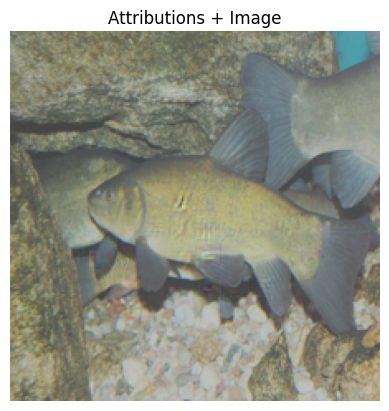

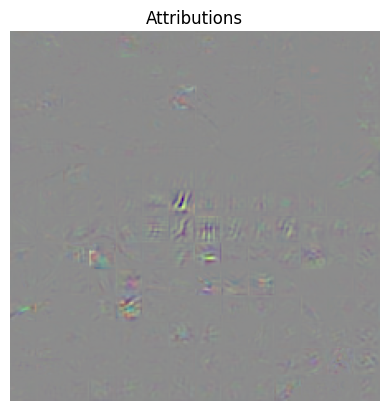

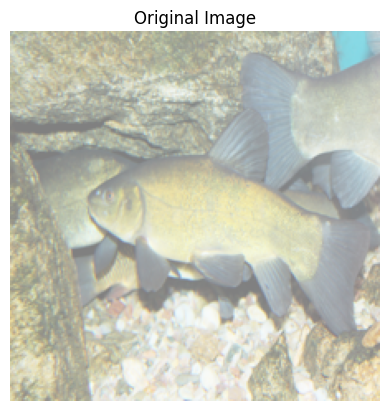

In [51]:
import matplotlib.pyplot as plt
import numpy as np
# Plot attributions
feature_names = ['Feature 1', 'Feature 2', 'Feature 3']

attributions_np =  (attributions - attributions.min()) / (attributions.max() - attributions.min())
attributions_np = attributions_np.squeeze().detach().cpu().numpy()
attributions_np = np.transpose(attributions_np, (1,2,0))
img_array = np.array(image.resize((224,224)))#.transpose((2,0,1))
#print(attributions.max(),attributions.min())
plt.imshow(attributions_np, cmap="bwr", vmin=attributions_np.min(), vmax=attributions_np.max(), alpha=1)
plt.imshow(img_array,alpha=0.5)
plt.title("Attributions + Image")
plt.axis('off')  # Turn off axes for cleaner display
plt.show()
plt.imshow(attributions_np, cmap="bwr", vmin=attributions_np.min(), vmax=attributions_np.max(), alpha=1)
plt.title("Attributions")
plt.axis('off')  # Turn off axes for cleaner display
plt.show()
plt.imshow(img_array,alpha=0.5)
plt.title("Original Image")
plt.axis('off')  # Turn off axes for cleaner display
plt.show()

In [37]:
img_array.shape

(224, 224, 3)

In [53]:
ema = [0.9,1.0]
momentum_scheduler1 = [ema[0] + i*(ema[1]-ema[0])/(100*100*1/1)
                          for i in range(int(100*100*1)+1)]
momentum_scheduler = iter(momentum_scheduler1)

In [54]:
for i in range(4):
    a = next(momentum_scheduler)
    print(a)

0.9
0.90001
0.90002
0.90003


In [55]:
torch.save(momentum_scheduler, "a.pth")

In [1]:
import torch
m = torch.load("a.pth")

In [2]:
for i in range(4):
    a = next(m)
    print(a)

0.9000400000000001
0.90005
0.90006
0.90007
